# Imports

In [1]:
%pylab inline

import pandas as pd
import warnings
import seaborn as sns
from scipy.spatial.distance import euclidean
import Co_Evo_Func as cef

from scipy.stats import sem
from scipy.stats import binom_test
from scipy.stats import f_oneway
from scipy.stats import pearsonr
from scipy.stats import wilcoxon
from scipy.stats import combine_pvalues
from scipy.stats import mannwhitneyu
from scipy.stats import boschloo_exact


from scipy.spatial import distance_matrix
from itertools import combinations
from sklearn.metrics import pairwise_distances
from sklearn import metrics
from statsmodels.stats.multitest import multipletests


import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import ast

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



%load_ext autoreload
%autoreload 2

sns.set(style='ticks', font_scale=2, rc={"lines.linewidth": 2, "axes.spines.right": False,
                                         "axes.spines.top": False, 'savefig.transparent': True})

species = ['Pf', 'Pch', 'Ea',
           'Ab', 'Pa', 'IN72',
           'Pv', 'Pci', 'Sm',
           'IN63', 'Fj','H79',
           'H82', 'IN65', 'H77']

### a consistent color map for species in the set:
species_dict = dict(zip(species, [sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2],
        sns.color_palette()[3], sns.color_palette()[4], sns.color_palette()[5], 
       sns.color_palette()[6], sns.color_palette()[7], sns.color_palette()[8],
        sns.color_palette()[9],  'maroon', 'yellow', 'steelblue', 'green']))


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Growth parameters

## general

In [2]:
# Curves has the full OD600 curves
curves = pd.read_excel( r"Data/Growth/curves.xlsx", index_col=[0, 1])
# Sum_stats has both metadata and manually determined shifts that were used to determine where to compute the growth rate from
sum_stats = pd.read_excel(r'Data/Growth/events181435.xlsx', index_col = [0, 1])

# remove contaminated controls.
cont_c = [('26_1_NL', 'D4'), ('26_1_LL', 'D4'),
          ('14_1_Ep', 'H11'), ('14_1_Sy', 'H11'),
          ("14_2_KL", 'F8'), ("14_2_LL", 'F8'),
         ("26_3_Sy", 'B2')]

curves = curves.loc[~curves.index.isin(cont_c)]
sum_stats = sum_stats.loc[~sum_stats.index.isin(cont_c)]

### compute the background of each plate by the mean in the controls and subtract from all rows of that plate
controls = curves.loc[sum_stats.species == 'c', curves.columns[-5:]].groupby('plate').mean().mean(axis = 1)

for plate in controls.index:
    curves.loc[plate] = (curves.loc[plate, :] - controls.loc[plate]).values
    
sum_stats['48h'] = sum_stats['48h']-0.044

curves = curves.rename(dict(zip(curves.columns, arange(5/60, 5*277/60, 5/60))), axis = 1)

### set a minimal thershold
curves[curves<0.01] = 0.01

# grs gives the curves per-capita growth rate
grs = (log2(curves).diff(axis = 1)).rolling(10, axis =1).mean()
grs[grs<0] = 0


### m-c columns indicates if the strain evolved in coculture or monocolture
sum_stats['m-c'] = sum_stats.apply(lambda x:cef.define_treat(x['ev_comm'], x['species']), axis = 1)
sum_stats.loc[sum_stats['treatment']=='anc', 'm-c'] = 'anc'
sum_stats = sum_stats.loc[~sum_stats['treatment'].isna()] 

### growth rate is defined as the median per-capita growth-rate between the manually deterimned shifts 
for i in sum_stats[~sum_stats['str_growth'].isna()].index:
    t_i = sum_stats.loc[i, 'str_growth'].astype(int)
    t_f = sum_stats.loc[i, 'end_growth'].astype(int)
    sum_stats.loc[i, 'eff_R'] = grs.loc[i, curves.columns[t_i]:curves.columns[t_f]].quantile(.5)*12

### When shifts are missing values, it indicates that no visible growth was detected. 
sum_stats.loc[sum_stats['str_growth'].isna(), 'eff_R'] = 0

sum_stats['treat'] = sum_stats.apply(lambda x:cef.define_treat_lvl(x['treatment'], x['m-c']), axis =1)
sum_stats = sum_stats[~sum_stats['species'].isin(['c', np.nan, 'H97'])]

### As population need to multiply by a factor of log2(1500) to survive dilutions we can define the minmal growth rate as log2(1500)/48 ~ .2
sum_stats.loc[sum_stats['eff_R']<.2 , 'eff_R'] = .2

### growth rate of ancestors to normalize to 
na_anc = sum_stats[sum_stats['treatment']=='anc'].groupby('species').agg({'eff_R':'mean'})
pre_anc =sum_stats[sum_stats['pre_anc']==True].groupby('species').agg({'eff_R':'mean'})

### R_norm is the normalized growth rate column
sum_stats['R_norm'] = NaN
sum_stats.loc[sum_stats['treatment'] == 'Naive', 'R_norm'] = sum_stats[sum_stats['treatment'] == 'Naive'].apply(lambda x:x['eff_R']/na_anc.loc[x['species'], 'eff_R'], axis =1)
sum_stats.loc[sum_stats['treatment'] == 'Pre-adapted', 'R_norm'] = sum_stats[sum_stats['treatment'] == 'Pre-adapted'].apply(lambda x:x['eff_R']/pre_anc.loc[x['species'], 'eff_R'], axis =1)
sum_stats = sum_stats.rename({'48h':'K'}, axis = 1)

### K of ancestors to normalize to 
na_anc['K'] = sum_stats[sum_stats['treatment']=='anc'].groupby('species').agg({'K':'mean'})['K']
pre_anc['K'] =sum_stats[sum_stats['pre_anc']==True].groupby('species').agg({'K':'mean'})['K']


### K_norm is the normalized K column
sum_stats['K_norm'] = NaN
sum_stats.loc[sum_stats['treatment'] == 'Naive', 'K_norm'] = sum_stats[sum_stats['treatment'] == 'Naive'].apply(lambda x:x['K']/na_anc.loc[x['species'], 'K'], axis =1)
sum_stats.loc[sum_stats['treatment'] == 'Pre-adapted', 'K_norm'] = sum_stats[sum_stats['treatment'] == 'Pre-adapted'].apply(lambda x:x['K']/pre_anc.loc[x['species'], 'K'], axis =1)


anc_uni = pd.DataFrame(index = species, columns=pd.MultiIndex.from_tuples([('Naive', 'eff_R'), ('Naive', 'K'), 
                                                                          ('Pre-adapted', 'eff_R'), ('Pre-adapted','K')],
                                                                          names = ['treatment', 'parameter']))
anc_uni['Naive'] = na_anc
anc_uni['Pre-adapted'] = pre_anc
anc_uni = anc_uni.stack(level = 'treatment')

### growth parameters of each strain avarged by technical replicates 
growth_technical = sum_stats[(sum_stats['treatment']!='anc')&(~sum_stats['ev_comm'].isin(['Ea-anc_Pa-anc']))].groupby(['species', 'treatment', 'm-c', 'ev_comm', 'ev_ident']).mean()
growth_technical_sem = sum_stats[(sum_stats['treatment']!='anc')&(~sum_stats['ev_comm'].isin(['Ea-anc_Pa-anc']))].groupby(['species', 'treatment', 'm-c', 'ev_comm', 'ev_ident']).sem()

### grand mean mead for co-evolves vs mono-evolved fro each species
gr_grand_mean = growth_technical.groupby(['species', 'treatment', 'm-c']).agg({'R_norm':['mean', 'sem'], 'K_norm':['mean', 'sem']}).dropna()


### mean for each biotic contexet seperatly
by_comm = growth_technical.groupby(['species', 'treatment',
                                    'm-c', 'ev_comm']).agg({'R_norm':['mean', 'sem'], 
                                 'K_norm':['mean', 'sem']}).loc[:,:,'Coevolved'].dropna()
by_comm[('R_norm', 'ref')] = gr_grand_mean.loc[:,:,'Monoevolved'][('R_norm', 'mean')]
by_comm[('K_norm', 'ref')] = gr_grand_mean.loc[:,:,'Monoevolved'][('K_norm', 'mean')]

## Parallelism

In [3]:
cols = pd.MultiIndex.from_tuples([('Distance', 'mean', 'between'),
                                  ('Distance', 'mean', 'within'), 
                                  ('Distance', 'mean', 'score'),
                                  ('Distance', 'sem', 'between'),
                                  ('Distance', 'sem', 'within'),
                                  ('Distance', 'sem', 'score'), 
                                  
                                  ('Distance', 'permutations', 'p-value'),
                                  ('Distance', 'permutations', 'n'),
                                  
                                 ('Par', 'mean', 'between'),
                                  ('Par', 'mean', 'within'), 
                                  ('Par', 'mean', 'score'),
                                  ('Par', 'sem', 'between'),
                                  ('Par', 'sem', 'within'),
                                  ('Par', 'sem', 'score'), 
                                  
                                 ('Par', 'permutations', 'p-value'),
                                  ('Par', 'permutations', 'n')])
    
# sum_growth sums the data regarding parallelism in growth abilities
sum_growth = pd.DataFrame(index = growth_technical.groupby(['species', 'treatment']).mean().index,
                             columns=cols)
# epsilon is defines as the standart error of technical replicates
eps = growth_technical_sem['R_norm'].mean()

# compute for each species, both in terms of parallelism and in terms of distances
for ind in sum_growth.index:
    ev_strains = growth_technical.loc[ind][['K', 'eff_R']].droplevel('m-c')
    anc_strains = anc_uni.loc[ind]
    
    d_mat, p_mat = cef.build_par_mat(ev_strains,
                                 anc_strains,
                                 eps,
                                 ev_strains.index, True, False)
    
    sum_growth.loc[ind] = cef.construct_sum_stat(ind,d_mat, p_mat, agg_lv = 0).loc[ind]
    
sum_growth = sum_growth[~sum_growth[('Distance', 'mean', 'between')].isna()]

### Permuatation tests

In [4]:

# for ind in sum_growth.index:
    
# #     eps = 0
#     ev_strains = growth_technical.loc[ind][['K', 'eff_R']].droplevel('m-c')
#     anc_strain = anc_uni.loc[ind]
    
#     scores = cef.perm_scores(ev_strains, anc_strain, eps,ind, 
#                 ret = 'dist', agg_lv =0, iters = 2000, reshape = False)
    
#     sum_growth.loc[ind, ('Distance', 'permutations', 'n')] = len(scores)
#     stat = sum_growth.loc[ind, ('Distance', 'mean', 'score')]
#     pv = ((scores>stat).sum()+1)/(len(scores)+1)
#     sum_growth.loc[ind,('Distance', 'permutations', 'p-value')] = pv
    
#     sum_growth.to_excel('Data/sum_growth_temp.xlsx', index = [0, 1])

# # Correct for multiple comparisons
# sum_growth[('p-corr')] = multipletests(sum_growth[('Distance', 'permutations', 'p-value')].astype(float64))[1]

# sum_growth.to_excel('Data/sum_data/sum_growth.xlsx', index = [0, 1])

In [5]:
sum_growth = pd.read_excel('Data/sum_data/sum_growth.xlsx', index_col = [0, 1],header = [0, 1, 2])
# sum_growth[('Par', 'mean')].reset_index().groupby('treatment').median()

# Composition

## General

In [6]:
### counts table Ev1
cf_anc_na = pd.read_excel('Data/composition/cf_ev1.xlsx')
cf_anc_na['ident'] = cf_anc_na['ident'].apply(lambda x:x.replace('_', ''))
cf_anc_na['first'] = cf_anc_na.apply(lambda x:x[x['sample'].split('_')[0]], 1)
cf_anc_na = cf_anc_na[cf_anc_na['sample_kind']=='Pair']

### counts table Ev2
cf_anc_pre = pd.read_excel('Data/composition/cf_ev2.xlsx')
cf_anc_pre = cf_anc_pre[~cf_anc_pre['sample'].isin(['Pci-anc_IN63-anc', 'Ea-anc_Pa-anc'])]
cf_anc_pre['first'] = cf_anc_pre.apply(lambda x:x[x['sample'].split('_')[0]], 1)
cf_anc_pre = cf_anc_pre[~cf_anc_pre['sample'].isin(['Ea-anc_Pa-anc', 'Pci-anc_IN63-anc'])][cf_anc_pre['sample_kind']!='Monocolture']

### counts table Ec1
CF = pd.read_excel('Data/composition/cf_ec1.xlsx', index_col=0)
CF['ev_comp'] = NaN
CF.loc[CF['Treatment'] == 'Pre-co', 'ev_comp'] = CF.loc[CF['Treatment'] == 'Pre-co', 'strain_a'].apply(lambda x: cf_anc_pre.loc[(cf_anc_pre['ident']==x)&(cf_anc_pre['transfer']==38), 'first'].values).apply(lambda x:x[0] if len(x) == 1 else NaN)
CF.loc[CF['Treatment'] == 'Na-co', 'ev_comp'] = CF.loc[CF['Treatment'] == 'Na-co', 'strain_a'].apply(lambda x: cf_anc_na.loc[(cf_anc_na['ident']==x)&(cf_anc_na['transfer']==38), 'first'].values).apply(lambda x:x[0] if len(x) == 1 else NaN)

CF.loc[CF['Treatment'].isin(['Pre-co', 'Pre-m']), 'anc_comp'] = CF.loc[CF['Treatment'].isin(['Pre-co', 'Pre-m']), 'sample'].apply(lambda x: cf_anc_pre.loc[(cf_anc_pre['sample']==x)&(cf_anc_pre['transfer']==7), 'first'].mean())
CF.loc[CF['Treatment'].isin(['Na-co', 'Na-m']), 'anc_comp'] = CF.loc[CF['Treatment'].isin(['Na-co', 'Na-m']), 'sample'].apply(lambda x: cf_anc_na.loc[(cf_anc_na['sample']==x)&(cf_anc_na['transfer']==7), 'first'].mean())

### evolved composition relative to ancestor
CF['change_dir'] = CF['anc_comp'] - CF['first']

CF['treatment'] = CF['Treatment'].apply(lambda x:x.split('-')[0])
CF['m-c'] = CF['Treatment'].apply(lambda x:x.split('-')[1])

CF['treatment'] = CF['treatment'].apply(lambda x:x.replace('Pre', 'Pre-adapted')).apply(lambda x:x.replace('Na', 'Naive'))
CF['m-c'] = CF['m-c'].apply(lambda x:x.replace('m', 'Monoevolved')).apply(lambda x:x.replace('co', 'Coevolved'))


#####
sps_rel = CF.columns[CF.columns.isin(species)]
CF['cont'] = CF.apply(lambda x:x[sps_rel[~sps_rel.isin(x['sample'].split('_'))]].sum()>0, axis = 1)
conts = CF[CF['cont']]
CF = CF[~CF['cont']]

## technical replicates mean
cf_tech = CF.groupby(['sample', 'treatment','m-c' ,'ev_ident']).agg({'first':['mean', 'sem'],'change_dir':'mean', 'anc_comp':'mean'})
cf_tech = cf_tech[~cf_tech[('change_dir', 'mean')].isna()]
cf_anc = cf_tech.groupby(['sample', 'treatment']).mean()[('anc_comp', 'mean')]

cf_gr = CF.groupby(['sample', 'Treatment', 'ev_ident']).mean().groupby(['sample', 'Treatment']).agg({'change_dir':['mean', 'sem']})
cf_gr = cf_gr.unstack()['change_dir']

## Parallelism

In [7]:
cols = pd.MultiIndex.from_tuples([('Distance', 'mean', 'between'),
                                  ('Distance', 'mean', 'within'), 
                                  ('Distance', 'mean', 'score'),
                                  ('Distance', 'sem', 'between'),
                                  ('Distance', 'sem', 'within'),
                                  ('Distance', 'sem', 'score'), 
                                  
                                  ('Distance', 'permutations', 'p-value'),
                                  ('Distance', 'permutations', 'n'),
                                  
                                 ('Par', 'mean', 'between'),
                                  ('Par', 'mean', 'within'), 
                                  ('Par', 'mean', 'score'),
                                  ('Par', 'sem', 'between'),
                                  ('Par', 'sem', 'within'),
                                  ('Par', 'sem', 'score'), 
                                  
                                 ('Par', 'permutations', 'p-value'),
                                  ('Par', 'permutations', 'n')])
    
sum_comp = pd.DataFrame(index = cf_tech.groupby(['sample', 'treatment']).mean().index,
                             columns=cols)
eps = CF.groupby(['sample', 'treatment','m-c' ,'ev_ident'])['first'].std().mean()

for ind in sum_comp.index:
#     print(ind)
    ev_strains = cf_tech.loc[ind][('first', 'mean')]
    anc_strains = cf_anc.loc[ind]
    
    d_mat, p_mat = cef.build_par_mat(ev_strains,
                                 anc_strains,
                                 eps,
                                 ev_strains.index, ret_both=True, reshape = True)
    
    sum_comp.loc[ind] = cef.construct_sum_stat(ind,d_mat, p_mat,agg_lv = 0).loc[ind]

### Permutation tests

In [8]:
# sum_comp = sum_comp[~sum_comp[('Distance', 'mean', 'between')].isna()]
# for ind in sum_comp.index:
    
#     ev_strains = cf_tech.loc[ind, ('first', 'mean')]
#     anc_strains = cf_anc.loc[ind]
    
#     scores = cef.perm_scores(ev_strains, anc_strains, eps,ind, 
#                 ret = 'dist', agg_lv =0, iters = 200, reshape = True)
    
#     sum_comp.loc[ind,('Distance', 'permutations', 'n')] = len(scores)
#     stat = sum_comp.loc[ind,('Par', 'mean', 'score')]
    
#     pv = ((scores>stat).sum()+1)/(len(scores)+1)
#     sum_comp.loc[ind,('Distance', 'permutations', 'p-value')] = pv
# sum_comp.to_excel('Data/sum_comp_temp.xlsx', index = [0, 1])

In [9]:
sum_comp = pd.read_excel('Data/sum_data/sum_comp.xlsx', index_col = [0, 1], header= [0, 1, 2])

# Interactions

## Ancestral

In [10]:
OD_Ev1 = pd.read_excel('Data/Growth/OD_Ev1.xlsx', index_col= 0)
OD_Ev2 = pd.read_excel('Data/Growth/OD_Ev2.xlsx')

OD_Ev1['ident'] =  OD_Ev1['ident'].apply(lambda x: x.replace('_', ''))
OD_Ev2['ident'] =  OD_Ev2['ident'].apply(lambda x: x.replace('_', ''))


cf_anc_na['OD'] = cf_anc_na.apply(lambda x:OD_Ev1.loc[(OD_Ev1['transfer']==x['transfer'])&(OD_Ev1['ident']==x['ident']), 'OD'].mean(), axis = 1)
cf_anc_pre['OD'] = cf_anc_pre.apply(lambda x:OD_Ev2.loc[(OD_Ev2['transfer']==x['transfer'])&(OD_Ev2['ident']==x['ident']), 'OD'].mean(), axis = 1)

inter_na = cf_anc_na[(cf_anc_na['transfer']==7)&(cf_anc_na['sample_kind']=='Pair')]
inter_pre = cf_anc_pre[(cf_anc_pre['transfer']==7)&(~cf_anc_pre['sample'].isin(['Ea-anc_Pa-anc', 'Pci-anc_IN63-anc']))]

inter_na = inter_na.apply(lambda x:cef.get_interaction(x, OD_Ev1[OD_Ev1['transfer']==7]), axis = 1)
inter_pre = inter_pre.apply(lambda x:cef.get_interaction(x, OD_Ev2[OD_Ev2['transfer']==7]), axis = 1)
inter_na = cef.stack_int_table(inter_na)
inter_pre = cef.stack_int_table(inter_pre.drop(['Well', 'plate'], axis = 1), 12)


I:\.shortcut-targets-by-id\1nlEq9BMhr7-Ld4Bf5dz17TE0PaF3yO7W\Shared\Lab_members\Nittay_Meroz\manuscripts\Effect of preadaptation\github_rep\Coevo_parallelsim\Co_Evo_Func.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_table[int_table == 0] = np.nan
I:\.shortcut-targets-by-id\1nlEq9BMhr7-Ld4Bf5dz17TE0PaF3yO7W\Shared\Lab_members\Nittay_Meroz\manuscripts\Effect of preadaptation\github_rep\Coevo_parallelsim\Co_Evo_Func.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_table[int_table == 0] = np.nan
I:\.shortcut-targets-by-id\1nlEq9BMhr7-Ld4Bf5dz17TE

## Evolved

In [11]:
cf_int = pd.read_excel('Data/Interaction/cf_org.xlsx')

int_prep = cef.pars_by_sps(cf_int) # divide each two sided interaction, to a one-sided df
int_anc = int_prep[(int_prep['anc'])] # Ancestral interctions
int_anc.loc[int_anc["Pre_anc"], 'treatment'] = 'Pre-adapted'
int_anc = int_anc.groupby(['exp', 'species', 'treatment', 'pair']).mean() # agg ancestral interactions

int_ev = int_prep[~int_prep['anc']] # Only evolved strains

# Compute the difference from ancestor
int_ev['diff_fanc'] = int_ev.apply(lambda x:cef.fanc_int(x['exp'],
                                                     x['species'],
                                                     x['treatment'],
                                                     x['pair'],
                                                     x['effect'],
                                                     int_anc), axis = 1).dropna()

# Agg by technical replicates
int_tech = int_ev.groupby(['exp',  'species','treatment', 'pair', 'm-c', 'strain', 'strain_part']).agg({'effect':'mean', 
                                                                            'diff_fanc':'mean', 'total':'mean',
                                                                                         'strain':'count'})
# Use only interactions with more then 1 evo replicates
int_tech = int_tech[int_tech['strain']>1]

# Context mean
int_gr = int_tech.groupby(['exp', 'species', 'treatment','pair', 'm-c',]).agg({'effect':['mean', 'sem', 'count'],
                                                                               'diff_fanc':['mean', 'sem'], 'total':['mean', 'sum']}).unstack()
int_gr = int_gr[(~int_gr[('diff_fanc', 'mean', 'Coevolved')].isna()&~int_gr[('diff_fanc', 'mean', 'Monoevolved')].isna())]
   
### We only compare interactions from the same experiment, we remove those that apear more then once by finding which has the most evo replicates
dups = cef.get_dups(int_gr)
rem_dup = cef.remove_dups(int_gr, dups)

int_anc = int_anc[int_anc.apply(lambda x:x.name in int_gr.index, axis = 1)].groupby(['species', 'treatment', 'pair']).mean()
int_gr = int_gr.drop(rem_dup).dropna().droplevel(0)
int_tech = int_tech[~int_tech.apply(lambda x:(x.name[0], x.name[1], x.name[2], x.name[3]) in rem_dup, axis = 1)]

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\2334430959.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_ev['diff_fanc'] = int_ev.apply(lambda x:cef.fanc_int(x['exp'],
I:\.shortcut-targets-by-id\1nlEq9BMhr7-Ld4Bf5dz17TE0PaF3yO7W\Shared\Lab_members\Nittay_Meroz\manuscripts\Effect of preadaptation\github_rep\Coevo_parallelsim\Co_Evo_Func.py:538: PerformanceWarning: indexing past lexsort depth may impact performance.
  exp = gr_table.loc[:, pair[0], pair[1], pair[2]][('effect', 'count')].mean(axis=1).idxmin()


## Parallelism

In [12]:
cols = pd.MultiIndex.from_tuples([('Distance', 'mean', 'between'),
                                  ('Distance', 'mean', 'within'), 
                                  ('Distance', 'mean', 'score'),
                                  ('Distance', 'sem', 'between'),
                                  ('Distance', 'sem', 'within'),
                                  ('Distance', 'sem', 'score'), 
                                  
                                  ('Distance', 'permutations', 'p-value'),
                                  ('Distance', 'permutations', 'n'),
                                  
                                 ('Par', 'mean', 'between'),
                                  ('Par', 'mean', 'within'), 
                                  ('Par', 'mean', 'score'),
                                  ('Par', 'sem', 'between'),
                                  ('Par', 'sem', 'within'),
                                  ('Par', 'sem', 'score'), 
                                  
                                 ('Par', 'permutations', 'p-value'),
                                  ('Par', 'permutations', 'n')])


    
sum_int = pd.DataFrame(index = int_gr.index,
                             columns=cols)

eps = int_ev.groupby(['exp',  'species','treatment', 'pair', 'm-c', 'strain', 'strain_part'])['effect'].std().mean()

for ind in sum_int.index:

    ev_strains = int_tech.droplevel('exp').loc[ind]['effect'].dropna()
    anc_strains = int_anc.loc[ind]['effect']
    
    d_mat, p_mat = cef.build_par_mat(ev_strains,
                                 anc_strains,
                                 eps,
                                 ev_strains.index, ret_both=True, reshape = True)
    
    sum_int.loc[ind] = cef.construct_sum_stat(ind,d_mat, p_mat,agg_lv = 0).loc[ind]

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\2845944055.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  ev_strains = int_tech.droplevel('exp').loc[ind]['effect'].dropna()
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\2845944055.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  ev_strains = int_tech.droplevel('exp').loc[ind]['effect'].dropna()
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\2845944055.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  ev_strains = int_tech.droplevel('exp').loc[ind]['effect'].dropna()
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\2845944055.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  ev_strains = int_tech.droplevel('exp').loc[ind]['effect'].dropna()
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\2845944055.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  ev_strains = int_tech.

### Permutation tests

In [13]:
# for ind in sum_int.index:
    
#     ev_strains = int_tech.droplevel(['exp', 'strain_part']).loc[ind]['effect'].dropna()
#     anc_strains = int_anc.loc[ind]['effect']
    
#     scores = cef.perm_scores(ev_strains, anc_strains, eps,ind, 
#                 ret = 'dist', agg_lv = 0, iters = 2000, reshape = True)
    
#     sum_int.loc[ind,('Distance', 'permutations', 'n')] = len(scores)
#     stat = sum_int.loc[ind,('Par', 'mean', 'score')]
    
#     pv = ((scores>stat).sum()+1)/(len(scores)+1)
#     sum_int.loc[ind,('Distance', 'permutations', 'p-value')] = pv
#     sum_int.to_excel('Data/sum_int_temp.xlsx', index = [0, 1, 2])

# sum_int.to_excel('Data/sum_data/sum_int.xlsx', index = [0, 1, 2])

In [14]:
sum_int = pd.read_excel('Data/sum_data/sum_int.xlsx', index_col = [0, 1, 2], header=[0, 1, 2])

# Mutations 

In [15]:
mut_table = pd.read_excel('Data/Mutations/num_mut.xlsx', index_col=0)

mut_table['gene_product'] = mut_table['gene_product'].apply(lambda x: ast.literal_eval(x) if str(x).startswith('[') else x)
mut_table['eff_gene'] = mut_table['eff_gene'].apply(lambda x: ast.literal_eval(x) if str(x).startswith('[') else x)

strain_table = pd.read_excel('Data/Mutations/strains_with_num.xlsx', index_col=0)
# by_part aggregrates by biotic context
by_part = strain_table[strain_table['m-c']=='co'].groupby(['Species', 'Pre-Na','ev-comm']).agg({'n_mut':['mean', 'sem']}).reset_index(2)
# by_sp is grand mean of each species
by_sp = strain_table.groupby(['Species', 'Pre-Na', 'm-c']).agg({'n_mut':['mean', 'sem']}).unstack()['n_mut']
by_part['mono'] = by_sp[('mean', 'mono')]

## Parallelism

In [16]:
### Use only mutation with an affect over some gene
mut_table = mut_table[~mut_table['gene_product'].isnull()]
mut_table = mut_table[~(mut_table['mutation_category']=='snp_synonymous')]

st_ind = mut_table.groupby(['Species', 'Pre-Na', 'ev-comm', 'strain']).mean().index # all strains with metadata
    
###### Build strain to strain similarity matrix
dist_mat = pd.DataFrame(columns=st_ind, index = st_ind) # similarity matrix
for pair in list(combinations(mut_table['strain'].unique(), 2)): #for each combination of strains
    if pair[0].split('_')[0] == pair[1].split('_')[0]: # Don't compute for strains of different species
        score = cef.calculate_dice_sim(pair[0], pair[1], mut_table)  # calculate dice similarity
        # write the score in the dist_mat
        dist_mat.loc[(slice(None),slice(None),slice(None), pair[0]), (slice(None),slice(None),slice(None),  pair[1])] = score
        dist_mat.loc[(slice(None),slice(None),slice(None), pair[1]), (slice(None),slice(None),slice(None),  pair[0])] = score 


In [17]:
cols = pd.MultiIndex.from_tuples([('Par', 'mean', 'between'),
                                  ('Par', 'mean', 'within'), 
                                  ('Par', 'mean', 'score'),
                                  ('Par', 'sem', 'between'),
                                  ('Par', 'sem', 'within'),
                                  ('Par', 'sem', 'score'),                
                                 ('Par', 'permutations', 'p-value'),
                                  ('Par', 'permutations', 'n')])
    
sum_gene = pd.DataFrame(index = dist_mat.groupby(['Species', 'Pre-Na']).mean().index,
                             columns=cols)
eps = 0

for ind in sum_gene.index:
#     print(ind)    
    d_mat, p_mat = (1-dist_mat.loc[ind][ind]), dist_mat.loc[ind][ind]
    sum_gene.loc[ind] = cef.construct_sum_stat(ind,d_mat, p_mat,agg_lv = 0, measures=['Par']).loc[ind]
sum_gene.index = sum_gene.index.set_names(['species', 'treatment'])


### Permutation tests

In [18]:
# for ind in sum_gene.index:
    
#     temp = mut_table.loc[(mut_table['Species']==ind[0])&(mut_table['Pre-Na']==ind[1])]
#     st_ind = temp.groupby(['ev-comm', 'strain']).mean().index # all strains with metadata
#     temp_mat = pd.DataFrame(columns=st_ind, index = st_ind) 
    
#     inds_lev2 = list(st_ind.get_level_values(1))
#     inds_perm = list(st_ind.get_level_values(0))
        
#     perms = 2000
#     ress = []
#     commo = cef.get_common(ind)
#     ind_set = set([cef.turn_to_set(st_ind)])

#     for i in range(perms):
#         if i%100 == 0:
#             print(ind, i)
#         random.shuffle(inds_perm)
#         new_index = pd.MultiIndex.from_arrays([inds_perm, inds_lev2], names = st_ind.names)
#         check_new = cef.turn_to_set(new_index)
        
#         if check_new in ind_set:
#             continue
#         else:
#             ind_set.add(check_new)
#             temp_mat_perm = pd.DataFrame(columns=new_index, index = new_index) 
#             for pair in list(combinations(temp['strain'].unique(), 2)): #for each combination of strains

#                 score = cef.calculate_dice_sim(pair[0], pair[1], mut_table)  # calculate dice similarity

#                 # write the score in the dist_mat
#                 temp_mat_perm.loc[(slice(None), pair[0]),
#                              (slice(None),  pair[1])] = score
#                 temp_mat_perm.loc[(slice(None), pair[1]),
#                              (slice(None),  pair[0])] = score 
#             ress.append(cef.get_sum_dists(temp_mat_perm, 0, 
#                                               'within', np.mean) - cef.get_sum_dists(temp_mat_perm, 0,
#                                                                                              'between', np.mean))
#     stat = sum_gene.loc[ind,('Par', 'mean', 'score')]
#     ress = np.array(ress)
#     sum_gene.loc[ind,('Par', 'permutations', 'p-value')] = ((ress>=stat).sum()+1)/(len(ress)+1)
#     sum_gene.loc[ind,('Par', 'permutations', 'n')] = len(ress)
#     sum_gene.to_excel('sum_gene_temp.xlsx', index = [0, 1, 2])
    
# sum_gene.to_excel('Data/sum_data/sum_gene.xlsx', index = [0, 1, 2])


In [19]:
sum_gene = pd.read_excel('Data/sum_data/sum_gene.xlsx', index_col = [0, 1], header = [0, 1,2])

##  Affected genes

In [20]:
### mean number of mutations in each strain in each treatment
strain_numbers = strain_table.groupby(['Species', 'Pre-Na', 'ev-comm']).agg({'ev-ident':"count", 'n_mut':'mean'})
### remove synonymous snps
mut_g = mut_table[(~mut_table['eff_gene'].isna())&(mut_table['mutation_category']!='snp_synonymous')]
### explode such that each eff gene gets a seperate row
eff_gene_full = mut_g.explode('eff_gene', ignore_index=True)
### count the number of mutations affecting a gene occured in each species in each evolutionary treatment
mut_g = pd.DataFrame(eff_gene_full.groupby(['Species', 'Pre-Na', 'ev-comm'])['eff_gene'].value_counts())

## mutations in gene per strain
mut_g['Freq_int_treat'] = mut_g['eff_gene']/strain_numbers['ev-ident']

### Excpeted freqency is calculated as the probability to mutataion in this gene given a uniform mutation distribution
mut_g['Excpected_freq'] = np.nan
mut_g = mut_g.rename({'eff_gene':'N_occ'}, axis = 1).reset_index()

indetifiers = []  

for sp in by_part.index.get_level_values('Species').unique():
    print(sp)
    temp = pd.read_excel(f'Data/Mutations/anc_data/{sp}.xlsx', index_col = 0)
    temp['fraction_of_genome'] = temp['fraction_of_genome']/temp['fraction_of_genome'].sum()
    indetifiers.append(temp.loc[0, 'locus_tag'].split('_')[0])
#     loc_tags = temp['locus_tag']
    mut_g.loc[mut_g['Species']==sp, 'Excpected_freq'] = mut_g.loc[mut_g['Species']==sp, 'eff_gene'].apply(lambda x:cef.get_gene_frac(x, temp))

num_eff_genes = eff_gene_full.groupby(['Species', 'Pre-Na'])['gene_name'].count() # Number of effected genes by species
    

Ab
Ea
Pa
Pch
Pf
Sm


In [21]:
### Build a contingency table:
cont_table = mut_g.groupby(['Species','Pre-Na' ,'eff_gene']).agg({'N_occ':'sum', 'Excpected_freq':'mean'}).reset_index(2)
cont_table['n_strains'] = strain_numbers['ev-ident'].groupby(['Species', 'Pre-Na']).sum()
cont_table['n_mutations'] = mut_g.groupby(['Species', 'Pre-Na']).agg({'N_occ':'sum'})

cont_table['Excpected'] = cont_table.apply(lambda x: x['Excpected_freq']*num_eff_genes.loc[x.name[0], x.name[1]], axis =1)
cont_table['G'] = 2*cont_table['N_occ']*log(cont_table['N_occ']/cont_table['Excpected'])

sig_genes = cont_table.loc[cont_table['G']>cont_table['G'].quantile(.95), 'eff_gene']

gene_eff = mut_g[mut_g['eff_gene'].isin(sig_genes.values)]

gene_eff = gene_eff.set_index(['Species', 'Pre-Na', 'ev-comm'])

# Number of total strains of the species
gene_eff['n_strains'] = strain_numbers['ev-ident']
# Number of occurences outside of the group
gene_eff['N_occ_out'] = gene_eff.apply(lambda x:gene_eff.loc[x.name[0], x.name[1],(gene_eff['eff_gene']==x['eff_gene'])]['N_occ'].sum() - x['N_occ'], axis =1)
# Number of strians outside of the group
gene_eff['n_out'] = gene_eff.apply(lambda x: strain_numbers.loc[x.name[0], x.name[1], :]['ev-ident'].sum() - strain_numbers.loc[x.name[0], x.name[1], x.name[2]]['ev-ident'], axis = 1)

#Boxchloo test
def build_cont(X):
    return array([[X['N_occ'], X['n_strains'] - X['N_occ']],
                  [X['N_occ_out'], X['n_out']-X['N_occ_out']]])

BET = gene_eff.apply(lambda x: boschloo_exact(build_cont(x)), axis =1)

gene_eff['BE_stat'] = BET.apply(lambda x:x.statistic)
gene_eff['BE_pv'] = BET.apply(lambda x:x.pvalue)
gene_eff['BE_p_corr'] = multipletests(gene_eff['BE_pv'].astype('float64'), method = 'fdr_bh')[0]
gene_eff['pair'] = gene_eff.apply(lambda x:x.name[0] + ':' + x.name[2], axis = 1)


In [22]:
partner_specific = gene_eff[gene_eff.BE_pv<0.05][['eff_gene', 'N_occ', 'n_strains', 'N_occ_out', 'n_out', 'BE_pv', 'BE_p_corr']]
partner_specific.to_excel('Data/Mutations/partner_specific_genes.xlsx')

# Main figures

## Figure 2

### A+B

C:\Users\nitta\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


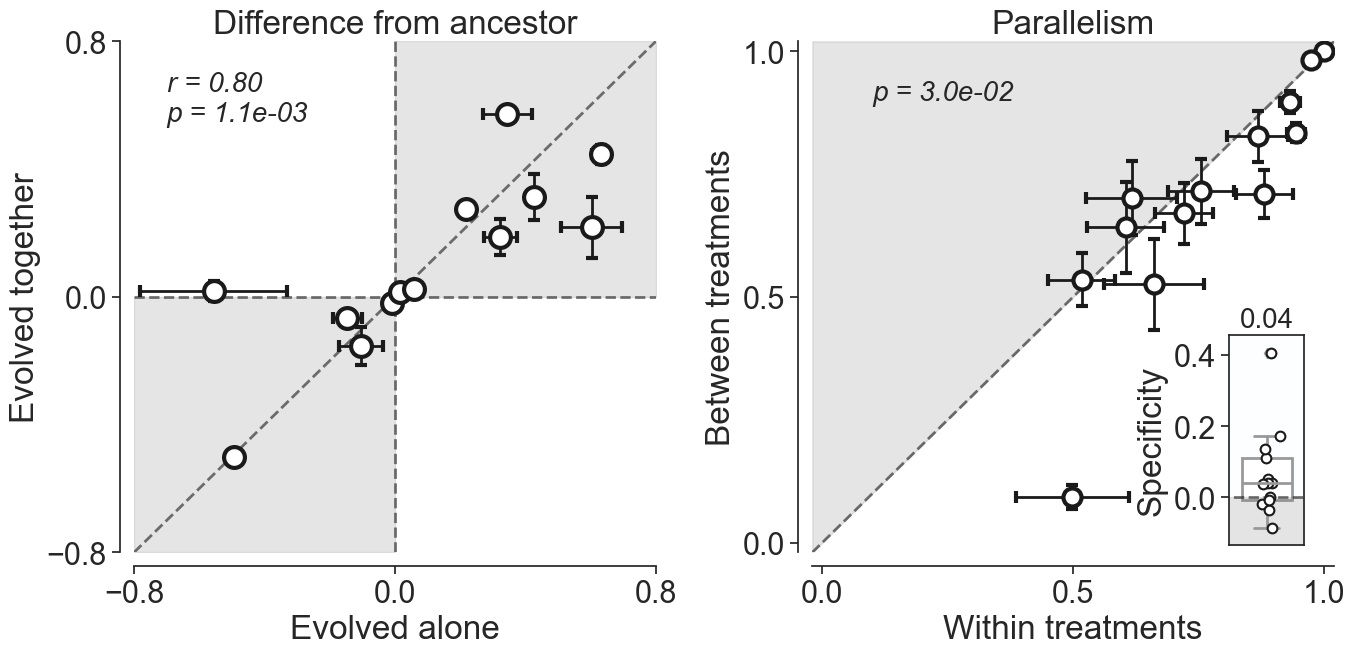

In [23]:
fig, ax = subplots(1, 2, figsize = (15, 7))

subplots_adjust(wspace = .3, left = 0.1, bottom = 0.15)



ax[0].errorbar(y = cf_gr[('mean', 'Na-co')],
               x = cf_gr[('mean', 'Na-m')], 
               yerr = cf_gr[('sem', 'Na-co')], 
               xerr = cf_gr[('sem', 'Na-m')], 
         fmt = 'o', mfc = 'white' ,ms = 15, color = 'k', mew = 3, capsize = 4)


ax[0].fill_between([-.8, 0], y1=0, y2 = -.8, color = 'grey', alpha = .2)
ax[0].fill_between([0, .8], y1=.8, y2 = .0, color = 'grey', alpha = .2)


ax[0].set_title('Difference from ancestor')

ax[0].set_xlabel('Evolved alone')
ax[0].set_ylabel('Evolved together')

ax[0].plot([-.8, .8], [-.8, .8], '--', color = 'k',alpha =0.6)
ax[0].plot([0, 0], [-.8, .8], '--', color = 'k',alpha =0.6)
ax[0].plot([-.8, .8], [0, .0], '--', color = 'k',alpha =0.6)

ax[0].set_yticks([-.8, 0, .8])
ax[0].set_xticks([-.8, 0, .8])
ax[0].set_xlim(-.8, .8)
ax[0].set_ylim(-.8, .8)

x, y = cf_gr['mean'].dropna()['Na-m'], cf_gr['mean'].dropna()['Na-co']
pr, pp = pearsonr(x, y)


ax[0].text(-0.7, 0.55,'r = {:.2f} \np = {:.1e}'.format(pr, pp), size = 20, style = 'italic')


sns.despine(offset = 10, ax = ax[0])

temp = sum_comp.loc[:, 'Naive', :]

cef.plot_par(temp, 'Par',('Distance', 'permutations', 'p-value'), species_dict, paired=True, ax = ax[1])
xticks([0, .5, 1]);
yticks([0, .5, 1]);
title('Parallelism')
cef.pec_score_inset(temp, 'Par',('Distance', 'permutations', 'p-value'), 
                species_dict,  paired=True, 
                fig  = fig, bottom = 0.16, left = 0.83, width = 0.05)

wp = wilcoxon(temp[('Par', 'mean', 'score')].dropna(), alternative='greater')[1]
ax[1].text(0.1, 0.9,'p = {:.1e}'.format(wp), size = 20, style = 'italic')

savefig('figures/Main/2AB.png')

In [24]:
temp = sum_comp.loc[:, 'Naive', :]
temp[('Par', 'mean')].median()

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3164934944.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  temp[('Par', 'mean')].median()


between    0.709092
within     0.755119
score      0.040340
dtype: float64

### C+D

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3413141052.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['p_corr'] = multipletests(temp[('Distance', 'permutations', 'p-value')].astype(numpy.float64))[1]


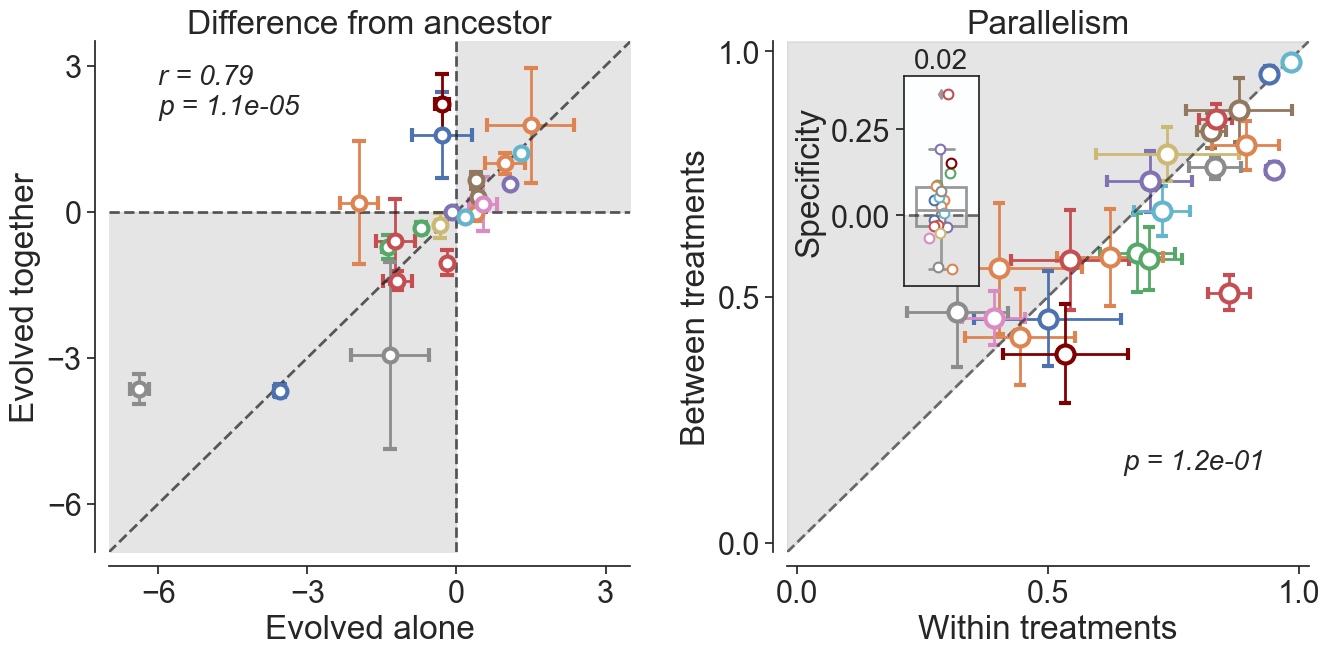

In [25]:
fig, ax = subplots(1, 2, figsize = (15, 7))
subplots_adjust(wspace = .3, left = 0.1, bottom = 0.15)

temp = int_gr.loc[:,'Naive', :]['diff_fanc']


for sp in temp.index.get_level_values(0).unique():
    
    ax[0].errorbar(y = temp.loc[sp][('mean', 'Coevolved')], 
                   x = temp.loc[sp][('mean', 'Monoevolved')], 
                   yerr = temp.loc[sp][('sem', 'Coevolved')], 
                   xerr =temp.loc[sp][('sem', 'Monoevolved')], 
                   fmt = 'o',color = species_dict[sp],
                   mfc = 'w', ms = 10, capsize = 5, mew = 3)
    

ax_min, ax_max = -7, 3.5

ax[0].plot([ax_min, ax_max], [ax_min, ax_max], color = 'k', alpha = .7, linestyle = '--')
ax[0].plot([0, 0], [ax_min, ax_max], color = 'k', alpha = .7, linestyle = '--')
ax[0].plot([ax_min, ax_max], [0, 0], color = 'k', alpha = .7, linestyle = '--')


ax[0].fill_between([-8, 0], y1=0, y2 = -8, color = 'grey', alpha = .2)
ax[0].fill_between([0, 8], y1=8, y2 = .0, color = 'grey', alpha = .2)


ax[0].set_xlabel('Evolved alone')
ax[0].set_ylabel('Evolved together')

sns.despine(offset = 10, ax = ax[0])
ax[0].set_title('Difference from ancestor')

ax[0].set_yticks([-6, -3, 0, 3]);
ax[0].set_xticks([-6, -3, 0, 3]);

ax[0].set_xlim(ax_min, ax_max)
ax[0].set_ylim(ax_min, ax_max)

x, y = temp[('mean', 'Monoevolved')], temp[('mean', 'Coevolved')]

pr, pp = pearsonr(x, y)

ax[0].text(-6, 2.,'r = {:.2f} \np = {:.1e}'.format(pr, pp), size = 20, style = 'italic')

##########################################################################################################

temp = sum_int.loc[:, 'Naive', :]

temp['p_corr'] = multipletests(temp[('Distance', 'permutations', 'p-value')].astype(numpy.float64))[1]

cef.plot_par(temp, 'Par','p_corr', species_dict, paired=False, ax = ax[1])
ax[1].set_xticks([0, .5, 1]);
ax[1].set_yticks([0, .5, 1]);
ax[1].set_title('Parallelism')
cef.pec_score_inset(temp, 'Par','p_corr', 
                species_dict,  paired=False, 
                fig  = fig, bottom = 0.53, left = 0.63, width = 0.05)

wp = wilcoxon(temp[('Par', 'mean', 'score')], alternative='greater')[1]
ax[1].text(.65, .15, 'p = {:.1e}'.format(wp), size = 20, style = 'italic')

savefig('figures/Main/2CD.png')

In [26]:
temp = sum_int.loc[:, 'Naive', :]
combine_pvalues(temp[('Distance', 'permutations', 'p-value')])

SignificanceResult(statistic=49.791975567305094, pvalue=0.25378084037223025)

## Figure 3

### A

WilcoxonResult(statistic=7.0, pvalue=0.5625)


C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\467827296.py:80: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subplots_adjust(hspace = .1, wspace = .1,
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\467827296.py:84: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  savefig('figures/Main/3Ang')
C:\Users\nitta\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


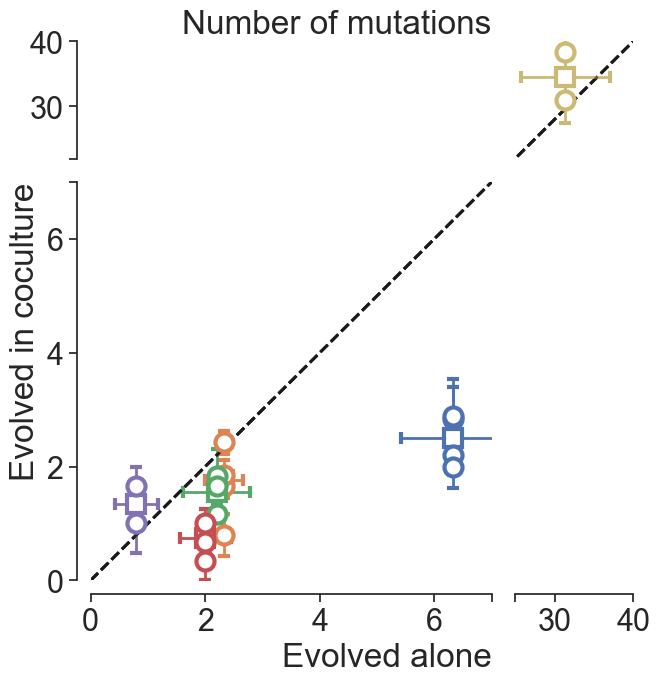

In [27]:
by_part = strain_table[strain_table['m-c']=='co'].groupby(['Species', 'Pre-Na','ev-comm']).agg({'n_mut':['mean', 'sem']}).reset_index(2)
by_sp = strain_table.groupby(['Species', 'Pre-Na', 'm-c']).agg({'n_mut':['mean', 'sem']}).unstack()['n_mut']
by_part['mono'] = by_sp[('mean', 'mono')]

fig = plt.figure(constrained_layout=True, figsize=(7, 7))
level = 'Naive'
gs = gridspec.GridSpec(4, 4)


ax1 = fig.add_subplot(gs[1:4, 0:3])
ax2 = fig.add_subplot(gs[1:4, 3:])
ax3 = fig.add_subplot(gs[0:1, 0:3])
ax4 = fig.add_subplot(gs[0:1:, 3:])


for i, sp in enumerate(species):
    if sp in by_part.index.get_level_values('Species'):
        for ax in [ax1, ax2, ax3, ax4]:
            ax.errorbar(x = by_sp.loc[sp, 'Naive'][('mean', 'mono')],
                        y = by_sp.loc[sp, 'Naive'][('mean', 'co')], 
                    xerr = by_sp.loc[sp, 'Naive'][('sem', 'mono')],
                     fmt = 's', 
                     mfc = 'white', color = sns.color_palette()[i],
                        mew = 3,ms = 13, label = sp, capsize = 4)

            ax.errorbar(x = by_part.loc[sp, 'Naive']['mono'], y = by_part.loc[sp, 'Naive'][('n_mut', 'mean')], 
                    yerr = by_part.loc[sp, 'Naive'][('n_mut', 'sem')],
                     fmt = 'o', 
                     mfc = 'white', color = sns.color_palette()[i],
                        mew = 3,ms = 13,  capsize = 4)
            ax.plot([0, 40], [0, 40], '--', color = 'k',alpha =0.6)

            
            
ax1.set_ylim(0, 7)
ax1.set_xlim(0, 7)
ax1.set_xticks([0, 2, 4, 6, 7])
ax1.set_xticklabels([0, 2, 4, 6, ''])
ax1.set_yticks([0, 2, 4, 6, 7])
ax1.set_yticklabels([0, 2, 4, 6, ''])




ax2.set_ylim(0, 7)
ax2.set_xlim(25, 40)
ax2.set_xticks([25, 30, 40])
ax2.set_xticklabels(['', 30, 40])


ax3.set_ylim(22, 40)
ax3.set_xlim(0, 7)
ax3.set_yticks([22, 30, 40])
ax3.set_yticklabels(['', 30, 40])

ax4.set_ylim(22, 40)
ax4.set_xlim(22, 40)

sns.despine(offset  = 10, ax = ax1)
sns.despine(offset  = 10, ax = ax2, left = True)
sns.despine(offset  = 10, ax = ax3, right = True, bottom = True)
sns.despine(offset  = 10, ax = ax4, left = True, right = True, bottom=True)


ax2.set_yticks([])
ax3.set_xticks([])

ax4.set_yticks([])
ax4.set_xticks([])

ax3.set_title('Number of mutations', loc = 'right')
ax1.set_ylabel('Evolved in coculture',
               loc = 'top')
ax1.set_xlabel('Evolved alone', loc = 'right')

print(wilcoxon(by_sp.loc[:,level, :][('mean', 'mono')], 
        by_sp.loc[:,level, :][('mean', 'co')]))


subplots_adjust(hspace = .1, wspace = .1,
                left = 0.155, right = .95,
                bottom = 0.5, top = 1)

savefig('figures/Main/3Ang')

### B

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\912987975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['p-corr'] = multipletests(temp[('Par', 'permutations', 'p-value')].astype(np.float64))[1]


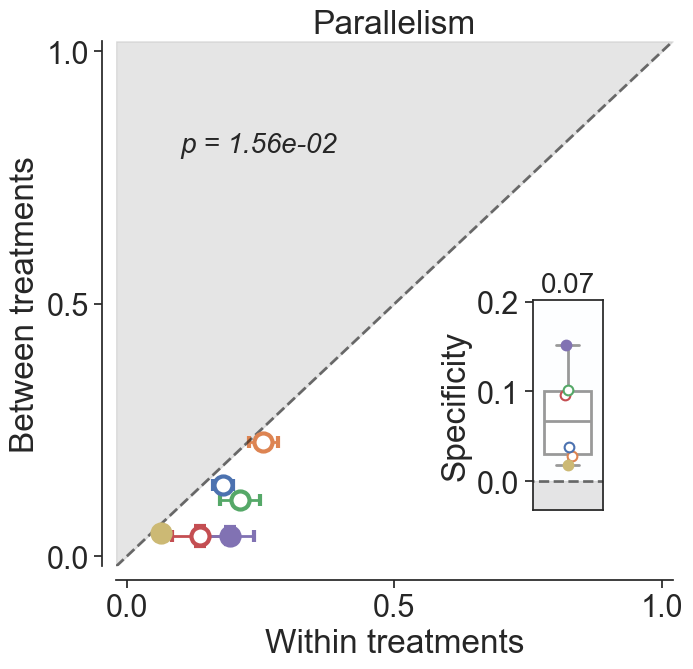

In [28]:
fig, ax = subplots(1, 1, figsize = (7, 7))

temp = sum_gene.loc[:, 'Naive', :]
temp['p-corr'] = multipletests(temp[('Par', 'permutations', 'p-value')].astype(np.float64))[1]

wp = wilcoxon(temp[('Par', 'mean', 'score')], alternative = 'greater')[1]

text(.1, .8,'p = {:.2e}'.format(wp), size = 20, style = 'italic')

cef.plot_par(temp, 'Par','p-corr', species_dict, paired=False, ax = ax)
xticks([0, .5, 1]);
yticks([0, .5, 1]);
title('Parallelism')

cef.pec_score_inset(temp, 'Par','p-corr', 
                species_dict,  paired=False, 
                fig  = fig, bottom = 0.23, left = 0.75)




subplots_adjust(left = 0.155, right = .95,
                bottom = 0.15, top = .9)

savefig('figures/Main/3B.png')

### C

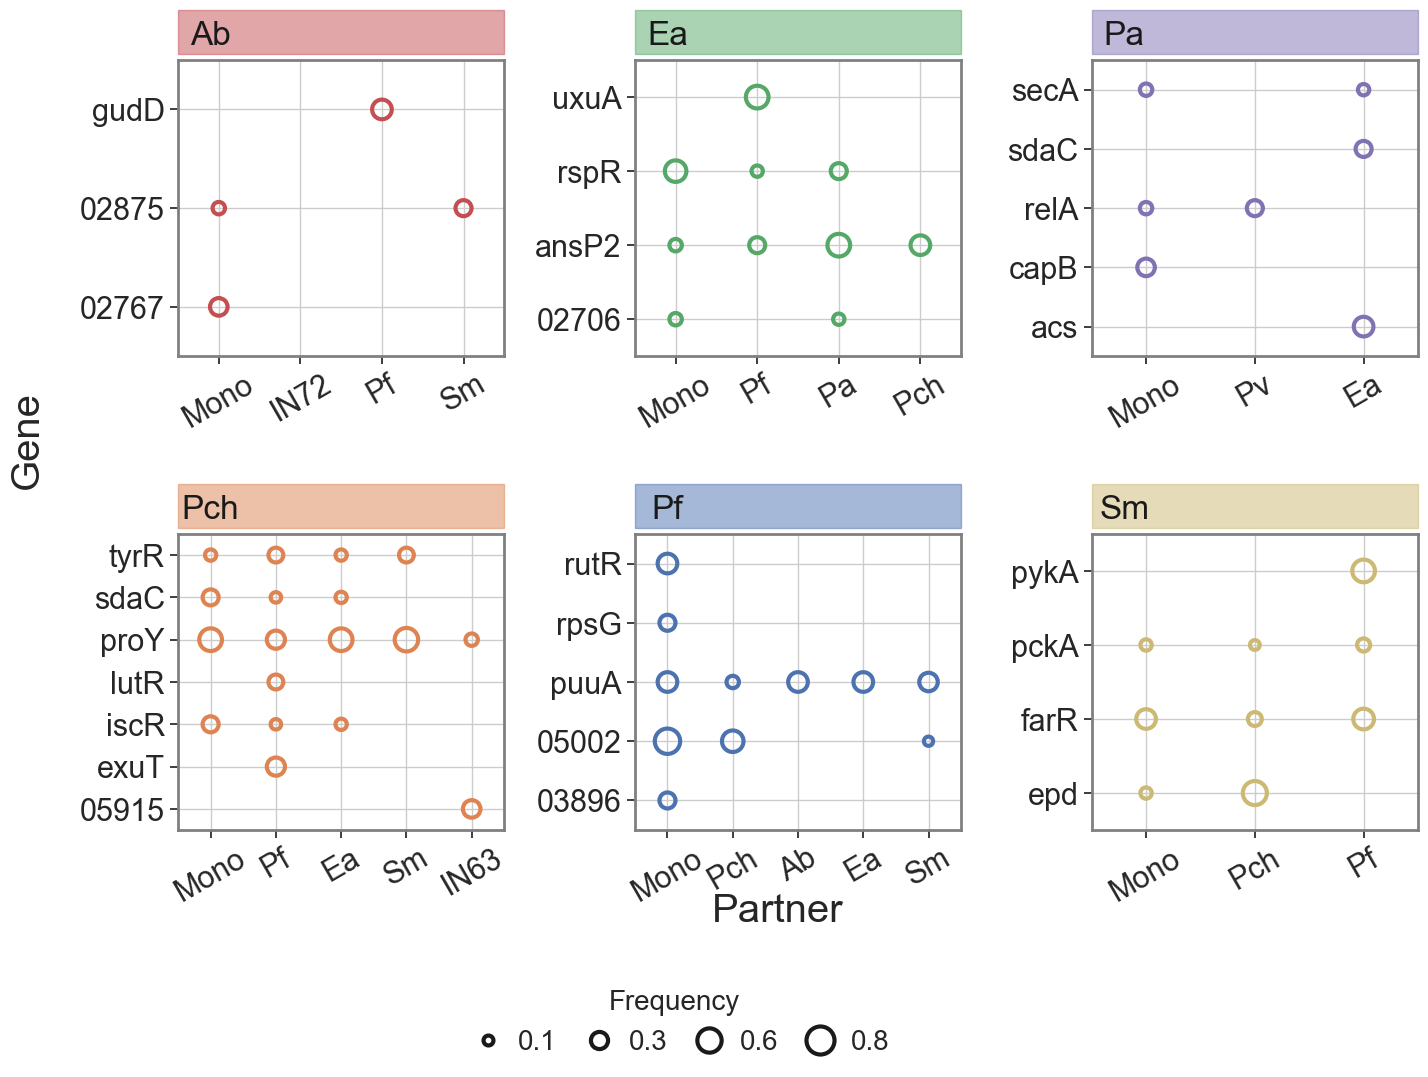

In [29]:
fig, ax = subplots(2, 3, figsize = (16, 10),
                   gridspec_kw= dict(hspace =.6, wspace = .4))

gene_eff_na = gene_eff[gene_eff['eff_gene'].isin(sig_genes.loc[:, 'Naive'].values)].reset_index()
gene_eff_na = gene_eff_na[gene_eff_na['Pre-Na']=='Naive'].reset_index()

gene_eff_na = gene_eff_na.sort_values(by = ['Species',  'ev-comm', 'eff_gene'])
gene_eff_na['sig'] = gene_eff_na.apply(lambda x:x['Species'] in sig_genes.loc[:, 'Naive'][sig_genes.loc[:, 'Naive'] == x['eff_gene']].index, axis = 1)

sorter =['Ab:Ab','Ab:Ab_IN72', 'Ab:Pf_Ab', 'Ab:Ab_Sm',
 'Pa:Pa','Pa:Pa_Pv' ,'Pa:Ea_Pa',
 'Pch:Pch', 'Pch:Pch_Pf', 'Pch:Ea_Pch', 'Pch:Pch_Sm',  'Pch:Pch_IN63', 
 'Pf:Pf', 'Pf:Pch_Pf', 'Pf:Pf_Ab', 'Pf:Ea_Pf', 'Pf:Pf_Sm', 
 'Ea:Ea', 'Ea:Ea_Pf', 'Ea:Ea_Pa', 'Ea:Ea_Pch',
 'Sm:Sm', 'Sm:Pch_Sm', 'Sm:Pf_Sm']

sp_order = ['Ab', 'Pa', 'Pch', 'Pf','Ea' ,'Sm']
sizes = dict(zip(gene_eff_na['Freq_int_treat'].unique(), gene_eff_na['Freq_int_treat'].unique()*250))
sorter = dict(zip(sorter, arange(len(sorter))))
gene_eff_na['x'] = gene_eff_na['pair'].apply(lambda x: sorter[x]) 
gene_eff_na = gene_eff_na.sort_values(by = 'x')
gene_eff_na['eff_gene_short'] = gene_eff_na['eff_gene'].apply(lambda x:cef.short_name(x, species))



gene_eff_na['F_scaled'] = gene_eff_na['Freq_int_treat']*400
gene_eff_na['eff_gene_short'] = gene_eff_na['eff_gene_short'].apply(lambda x:x.split('_')[1] if '_' in x else x)

    
for i, sp in enumerate(sort(['Ea', 'Pa', 'Pch', 'Pf', 'Sm', 'Ab'])):
    
    temp = gene_eff_na[(gene_eff_na['Pre-Na']=='Naive')&(gene_eff_na['sig'])&(gene_eff_na['Species']==sp)] 
    temp = temp.sort_values(by = 'eff_gene_short')
    sc = ax[i//3, i%3].scatter(x = temp['x'], y  = temp['eff_gene_short'], sizes = temp['F_scaled'],
                          c = 'None', edgecolors = species_dict[sp], linewidth = 3)
    sc_sz = sc.get_sizes()
    ax[i//3, i%3].set_xlim(temp['x'].min()-0.5, temp['x'].max()+0.5)
    
    tick_pos = arange(temp['x'].min(), temp['x'].max()+1)
    tick_mar =[list(sorter)[x].split(':')[1].replace(sp, '').replace('_', '') for x in tick_pos]
    
    tick_mar[0] = 'Mono'
    ax[i//3, i%3].set_xticks(tick_pos)
    ax[i//3, i%3].set_xticklabels(tick_mar, rotation = 30)
#     ax[i//3, i%3].legend()
    ax[i//3, i%3].set_ylim(-.5, len(temp['eff_gene_short'].unique())-.5)
    for spine in ax[i//3, i%3].spines.values():
        spine.set_edgecolor('grey')
        spine.set_linewidth(2)
    sns.despine(right = False, top = False, ax = ax[i//3, i%3])

    cef.add_colored_title(ax = ax[i//3, i%3], title =sp, color = species_dict[sp])

    ax[i//3, i%3].grid(axis = 'both')
fig.supylabel('Gene')
fig.supxlabel('Partner')

h, l = ax[0, 0].get_legend_handles_labels()
fracs = [0.1, 0.3, 0.6, 0.8]
legend_elements = [Line2D([0], [0], marker='o', color='w', label=frac,
                          mec='k', markersize=2*sqrt((frac*400)/pi), mew = 3) for frac in fracs]
leg = ax[1, 1].legend(handles = legend_elements,
                      loc = (-.57, -.8),
                      ncol = 4,
                      title = 'Frequency', 
                      fontsize = "small", frameon = False
                     , columnspacing=0.5, handletextpad = .1)

plt.setp(leg.get_title(), fontsize = 'small')

savefig('figures/Main/3C.png')

In [30]:
n_comms = gene_eff_na.groupby(['Species', 'eff_gene'])['ev-comm'].apply(lambda x: len(unique(x)))
(n_comms > 1).mean()

0.46875

## Figure 4

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3603895397.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  a = sum_growth[('Par', 'mean')].reset_index()
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3603895397.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  b = sum_gene[('Par', 'mean')].reset_index()
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3603895397.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  c = sum_comp[('Par', 'mean')].reset_index()
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3603895397.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = sum_int[('Par', 'mean')].reset_index()


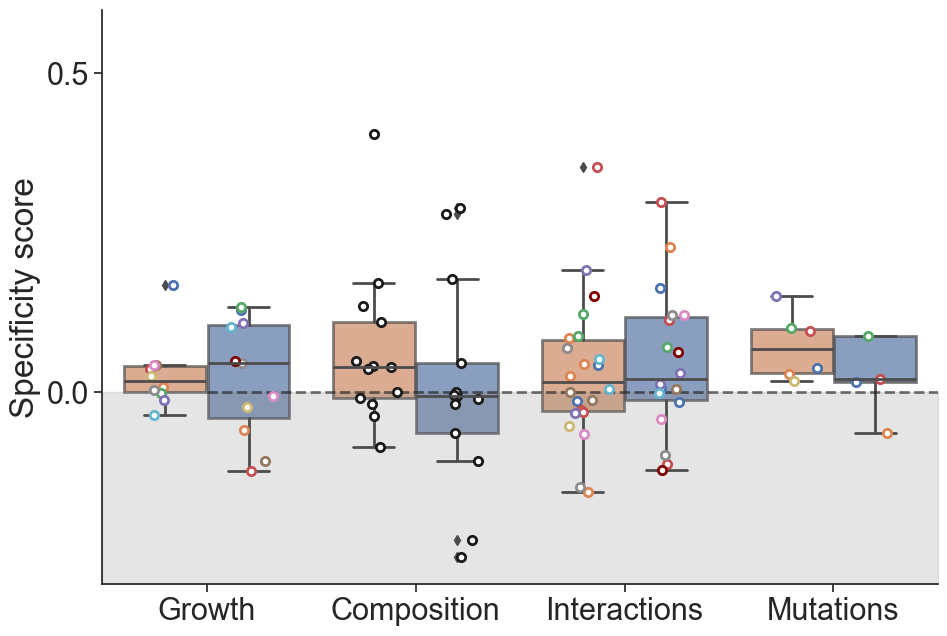

In [31]:
a = sum_growth[('Par', 'mean')].reset_index()
a['param'] = 'Growth'

b = sum_gene[('Par', 'mean')].reset_index()
b['param'] = 'Mutations'

c = sum_comp[('Par', 'mean')].reset_index()
c['param'] = 'Composition'

d = sum_int[('Par', 'mean')].reset_index()
d['param'] = 'Interactions'
# d = sum
simsum = pd.concat([a, b, c, d])




orderd_by = pd.DataFrame(simsum.groupby('param')['score'].mean().sort_values(ascending = True))
orderd_by['x'] = arange(0, len(orderd_by))
pre_na = {'Naive':-.2, 'Pre-adapted':.2}

simsum['x'] = simsum.apply(lambda x:orderd_by.loc[x['param'], 'x'] + pre_na[x['treatment']] + random.normal(0, 0.05), axis = 1)



fig, ax = subplots(1, 1, figsize=(10, 7))

for sp in species[:-1]:
    
    ax.errorbar(x = simsum.loc[simsum['species']==sp, 'x'],
                y = simsum.loc[simsum['species']==sp, 'score'], 
                  fmt = 'o', mec = species_dict[sp], mfc = 'w', mew = 2)

    
ax.errorbar(x = simsum.loc[simsum['param']=='Composition', 'x'],
            y = simsum.loc[simsum['param']=='Composition', 'score'], 
              fmt = 'o', mec = 'k', mfc = 'w', mew = 2)


sns.boxplot(data= simsum, x = 'param', y = 'score',
            hue = 'treatment',
            palette  =[sns.color_palette()[1],
                       sns.color_palette()[0]], 
           boxprops=dict(alpha=.7), ax = ax,
            order = orderd_by.index)

# ax.set_ylim(-0.05, 1.05)

ax.set_xlabel('')
ax.set_ylabel('Specificity score')

ax.legend([], frameon = False, loc = (.5, .8))
ax.set_yticks([0, .5, 1])

tight_layout()
ax.plot([0, 3.5], [0, 0], '--', color = 'k',alpha =0.6)
ax.fill_between(x = [-.5, 3.5], y1 = [0, 0], y2 = [-0.3, -0.3], color = 'grey', alpha = 0.2)
ax.set_xlim(-.5, 3.5)
ax.set_ylim(-.3, .6)

savefig('figures/Main/2B.png')

# Sup figures

## S1

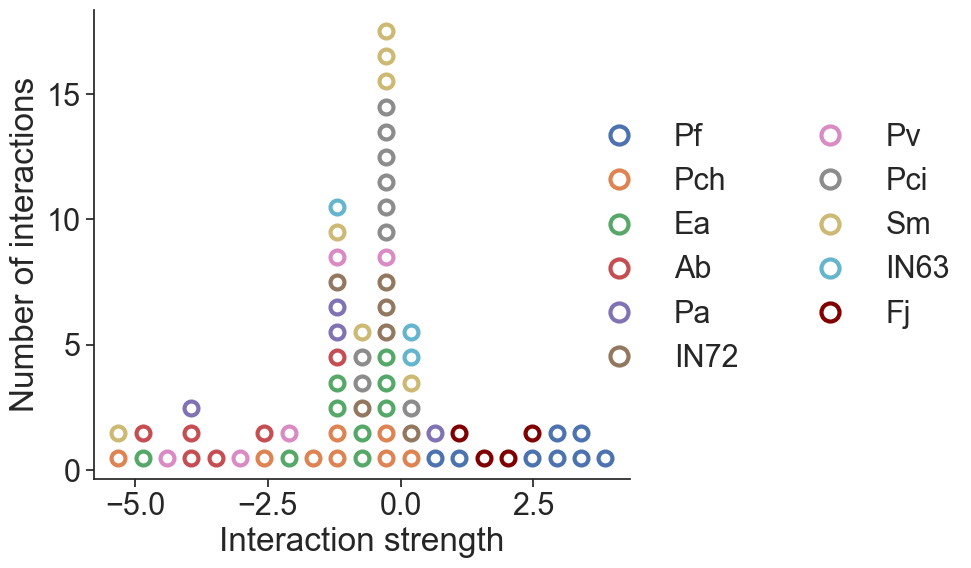

In [32]:
fig, ax = subplots(1, 1, figsize = (10, 6.2))


bins = np.histogram_bin_edges(inter_na.loc[:, species[:11], :]['mean'], bins=20)

xlabel('Interaction strength')
ylabel('Number of interactions')
inter_na['bin']  = inter_na['mean'].apply(lambda x: bins[np.digitize(x, bins)-1]) + 0.5414751112502127/2

for b in inter_na['bin'].unique():
    y = 1
    for sp in list(species_dict)[:11]:
        f_pl = inter_na.loc[:, sp, :]
        f_pl = f_pl[(f_pl['bin'] == b)]
        if len(f_pl)!=0:
            ys = arange(y, y + len(f_pl))
            xs = repeat(b, len(f_pl))
            ax.errorbar(x = xs, y = ys  - .5, 
                fmt = 'o',mec = species_dict[sp],ms = 10,mfc = 'white', mew = 3
                 )
            y = ys[-1] + 1
            
            
legend_elements = [Line2D([0], [0], marker='o', color='w', label=sp,
                          mec=species_dict[sp], markersize=13, mew = 3) for sp in species_dict][:11]
legend(handles=legend_elements, loc = (0.9, .2), frameon = False, ncol = 2)
tight_layout()

savefig('figures/Supplementary/S1.png')

## S2

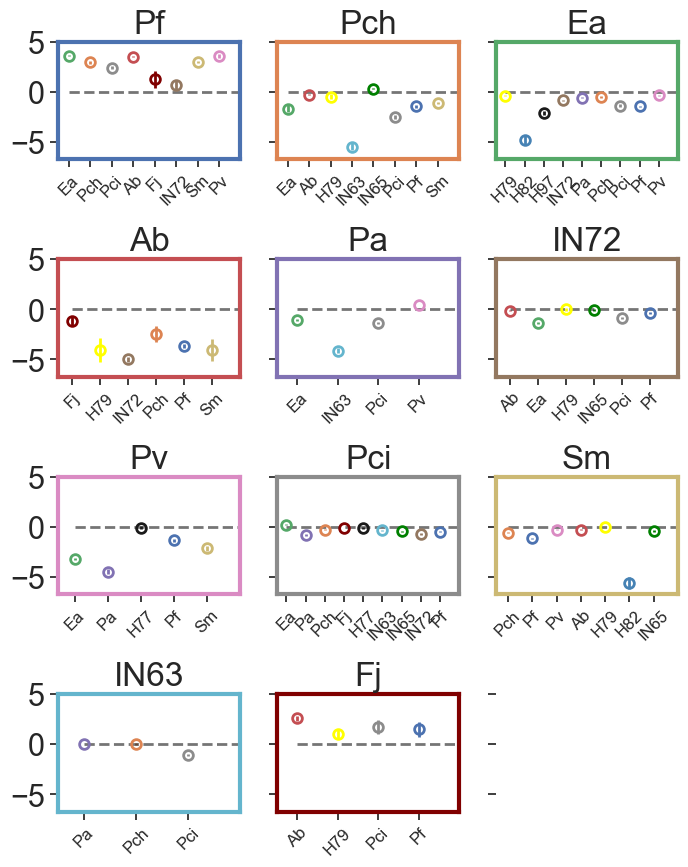

In [33]:
species_dict['H97'] = 'k'
species_dict['H77'] = 'k'

fig, ax = subplots(4, 3, figsize = (8, 10), sharey = True)
temp = inter_na.copy()
temp.index.names = ['sample', 'sp']
temp = temp.reset_index().set_index(['sp', 'sample'])
temp['partner'] = temp.apply(lambda x:x.name[1].replace(x.name[0], '').replace('_', ''), axis =1)
for i, sp in enumerate(species[:11]):
    x = 0
    for parnter in temp.loc[sp]['partner']:
        ax[i//3, i%3].errorbar(x = x, y = temp[temp['partner']==parnter].loc[sp]['mean'], 
                yerr = temp[temp['partner']==parnter].loc[sp]['sem'], fmt = 'o', 
                              color = species_dict[parnter], mfc = 'None', mew =2, ms = 7)
        x = x+1
    ax[i//3, i%3].set_xticks(arange(0, len(temp.loc[sp]['partner'])))
    ax[i//3, i%3].set_xticklabels(temp.loc[sp]['partner'].values, fontsize=12, rotation = 45)
    ax[i//3, i%3].plot([0, len(temp.loc[sp])], [0, 0], color = 'k', 
        linestyle = 'dashed', alpha = 0.6)
    ax[i//3, i%3].set_xlim(-.5, len(temp.loc[sp]))
    for spine in ax[i//3, i%3].spines.values():
        spine.set_edgecolor(species_dict[sp])
        spine.set_linewidth(3)
    sns.despine(right = False, top = False, ax = ax[i//3, i%3])
    ax[i//3, i%3].set_title(sp)
    

sns.despine(bottom=True, left = True, ax = ax[3, 2])
ax[3, 2].set_yticks([])
ax[3, 2].set_xticks([])


ax[0, 0].set_yticks([-5, 0, 5])


subplots_adjust(hspace=.85)

savefig('figures/Supplementary/S2.png')

## S3

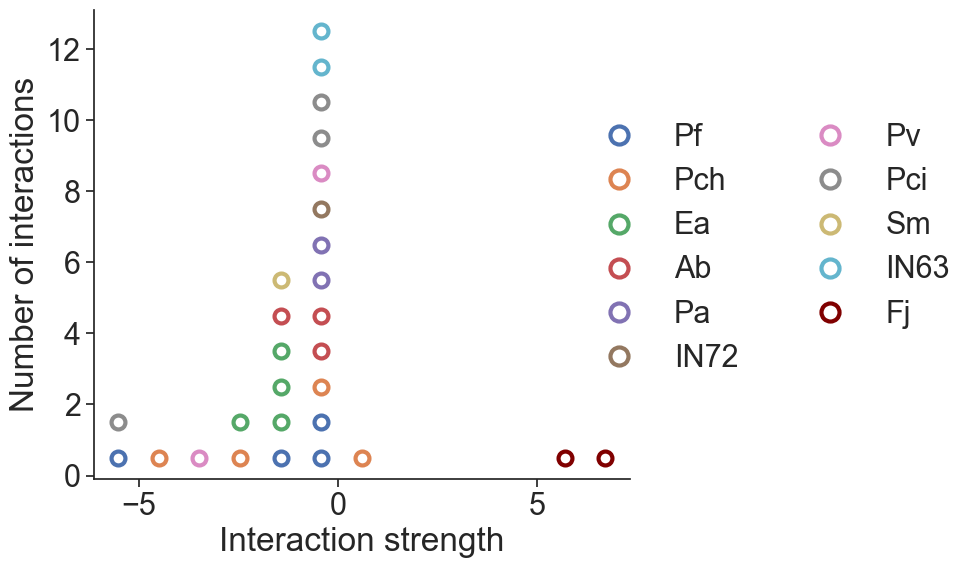

In [34]:
fig, ax = subplots(1, 1, figsize = (10, 6.2))


bins = np.histogram_bin_edges(inter_pre.loc[:, species[:11], :]['mean'], bins=12)

xlabel('Interaction strength')
ylabel('Number of interactions')
inter_pre['bin']  = inter_pre['mean'].apply(lambda x: bins[np.digitize(x, bins)-1]) + 0.5414751112502127/2

for b in inter_pre['bin'].unique():
    y = 1
    for sp in list(species_dict)[:11]:
        f_pl = inter_pre.loc[:, sp, :]
        f_pl = f_pl[(f_pl['bin'] == b)]
        if len(f_pl)!=0:
            ys = arange(y, y + len(f_pl))
            xs = repeat(b, len(f_pl))
            ax.errorbar(x = xs, y = ys  - .5, 
                fmt = 'o',mec = species_dict[sp],ms = 10,mfc = 'white', mew = 3
                 )
            y = ys[-1] + 1
            
            
legend_elements = [Line2D([0], [0], marker='o', color='w', label=sp,
                          mec=species_dict[sp], markersize=13, mew = 3) for sp in species_dict][:11]
legend(handles=legend_elements, loc = (0.9, .2), frameon = False, ncol = 2)
tight_layout()

savefig('figures/Supplementary/S3.png')

## S4

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\939918999.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pr_data = cf_tech.loc[pair, treat].unstack(0).reset_index()[('change_dir', 'mean')]
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\939918999.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pr_data = cf_tech.loc[pair, treat].unstack(0).reset_index()[('change_dir', 'mean')]
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\939918999.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pr_data = cf_tech.loc[pair, treat].unstack(0).reset_index()[('change_dir', 'mean')]
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\939918999.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pr_data = cf_tech.loc[pair, treat].unstack(0).reset_index()[('change_dir', 'mean')]
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\939918999.py:8: PerformanceWarning: indexing past lexs

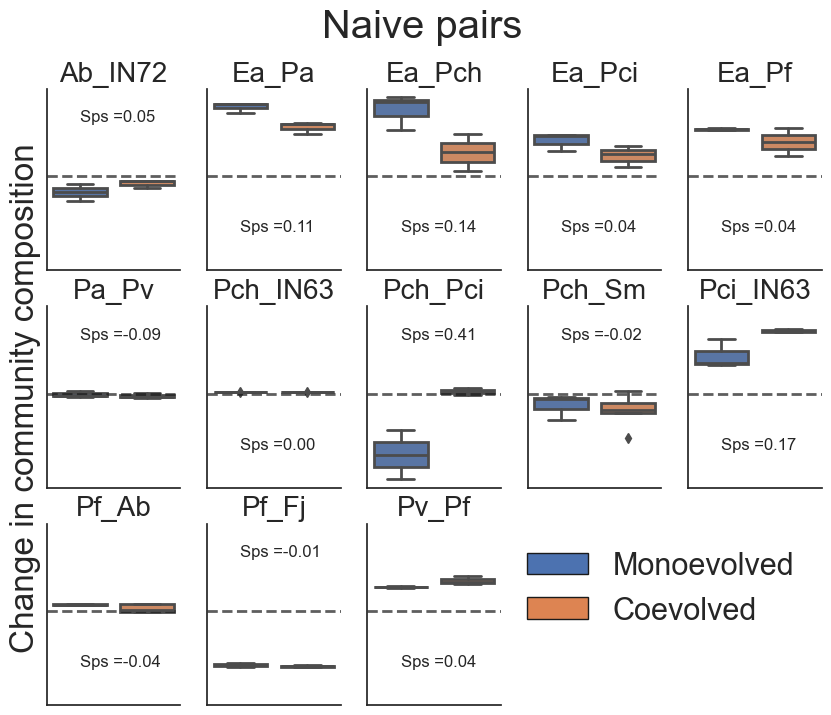

In [35]:
treat = 'Naive'
temp = sum_comp.loc[:, treat, :][('Par', 'mean', 'score')].dropna()
fig, ax = subplots(3, 5, sharex = True, sharey = True, figsize = (10, 8))


for i, pair in enumerate(temp.index):
    axs = ax[i//5, i%5]
    pr_data = cf_tech.loc[pair, treat].unstack(0).reset_index()[('change_dir', 'mean')]
    sns.boxplot(data = pr_data, 
                ax = axs, order = ['Monoevolved', 'Coevolved'])
    axs.set_ylabel('')
    axs.set_xlabel('')
    axs.set_xticklabels(["", ""])
    axs.plot([-.5, 1.5], [0, 0], color = 'k', alpha = .7, linestyle = '--')
    axs.set_xlim(-.5, 1.5)
    axs.set_title(pair, fontdict={'size':20})
    
    if pr_data.mean().mean()<0:
        y_text = 0.5
    else:
        y_text = -0.5
    axs.text(x = 0, y = y_text,
             s = 'Sps ={:.2f}'.format(temp.loc[pair]), fontdict={'size':12})
    
ax[1, 0].set_ylabel(r'Change in community composition')

suptitle('Naive pairs')
sns.despine(bottom  =True, left = True, ax = ax[2, 4])
sns.despine(bottom  =True, left = True, ax = ax[2, 3])

ax[2, 4].set_yticks([])
ax[2, 4].set_xticks([])



legend_elements = [mpatches.Patch(facecolor=sns.color_palette()[0],ec = 'k',
                         label='Monoevolved'), 
                   mpatches.Patch(facecolor=sns.color_palette()[1], ec = 'k',
                         label='Coevolved')]
ax[2, 4].legend(handles = legend_elements, frameon = False)

savefig('figures/Supplementary/S4.png')

## S5

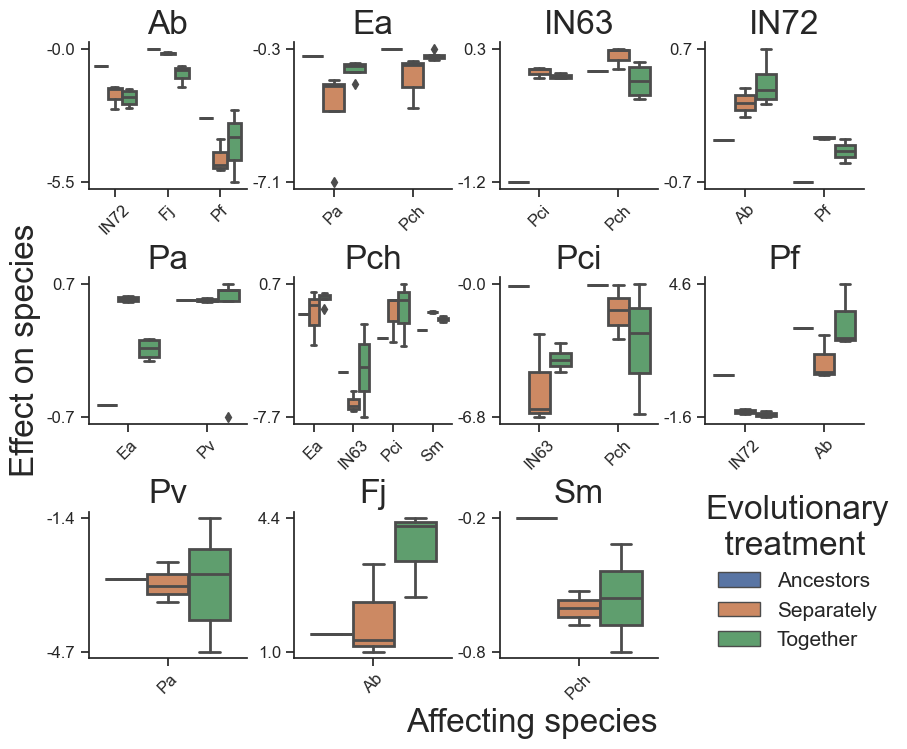

In [36]:
temp = int_tech.droplevel('exp')
temp['partner'] = temp.apply(lambda x: x.name[2].replace('_', '').replace(x.name[0], ''), axis = 1)
temp = temp[['effect', 'partner']].reset_index([2, 3, 5])
temp_anc = int_anc
temp_anc['partner'] = temp_anc.apply(lambda x: x.name[2].replace('_', '').replace(x.name[0], ''), axis = 1)
temp_anc['strain'] = 'anc'
temp_anc['m-c'] = 'anc'
temp_anc = temp_anc.reset_index().set_index(['species', 'treatment', 'strain'])
ints_temp = pd.concat([temp, temp_anc])
ints_temp = ints_temp.reset_index().set_index(['species', 'treatment', 'pair'])
rels =  ints_temp.apply(lambda x:x.name in sum_int.index, axis = 1)
ints_temp = ints_temp[rels]

fig, ax = subplots(3, 4,figsize = (10, 8))
treat = 'Naive'

for i, sp in enumerate(ints_temp.loc[:, 'Naive', :].index.get_level_values(0).unique()):
    temp = ints_temp.loc[sp, treat, :]
    
    parts = temp['partner'].unique()
    sns.boxplot(data = temp, x = 'partner', y = 'effect',
                hue = 'm-c', ax = ax[i//4, i%4], order = parts, hue_order = ['anc', 'Monoevolved','Coevolved'])
    
    ax[i//4, i%4].legend([], frameon = False)
    ax[i//4, i%4].set_ylabel('')
    ax[i//4, i%4].set_xlabel('') 
    ax[i//4, i%4].set_xticklabels(parts, rotation = 45, fontdict = {'fontsize':12})
    ax[i//4, i%4].set_yticks((temp['effect'].min(), temp['effect'].max()))
    ax[i//4, i%4].set_yticklabels([round(temp['effect'].min(), 1), round(temp['effect'].max(), 1)],
                                  fontdict = {'fontsize':12})
    
    ax[i//4, i%4].set_title(sp)
sns.despine(ax = ax[2, 3], left = True, bottom = True)
ax[2, 3].set_yticks([])
ax[2, 3].set_xticks([])

subplots_adjust(hspace = 0.6, wspace=0.3)
ax[1, 0].set_ylabel('Effect on species')
ax[2, 2].set_xlabel('Affecting species', loc = 'right')
h, l = ax[1, 0].get_legend_handles_labels()
ax[2, 3].legend(h, ['Ancestors', 'Separately', 'Together'], frameon = False,
                loc = (-.05, 0.), prop={'size': 15}, title = 'Evolutionary\n  treatment')

savefig('figures/Supplementary/S5.png')

## S6

### A

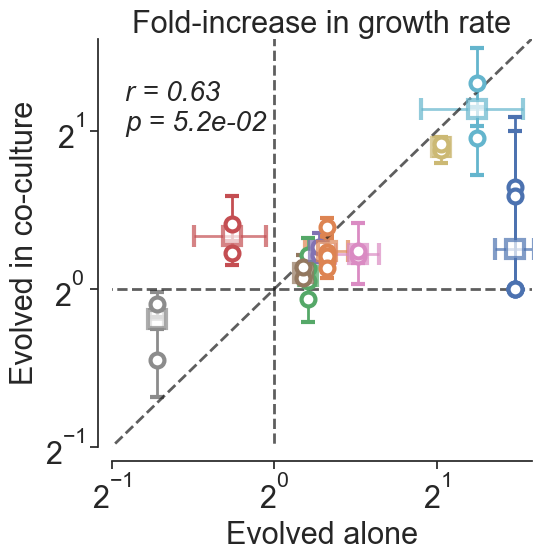

In [37]:
fig, ax = subplots(1, 1, figsize = (6, 6))

level = 'Naive'
param = 'R_norm'


cef.plot_param_bysp(gr_grand_mean, 
                    by_comm, level, param, .5, 3, .5, 3, ax, species_dict)

ax.set_title('Fold-increase in growth rate', fontsize=22, pad = 1)

ax.set_xlabel('Evolved alone', fontsize=22)
ax.set_ylabel('Evolved in co-culture', fontsize=22)


pr, pp = pearsonr(gr_grand_mean.loc[:, level, :][(param, 'mean')].unstack().dropna()['Monoevolved'], 
                  gr_grand_mean.loc[:, level, :][(param, 'mean')].unstack().dropna()['Coevolved'])


text(.53, 2,'r = {:.2f} \np = {:.1e}'.format(pr, pp),
     size = 20, style = 'italic')

subplots_adjust(left = 0.2, bottom = 0.2,
                wspace=0.1, hspace = 0.1)

savefig('figures/Supplementary/S6A.png')

### B

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3191628012.py:68: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subplots_adjust(left = 0.2, bottom = 0.2,
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3191628012.py:71: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  savefig('figures/Supplementary/S6B.png')
C:\Users\nitta\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


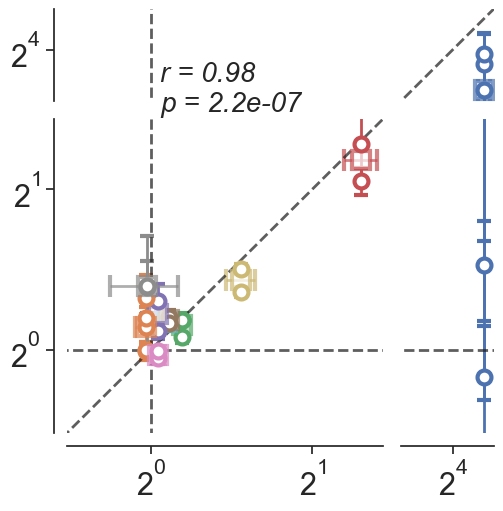

In [38]:
level = 'Naive'
param = 'K_norm'

fig = plt.figure(constrained_layout=True, figsize=(5.5, 5.5))

gs = gridspec.GridSpec(4, 4)
ax1 = fig.add_subplot(gs[1:4, 0:3])
ax2 = fig.add_subplot(gs[1:4, 3:])
ax3 = fig.add_subplot(gs[0:1, 0:3])
ax4 = fig.add_subplot(gs[0:1:, 3:])
ax_min = 0.1
for sp in by_comm.loc[:, level, :].index.get_level_values(0).unique():
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.errorbar(x =  gr_grand_mean.unstack().loc[sp,level,][(param, 'mean', 'Monoevolved')]
            ,y = gr_grand_mean.unstack().loc[sp,level][(param, 'mean', 'Coevolved')], 
            xerr = gr_grand_mean.unstack().loc[sp,level][(param, 'sem', 'Monoevolved')],
        fmt = 's', color = species_dict[sp],mfc = 'w', ms = 13, alpha = .7, capsize = 8, mew = 3)

        ax.errorbar(x =  by_comm.loc[sp,level, :][(param, 'ref')]
            ,y = by_comm.loc[sp,level,:][(param, 'mean')], 
            yerr = by_comm.loc[sp,level,:][(param, 'sem')],
            fmt = 'o',color = species_dict[sp],mfc = 'w', ms = 10, capsize = 5, mew = 3)
        
for ax in [ax1, ax2, ax3, ax4]:

    ax.plot([ax_min, 45], [ax_min, 45], color = 'k', alpha = .7, linestyle = '--')
    ax.plot([1, 1], [ax_min, 45], color = 'k', alpha = .7, linestyle = '--')
    ax.plot([ax_min, 45], [1, 1], color = 'k', alpha = .7, linestyle = '--')    
    ax.set_yscale('log', base = 2)
    ax.set_xscale('log', base = 2)

ax_min = .7    
ax1.set_ylim(ax_min, 2.7)
ax1.set_xlim(ax_min, 2.7)

ax2.set_ylim(ax_min, 2.7)
ax2.set_xlim(5, 40)

ax3.set_ylim(5, 40)
ax3.set_xlim(ax_min, 2.7)

ax4.set_ylim(5, 40)
ax4.set_xlim(5, 40)

sns.despine(offset  = 10, ax = ax1)
sns.despine(offset  = 10, ax = ax2, left = True)
sns.despine(offset  = 10, ax = ax3, right = True, bottom=True)
sns.despine(offset  = 10, ax = ax4, left = True, right = True, bottom=True)

ax2.set_yticks([])
ax3.set_xticks([])
ax4.set_yticks([])
ax4.set_xticks([])
ax2.set_xticks([2**4])
ax3.set_yticks([2**4])


# suptitle('Fold-increase in productivity', fontsize=22, y = 0.93)
# fig.supxlabel('Evolved alone', fontsize=22, y = -0.05)
# ax1.set_xlabel('Evolved alone')

pr, pp = pearsonr(gr_grand_mean.loc[:, level, :][(param, 'mean')].unstack().dropna()['Monoevolved'], 
        gr_grand_mean.loc[:, level, :][(param, 'mean')].unstack().dropna()['Coevolved'])

ax3.text(1.04, 4,'r = {:.2f} \np = {:.1e}'.format(pr, pp),
     size = 20, style = 'italic')
subplots_adjust(left = 0.2, bottom = 0.2, 
                wspace=0.1, hspace = 0.1)

savefig('figures/Supplementary/S6B.png')

### C

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\1301840012.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  tight_layout()


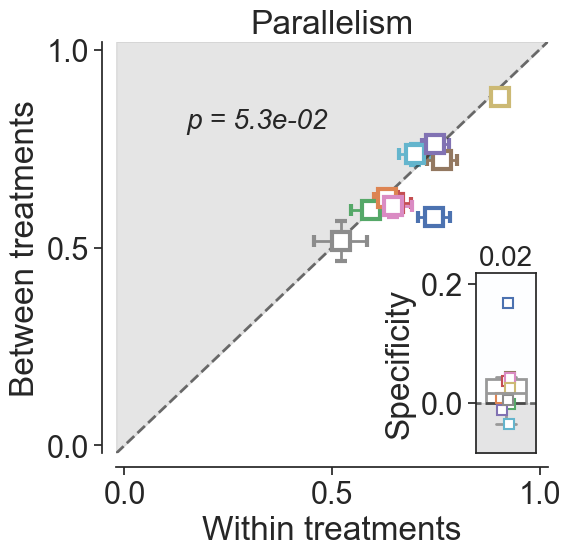

In [39]:
fig, ax = subplots(1, 1, figsize = (6, 6))

temp = sum_growth.loc[:, 'Naive', :]
# sum_growth['p-corr'] = sum_growth[('p-corr', 'Unnamed: 18_level_1', 'Unnamed: 18_level_2')]
cef.plot_par(temp, 'Par',('p-corr', 'Unnamed: 18_level_1', 'Unnamed: 18_level_2'), species_dict, fmt = 's', ax = ax)
xticks([0, .5, 1]);
yticks([0, .5, 1]);
title('Parallelism')

wp = wilcoxon(temp[('Par', 'mean', 'within')],
        temp[('Par', 'mean', 'between')], 
        alternative='greater')[1]

text(.15, .8,'p = {:.1e}'.format(wp),
     size = 20, style = 'italic')

cef.pec_score_inset(temp, 'Par',('p-corr', 'Unnamed: 18_level_1', 'Unnamed: 18_level_2'),
                    species_dict, fig  =fig, fmt = 's', bottom  = 0.2, left = 0.8)

tight_layout()
subplots_adjust(left = 0.2, bottom = 0.2, wspace=0.1, hspace = 0.1)

savefig('figures/Supplementary/S6C.png')

## S7

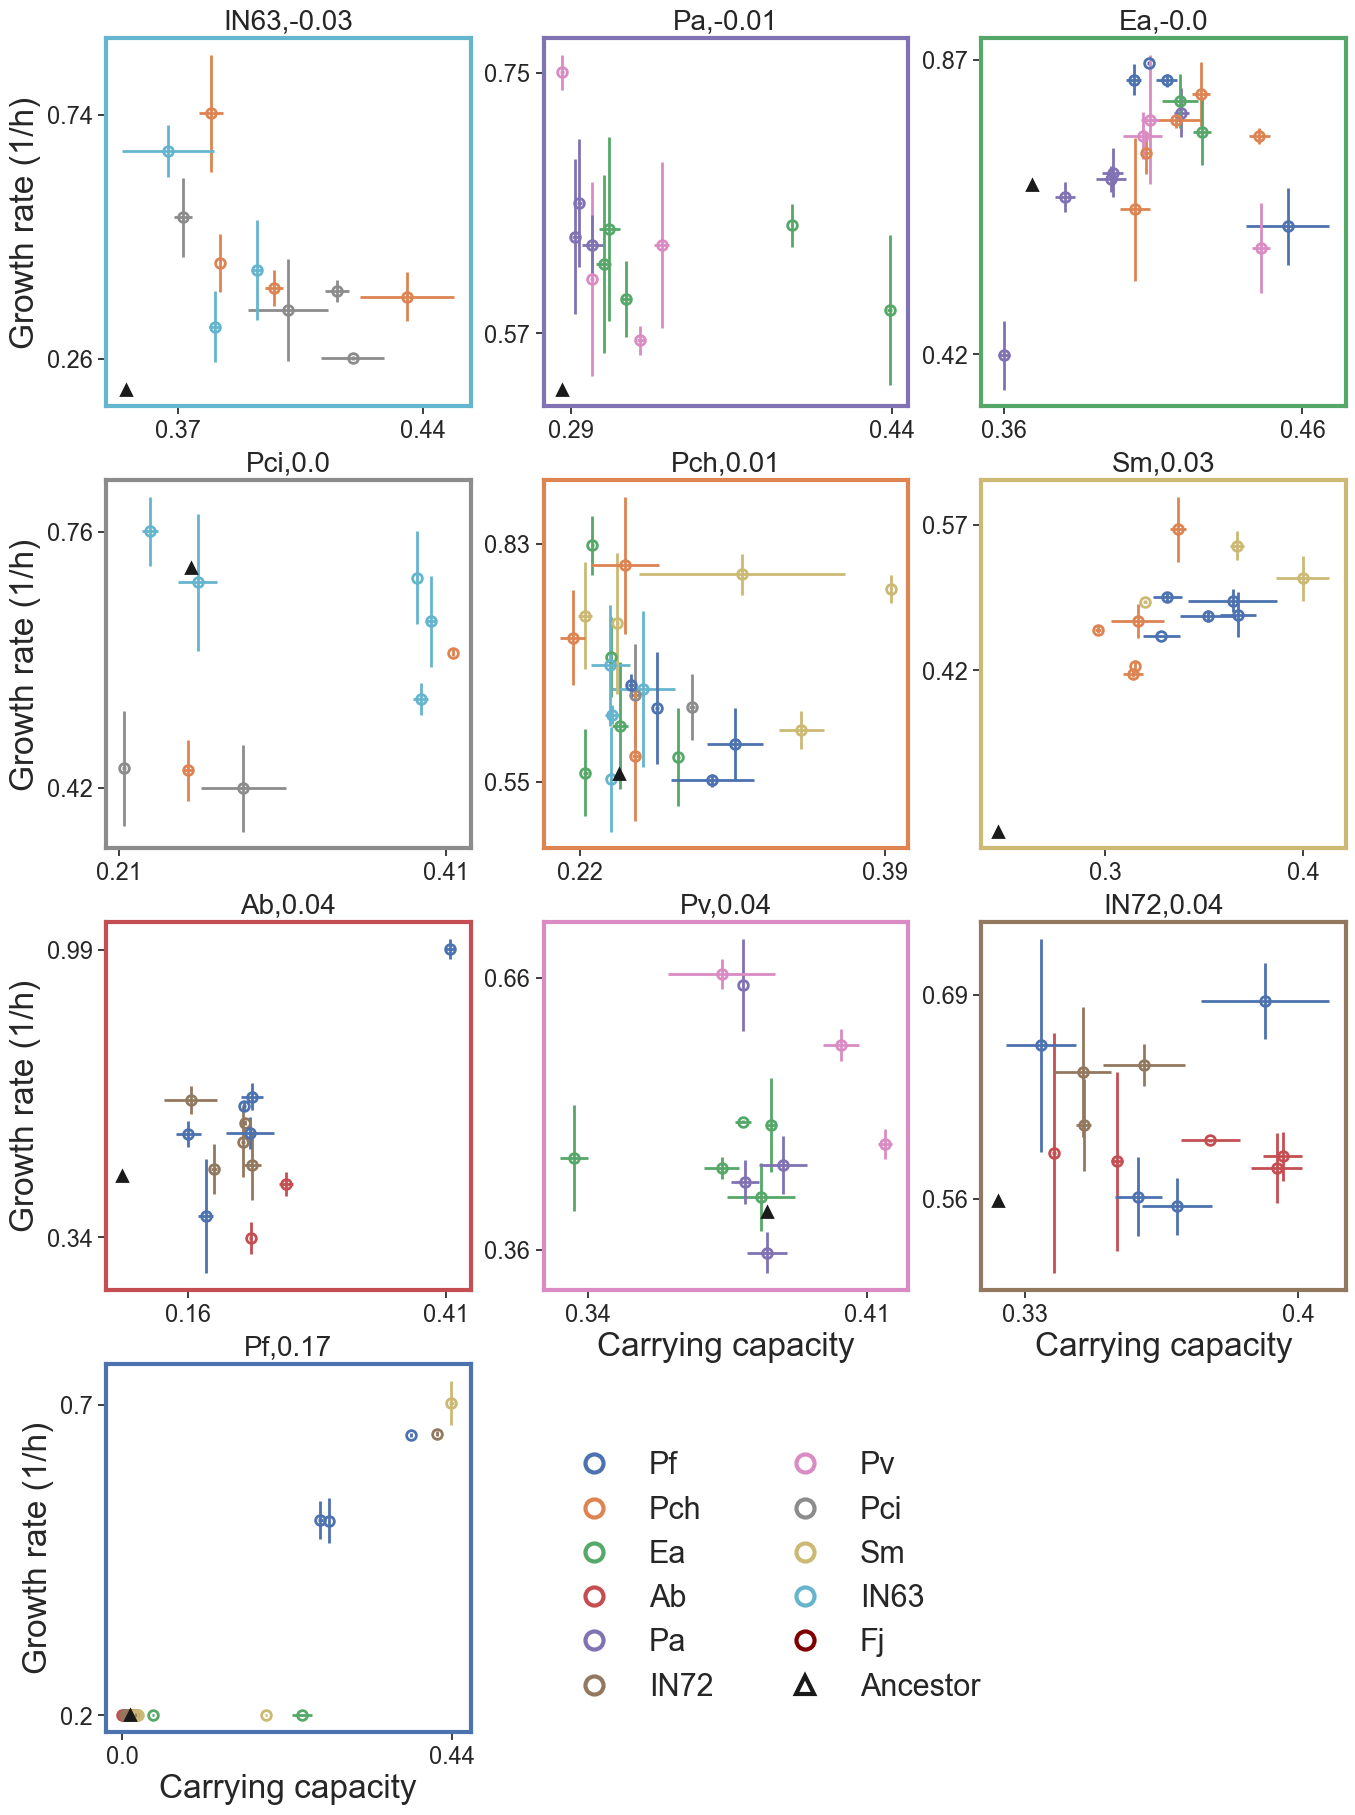

In [40]:
fig, ax = subplots(4, 3, 
                   figsize = (16, 22))

temp = sum_growth.loc[:, 'Naive', :]['Par']
temp = temp.sort_values(by = ('mean', 'score'))



for i, sp in enumerate(temp.index):
    
    cef.plot_sp(growth_technical, growth_technical_sem, 
               anc_uni, sp, treat,species_dict,
                ax = ax[i//3, i%3],
                score = round(temp.loc[sp][('mean', 'score')], 2),
                leg = False)
    
    ax[i//3, i%3].set_ylabel('')
    ax[i//3, i%3].set_xlabel('')
    if i%3 == 0:
        ax[i//3, i%3].set_ylabel('Growth rate (1/h)')
    
ax[3, 0].set_xlabel('Carrying capacity')       
ax[2, 1].set_xlabel('Carrying capacity')   
ax[2, 2].set_xlabel('Carrying capacity')   


sns.despine(ax = ax[3, 1], bottom = True, left = True)
ax[3, 1].set_xticks([])
ax[3, 1].set_yticks([])
sns.despine(ax = ax[3, 2], bottom = True, left = True)
ax[3, 2].set_xticks([])
ax[3, 2].set_yticks([])


legend_elements = [Line2D([0], [0], marker='o', color='w', label=sp,
                          mec=species_dict[sp], markersize=13, mew = 3) for sp in species_dict][:11]
legend_elements.append(Line2D([0], [0], marker='^',
                              color='w', label='Ancestor',
                          mec='k', markersize=13, mew = 3))


ax[3, 1].legend(handles=legend_elements, loc = (.02, .05), frameon = False, ncol = 2)

savefig('figures/Supplementary/S7.png')

## S8

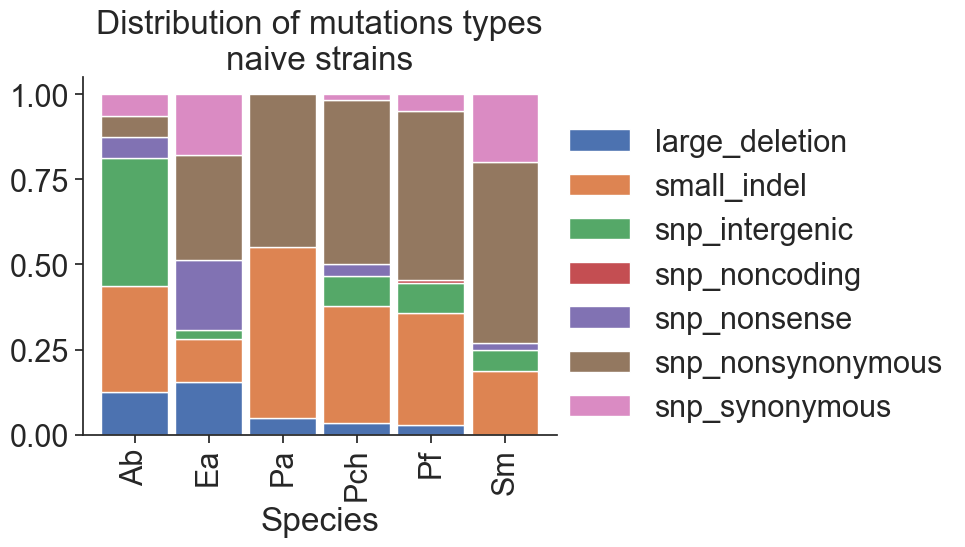

In [41]:
all_mut = pd.read_excel('Data/Mutations/num_mut.xlsx', index_col=0)

fig, ax = subplots(1, 1, figsize = (10, 6))
temp = all_mut[all_mut['Pre-Na']=='Naive']
temp = temp.groupby(['Species', 'mutation_category'])['mutation_id'].count()/temp.groupby(['Species'])['mutation_id'].count()
temp.unstack().plot.bar(stacked = True, ax = ax, width=0.9)
legend(loc = (1, 0), frameon = False)
title('Distribution of mutations types\nnaive strains')

tight_layout()

savefig('figures/Supplementary/S8.png')

## S9

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\2737847168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['p-corr'] = multipletests(temp[('Par', 'permutations', 'p-value')].astype(float64))[1]


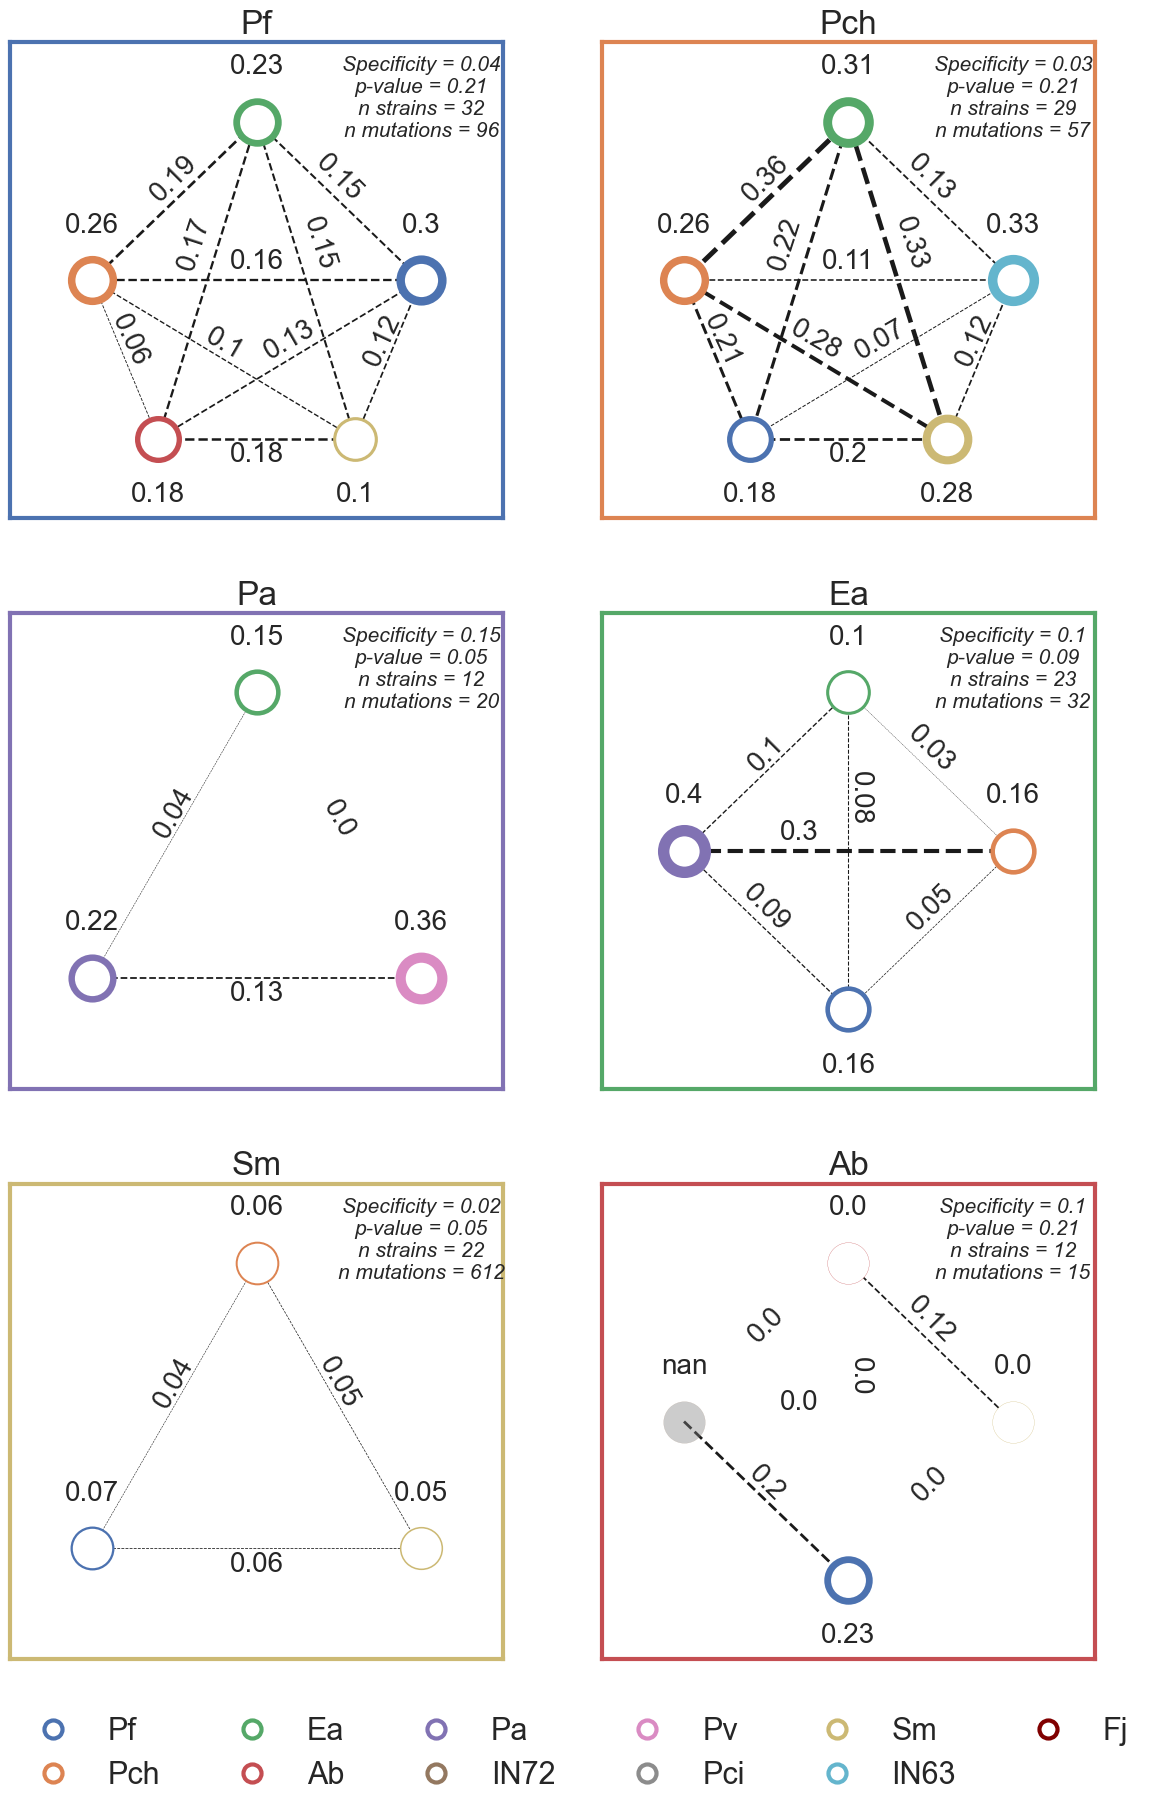

In [42]:
from itertools import combinations_with_replacement
treat = 'Naive'

temp = sum_gene.loc[:, 'Naive', :]
temp['p-corr'] = multipletests(temp[('Par', 'permutations', 'p-value')].astype(float64))[1]

fig, ax = subplots(3, 2, figsize = (14, 21))


dot_dict = {3:[[0, -1, 1], [1, -.8, -.8]],
            4:[[0, -1, 1, 0], [1, 0, 0, -1]],
            5:[[0, -1, 1, -.6, .6], [1, 0, 0, -1, -1]]}

ang_dict = {3:[60, -60, 0],
            4:[45, -45,
               -90, 0,
               -45, 45], 
            5:[45, -45,
               72, -72, 
               0, -65,
               -30,30,
               65, 0]}

tloc_dict = {3:[(-0.5, 0.09), (0.5, 0.09),
                (0.0, -0.95)], 
            4: [(-0.5, 0.5), (0.5, 0.5),
                (0.07, .2), (-0.3, 0.07),
                (-0.5, -0.5), (0.5, -0.5)], 
            5: [(-0.5, 0.5), (0.5, 0.5),
                (-0.38, 0.08),(0.38, 0.08),
                (0.0, 0.07), (-0.77, -0.53),
                (-0.2, -0.5), (0.2, -0.5),
                (0.77, -0.53), (0.0, -1.15)]}

for i, sp in enumerate(['Pf', 'Pch', 'Pa','Ea', 'Sm', 'Ab']):
    
    temp_ind = mut_table[(mut_table['Species']==sp)&(mut_table['Pre-Na']==treat)]
    temp_ind = temp_ind.groupby(['ev-comm', 'strain']).mean()
    ind_agg = temp_ind.groupby('ev-comm').mean()
    temp_mat = pd.DataFrame(columns=ind_agg.index, index = ind_agg.index) # distance matrix
    for comp in list(combinations_with_replacement(ind_agg.index, 2)):
        a =  dist_mat.loc[sp, treat,comp[0]][sp, treat,comp[1]].values.flatten()
        temp_mat.loc[comp[0], comp[1]] = nanmean(list(a))
    mat = temp_mat
    inds = list(mat.index)


    cef.plot_pairwise_dists(ax[i//2, i%2], mat, dot_dict, species_dict,
                            sp, ang_dict, tloc_dict)
    spec = round(temp.loc[sp][('Par', 'mean', 'score')], 2)
    pv = round(temp.loc[sp]['p-corr'].values[0], 2)
    n_strains = len(temp_ind )
    n_mutations = len(mut_table[mut_table['strain'].isin(temp_ind.index.get_level_values(1))])
    ax[i//2, i%2].text(s = 'Specificity = ' + str(spec)+'\np-value = '+ str(pv) +'\nn strains = '+str(n_strains) + '\nn mutations = ' + str(n_mutations)
                       , x = 1, y = .9,
                       fontdict = {'fontsize':15, 'ha':'center', 'style':'italic'})
    
legend_elements = [Line2D([0], [0], marker='o', color='w', label=sp,
                      mec=species_dict[sp], markersize=13, mew = 3) for sp in species_dict][:11]
ax[2, 0].legend(handles = legend_elements,
                loc = (0, -.3), ncol = 6, frameon = False)


savefig('figures/Supplementary/S9.png')

## S10

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3387386720.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['pair'] = temp.apply(lambda x:x['Species'] + ':' + x['ev-comm'], axis = 1)
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3387386720.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['x'] = temp['pair'].apply(lambda x: sorter[x])
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3387386720.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

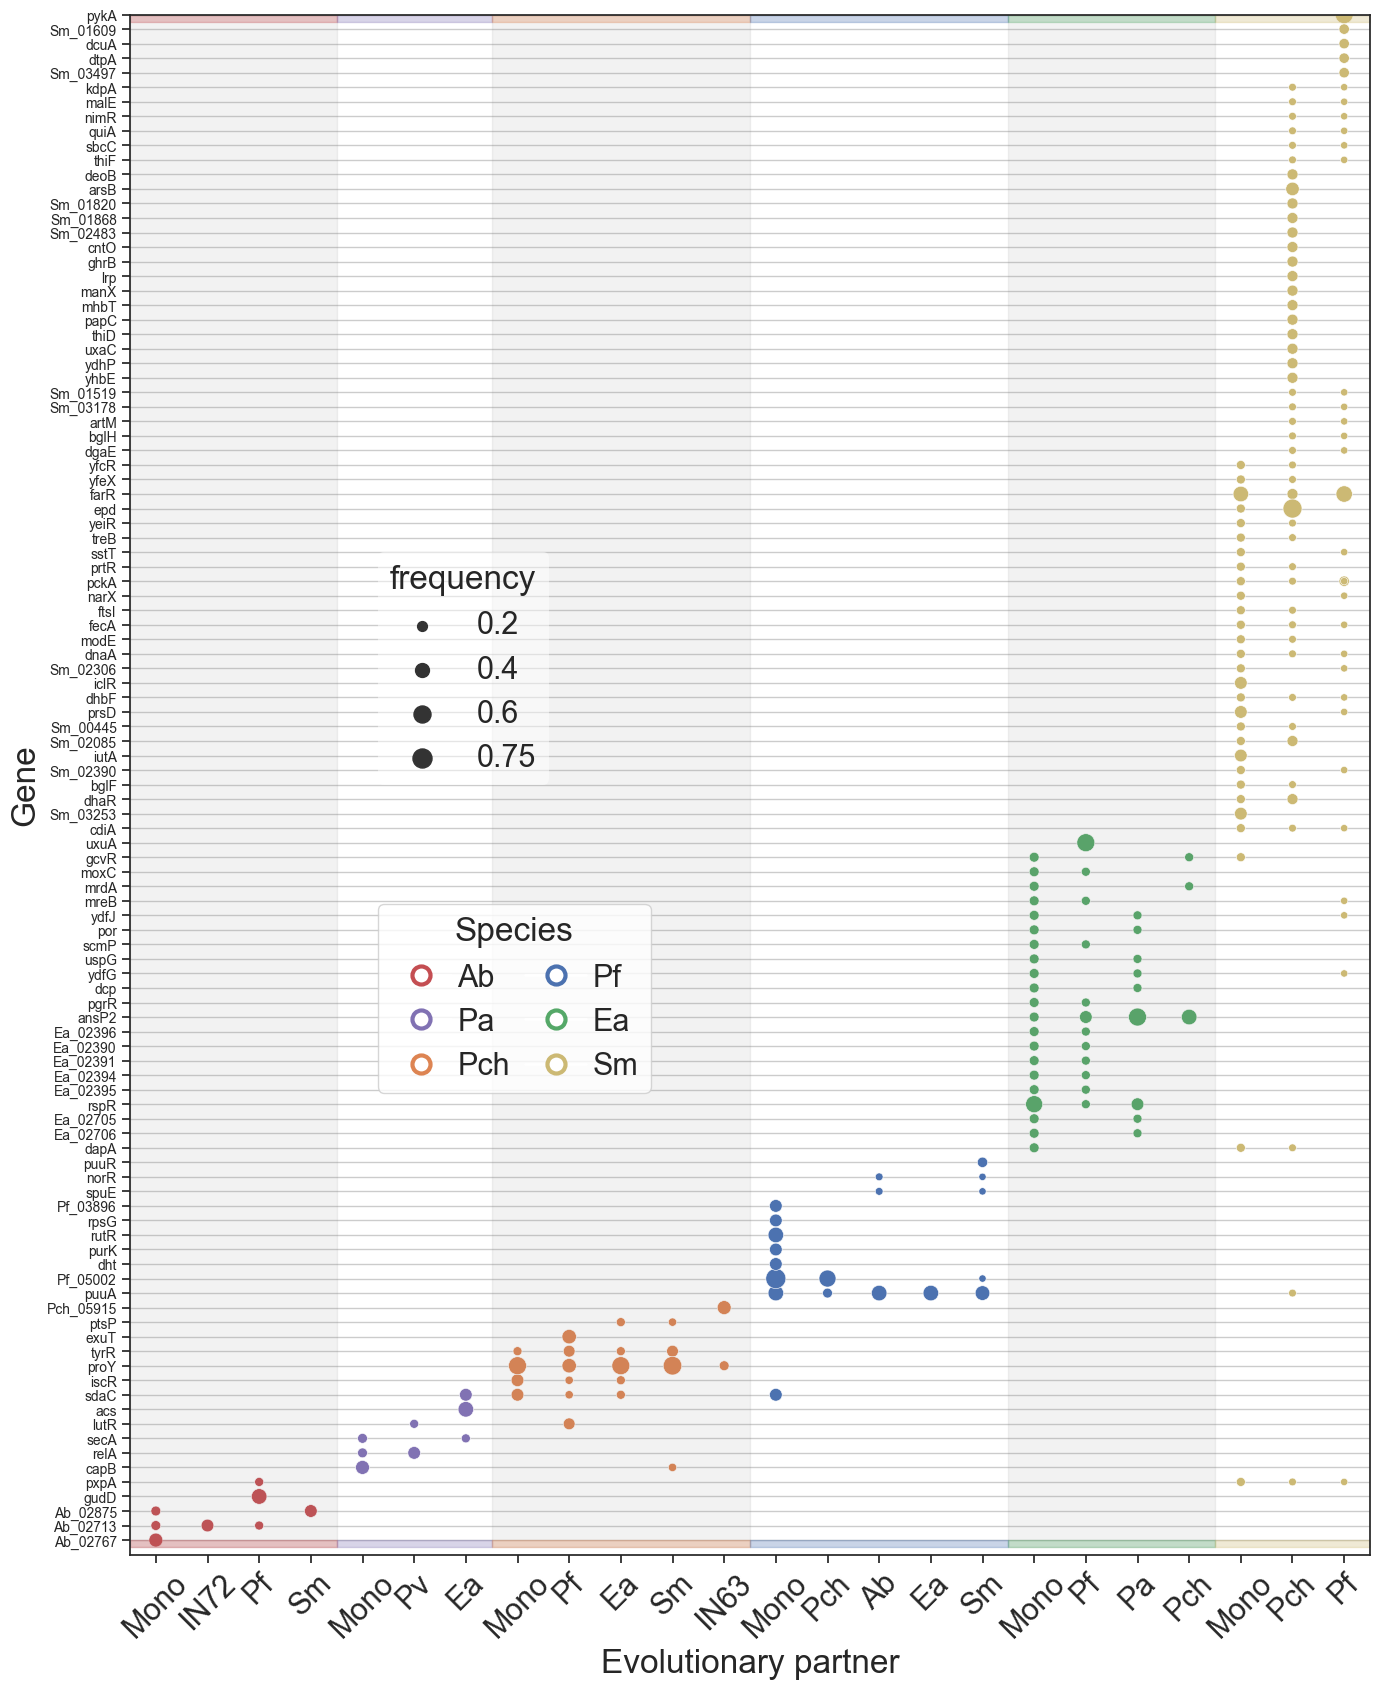

In [43]:
lvl = 'Naive'


more_then_one = cont_table[cont_table['N_occ']>1].loc[:, 'Naive',:]['eff_gene'].values
temp = mut_g[(mut_g['eff_gene'].isin(more_then_one))&(mut_g['Pre-Na']==lvl)]

sorter =['Ab:Ab','Ab:Ab_IN72', 'Ab:Pf_Ab', 'Ab:Ab_Sm',
 'Pa:Pa','Pa:Pa_Pv' ,'Pa:Ea_Pa',
 'Pch:Pch', 'Pch:Pch_Pf', 'Pch:Ea_Pch', 'Pch:Pch_Sm',  'Pch:Pch_IN63', 
 'Pf:Pf', 'Pf:Pch_Pf', 'Pf:Pf_Ab', 'Pf:Ea_Pf', 'Pf:Pf_Sm', 
 'Ea:Ea', 'Ea:Ea_Pf', 'Ea:Ea_Pa', 'Ea:Ea_Pch',
 'Sm:Sm', 'Sm:Pch_Sm', 'Sm:Pf_Sm']

temp['pair'] = temp.apply(lambda x:x['Species'] + ':' + x['ev-comm'], axis = 1)

sp_order = ['Ab', 'Pa', 'Pch', 'Pf','Ea' ,'Sm']
sizes = dict(zip(temp['Freq_int_treat'].unique(), temp['Freq_int_treat'].unique()*250))
sorter = dict(zip(sorter, arange(len(sorter))))
temp['x'] = temp['pair'].apply(lambda x: sorter[x]) 
temp = temp.sort_values(by = 'x')
temp['eff_gene_short'] = temp['eff_gene'].apply(lambda x:cef.short_name(x, species))


def_cols = [species_dict[sp] for sp in sp_order]


fig, ax = subplots(1, 1, figsize = (16, 20), sharey = True)

sns.scatterplot(data = temp[temp['Pre-Na']==lvl] ,x='x',
                y='eff_gene_short', size='Freq_int_treat',
                sizes=sizes, hue='Species', palette = def_cols)


grid(axis = 'y')
ylabel('')
fill_betweenx(y = [-.5, 105], x1 = -.5,x2 = 3.5, color = 'grey', alpha = .1)
fill_betweenx(y = [-.5, 105], x1 = 6.5,x2 = 11.5, color = 'grey', alpha = .1)
fill_betweenx(y = [-.5, 105], x1 = 16.5,x2 = 20.5, color = 'grey', alpha = .1)

for sp in sp_order:
    start, end = min([sorter[k] for k in sorter if k.startswith(sp)]), max([sorter[k] for k in sorter if k.startswith(sp)])
    fill_betweenx(y = [0, -0.5], x1 = start-.5,x2 = end+.5, color = species_dict[sp], alpha = .3)
    fill_betweenx(y = [104.5,105], x1 = start-.5,x2 = end+.5, color = species_dict[sp], alpha = .3)
    
    

x_lbls = []
for p in sorter:
    sp = p.split(':')[0]
    if sp == p.split(':')[1]:
        x_lbls.append('Mono')
    else:
        par = array(p.split(':')[1].split('_'))
        x_lbls.append(par[par!=sp][0])

ylim(-1, 105)
xlim(-.5, 23.5)
ax.set_yticklabels(temp['eff_gene_short'].unique(), fontdict = {'size':10})
ylabel('Gene')
xlabel('Evolutionary partner')
xticks(ticks  = arange(len(x_lbls)),labels = x_lbls, rotation = 45);

sns.despine(top = False, right = False)
# legend([],loc = (1, 0), frameon = False)
sps_sort = sort(list(species_dict.keys())[:11])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=sp,
                          mec=species_dict[sp], markersize=13, mew = 3) for sp in ['Ab', 'Pa', 'Pch', 'Pf', 'Ea', 'Sm']]

leg_1 = legend(handles=legend_elements, loc = (0.2, 0.3),  ncol = 2,
       title = 'Species', handletextpad = .2, columnspacing=0.5)

gca().add_artist(leg_1)

h, l = ax.get_legend_handles_labels()
nl = ['0.2','0.4', '0.6', '0.75']
nh = [h[l.index(fr)] for fr in nl]
legend(nh, nl,loc = (.2, 0.5), edgecolor = 'none', title = 'frequency', framealpha = 0.5)

savefig('figures/Supplementary/S10.png')

In [44]:
n_comms = temp.groupby(['Species', 'eff_gene'])['ev-comm'].apply(lambda x: len(unique(x)))
(n_comms > 1).mean()

0.568

## S11

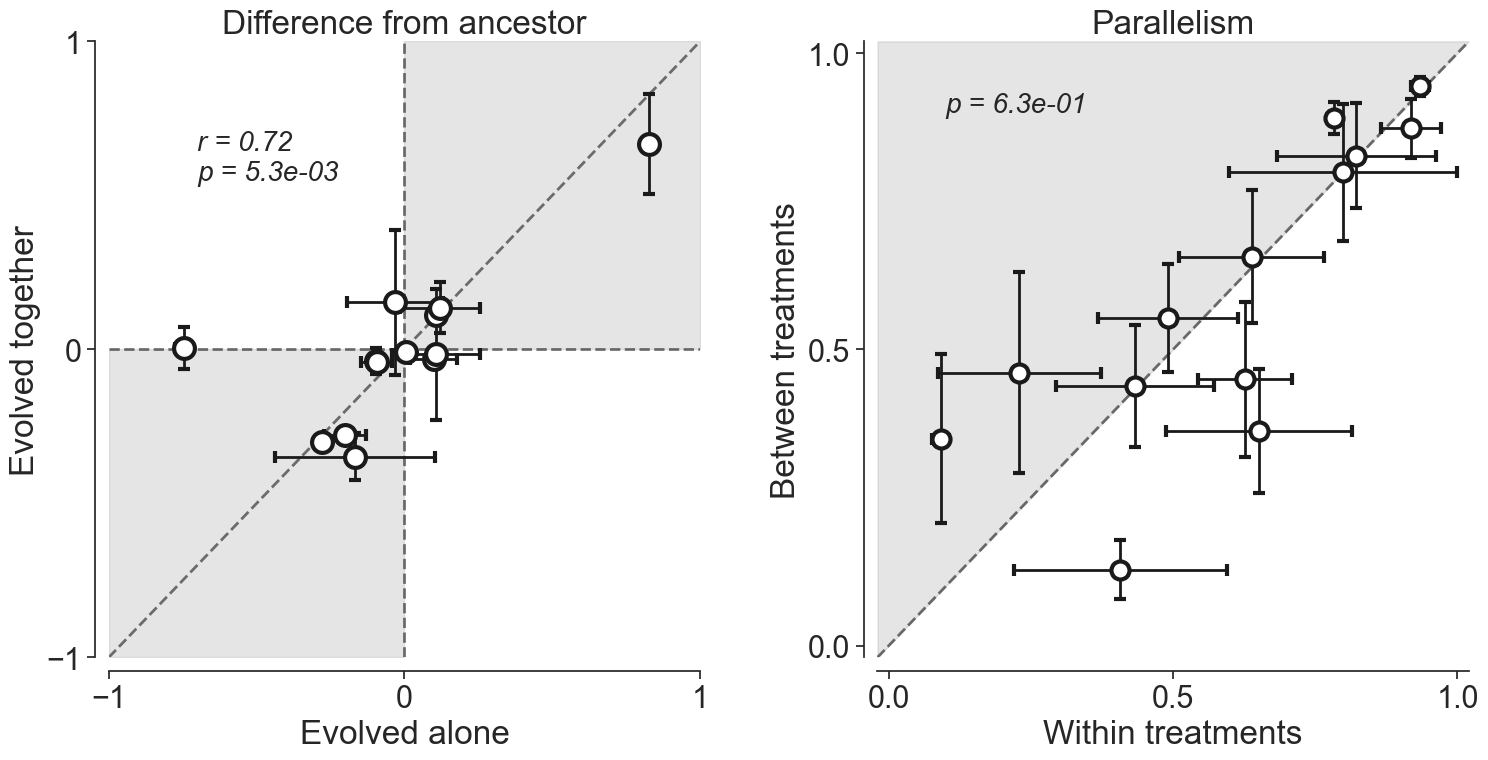

In [45]:
fig, ax = subplots(1, 2, figsize = (17, 8))
subplots_adjust(wspace = .3, left = 0.1)



ax[0].errorbar(y = cf_gr[('mean', 'Pre-co')],
               x = cf_gr[('mean', 'Pre-m')], 
               yerr = cf_gr[('sem', 'Pre-co')], 
               xerr = cf_gr[('sem', 'Pre-m')], 
         fmt = 'o', mfc = 'white' ,ms = 15, color = 'k', mew = 3, capsize = 4)


ax[0].fill_between([-1, 0], y1=0, y2 = -1, color = 'grey', alpha = .2)
ax[0].fill_between([0, 1], y1=1, y2 = .0, color = 'grey', alpha = .2)


ax[0].set_title('Difference from ancestor')

ax[0].set_xlabel('Evolved alone')
ax[0].set_ylabel('Evolved together')

ax[0].plot([-1, 1], [-1, 1], '--', color = 'k',alpha =0.6)
ax[0].plot([0, 0], [-1, 1], '--', color = 'k',alpha =0.6)
ax[0].plot([-1, 1], [0, .0], '--', color = 'k',alpha =0.6)

ax[0].set_yticks([-1, 0, 1])
ax[0].set_xticks([-1, 0, 1])
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)

x, y = cf_gr['mean'].dropna()['Pre-m'], cf_gr['mean'].dropna()['Pre-co']
pr, pp = pearsonr(x, y)


ax[0].text(-0.7, 0.55,'r = {:.2f} \np = {:.1e}'.format(pr, pp), size = 20, style = 'italic')


sns.despine(offset = 10, ax = ax[0])

temp = sum_comp.loc[:, 'Pre-adapted', :]

cef.plot_par(temp, 'Par',('Distance', 'permutations', 'p-value'), species_dict, paired=True, ax = ax[1])
xticks([0, .5, 1]);
yticks([0, .5, 1]);
title('Parallelism')
# cef.pec_score_inset(temp, 'Par',('Distance', 'permutations', 'p-value'), 
#                 species_dict,  paired=True, 
#                 fig  = fig, bottom = 0.16, left = 0.83, width = 0.05)

wp = wilcoxon(temp[('Par', 'mean', 'score')].dropna(), alternative='greater')[1]
ax[1].text(0.1, 0.9,'p = {:.1e}'.format(wp), size = 20, style = 'italic')


savefig('figures/Supplementary/S11.png')

## S12

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\1685467328.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pr_data = cf_tech.loc[pair, treat].unstack(0).reset_index()[('change_dir', 'mean')]
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\1685467328.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pr_data = cf_tech.loc[pair, treat].unstack(0).reset_index()[('change_dir', 'mean')]
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\1685467328.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pr_data = cf_tech.loc[pair, treat].unstack(0).reset_index()[('change_dir', 'mean')]
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\1685467328.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pr_data = cf_tech.loc[pair, treat].unstack(0).reset_index()[('change_dir', 'mean')]
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\1685467328.py:8: PerformanceWarning: indexing past

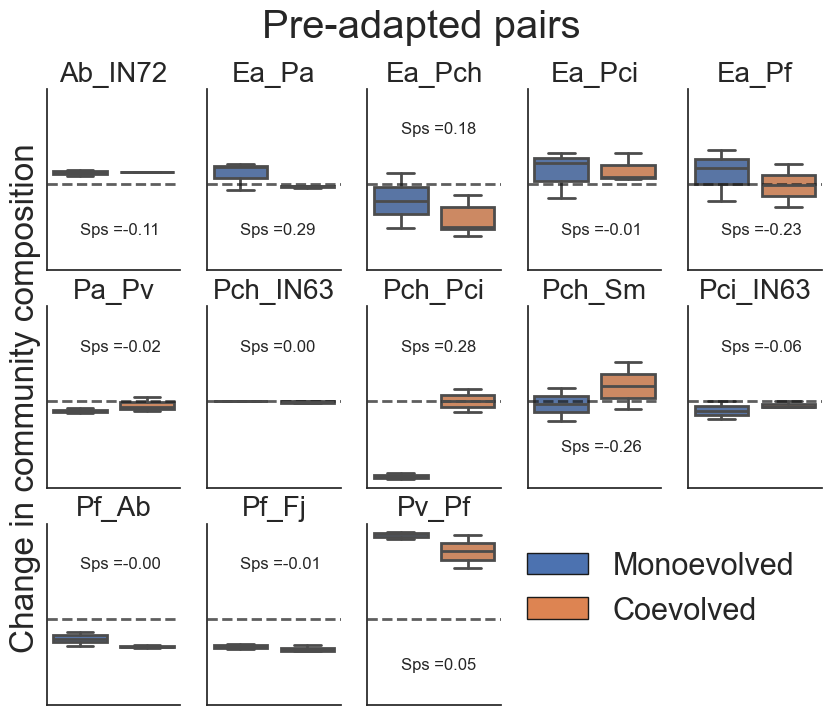

In [46]:
treat = 'Pre-adapted'
temp = sum_comp.loc[:, treat, :][('Par', 'mean', 'score')].dropna()
fig, ax = subplots(3, 5, sharex = True, sharey = True, figsize = (10, 8))


for i, pair in enumerate(temp.index):
    axs = ax[i//5, i%5]
    pr_data = cf_tech.loc[pair, treat].unstack(0).reset_index()[('change_dir', 'mean')]
    sns.boxplot(data = pr_data, 
                ax = axs, order = ['Monoevolved', 'Coevolved'])
    axs.set_ylabel('')
    axs.set_xlabel('')
    axs.set_xticklabels(["", ""])
    axs.plot([-.5, 1.5], [0, 0], color = 'k', alpha = .7, linestyle = '--')
    axs.set_xlim(-.5, 1.5)
    axs.set_title(pair, fontdict={'size':20})
    
    if pr_data.mean().mean()<0:
        y_text = 0.5
    else:
        y_text = -0.5
    axs.text(x = 0, y = y_text,
             s = 'Sps ={:.2f}'.format(temp.loc[pair]), fontdict={'size':12})
    
ax[1, 0].set_ylabel(r'Change in community composition')

suptitle('Pre-adapted pairs')
sns.despine(bottom  =True, left = True, ax = ax[2, 4])
sns.despine(bottom  =True, left = True, ax = ax[2, 3])

ax[2, 4].set_yticks([])
ax[2, 4].set_xticks([])



legend_elements = [mpatches.Patch(facecolor=sns.color_palette()[0],ec = 'k',
                         label='Monoevolved'), 
                   mpatches.Patch(facecolor=sns.color_palette()[1], ec = 'k',
                         label='Coevolved')]
ax[2, 4].legend(handles = legend_elements, frameon = False)

savefig('figures/Supplementary/S12.png')

## S13

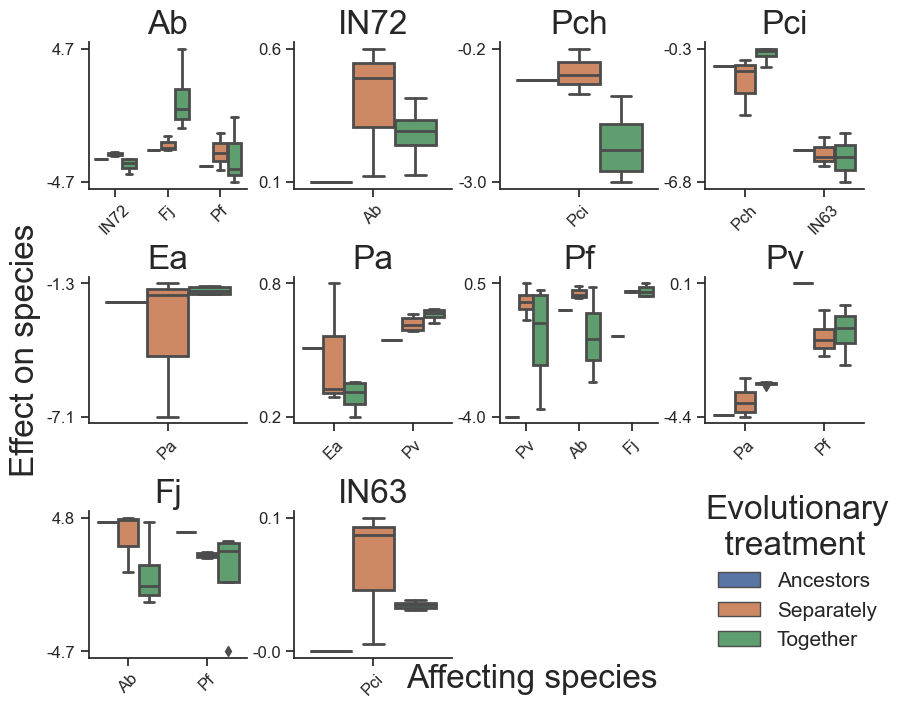

In [47]:
temp = int_tech.droplevel('exp')
temp['partner'] = temp.apply(lambda x: x.name[2].replace('_', '').replace(x.name[0], ''), axis = 1)
temp = temp[['effect', 'partner']].reset_index([2, 3, 5])
temp_anc = int_anc
temp_anc['partner'] = temp_anc.apply(lambda x: x.name[2].replace('_', '').replace(x.name[0], ''), axis = 1)
temp_anc['strain'] = 'anc'
temp_anc['m-c'] = 'anc'
temp_anc = temp_anc.reset_index().set_index(['species', 'treatment', 'strain'])
ints_temp = pd.concat([temp, temp_anc])
ints_temp = ints_temp.reset_index().set_index(['species', 'treatment', 'pair'])
rels =  ints_temp.apply(lambda x:x.name in sum_int.index, axis = 1)
ints_temp = ints_temp[rels]

fig, ax = subplots(3, 4,figsize = (10, 8))
treat = 'Pre-adapted'

for i, sp in enumerate(ints_temp.loc[:, treat, :].index.get_level_values(0).unique()):
    temp = ints_temp.loc[sp, treat, :]
    
    parts = temp['partner'].unique()
    sns.boxplot(data = temp, x = 'partner', y = 'effect',
                hue = 'm-c', ax = ax[i//4, i%4], order = parts, hue_order = ['anc', 'Monoevolved','Coevolved'])
    
    ax[i//4, i%4].legend([], frameon = False)
    ax[i//4, i%4].set_ylabel('')
    ax[i//4, i%4].set_xlabel('') 
    ax[i//4, i%4].set_xticklabels(parts, rotation = 45, fontdict = {'fontsize':12})
    ax[i//4, i%4].set_yticks((temp['effect'].min(), temp['effect'].max()))
    ax[i//4, i%4].set_yticklabels([round(temp['effect'].min(), 1), round(temp['effect'].max(), 1)],
                                  fontdict = {'fontsize':12})
    
    ax[i//4, i%4].set_title(sp)
sns.despine(ax = ax[2, 3], left = True, bottom = True)
ax[2, 3].set_yticks([])
ax[2, 3].set_xticks([])

sns.despine(ax = ax[2, 2], left = True, bottom = True)
ax[2, 2].set_yticks([])
ax[2, 2].set_xticks([])



subplots_adjust(hspace = 0.6, wspace=0.3)
ax[1, 0].set_ylabel('Effect on species')
ax[2, 2].set_xlabel('Affecting species', loc = 'right')
h, l = ax[1, 0].get_legend_handles_labels()
ax[2, 3].legend(h, ['Ancestors', 'Separately', 'Together'], frameon = False,
                loc = (-.05, 0.), prop={'size': 15}, title = 'Evolutionary\n  treatment')

savefig('figures/Supplementary/S13.png')

## S14

SignificanceResult(statistic=29.946649522284268, pvalue=0.11976689013558824)


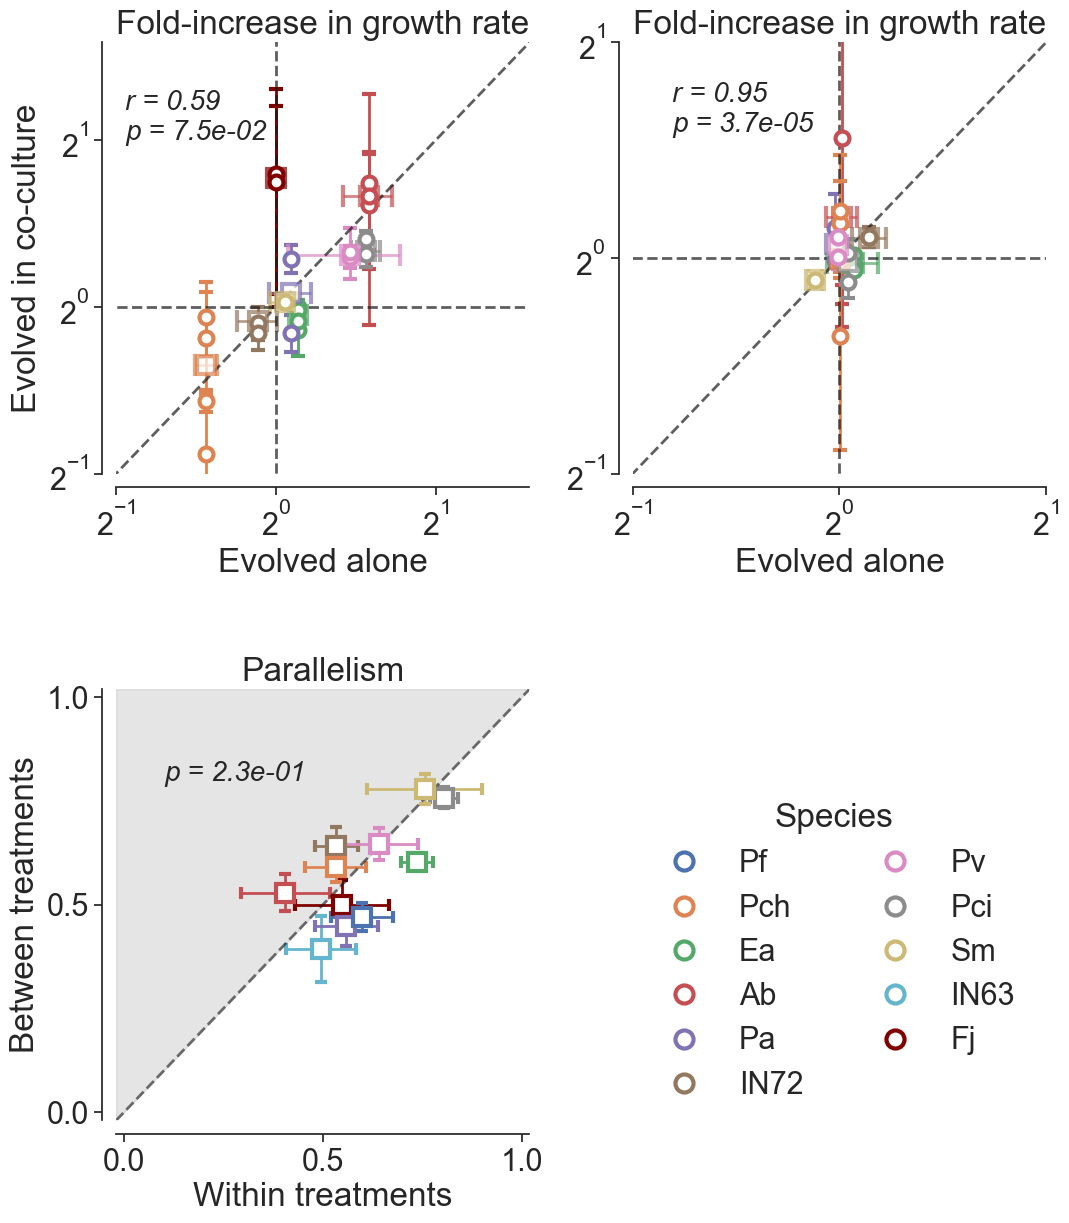

In [48]:
fig, ax = subplots(2, 2, figsize = (12, 14))

level = 'Pre-adapted'
param = 'R_norm'

cef.plot_param_bysp(gr_grand_mean, by_comm, level, param, .5, 3, .5, 3, ax = ax[0, 0], species_dict = species_dict)

ax[0, 0].set_title('Fold-increase in growth rate')

ax[0, 0].set_xlabel('Evolved alone')
ax[0, 0].set_ylabel('Evolved in co-culture')


pr, pp = pearsonr(gr_grand_mean.loc[:, level, :][(param, 'mean')].unstack().dropna()['Monoevolved'], 
        gr_grand_mean.loc[:, level, :][(param, 'mean')].unstack().dropna()['Coevolved'])

ax[0, 0].text(.52, 2,'r = {:.2f} \np = {:.1e}'.format(pr, pp),
     size = 20, style = 'italic')

level = 'Pre-adapted'
param = 'K_norm'


cef.plot_param_bysp(gr_grand_mean, by_comm, level, param, .5, 2, .5, 2, ax = ax[0, 1], species_dict = species_dict)

ax[0, 1].set_title('Fold-increase in growth rate')

ax[0, 1].set_xlabel('Evolved alone')
# ax[0, 1].set_ylabel('Coevolved')


pr, pp = pearsonr(gr_grand_mean.loc[:, level, :][(param, 'mean')].unstack().dropna()['Monoevolved'], 
        gr_grand_mean.loc[:, level, :][(param, 'mean')].unstack().dropna()['Coevolved'])

ax[0, 1].text(.57, 1.5,'r = {:.2f} \np = {:.1e}'.format(pr, pp),
     size = 20, style = 'italic')


temp = sum_growth.loc[:, 'Pre-adapted', :]
cef.plot_par(temp, 'Par',('p-corr', 'Unnamed: 18_level_1', 'Unnamed: 18_level_2'), species_dict, fmt = 's', ax = ax[1, 0])
ax[1, 0].set_xticks([0, .5, 1]);
ax[1, 0].set_yticks([0, .5, 1]);
ax[1, 0].set_title('Parallelism')
# cef.pec_score_inset(temp, 'Par',('p-corr', 'Unnamed: 18_level_1', 'Unnamed: 18_level_2'),
#                     species_dict, fig  =fig, fmt = 's', bottom = 0.52,left = 0.26)
print(combine_pvalues(temp[('Distance', 'permutations', 'p-value')].astype(numpy.float64)))

wp = wilcoxon(temp[('Par', 'mean','score')], alternative='greater')[1]

ax[1, 0].text(.1, .8,'p = {:.1e}'.format(wp),
     size = 20, style = 'italic')

sns.despine(ax = ax[1, 1], bottom = True, left = True)
ax[1, 1].set_xticks([]);
ax[1, 1].set_yticks([]);

legend_elements = [Line2D([0], [0], marker='o', color='w', label=sp,
                          mec=species_dict[sp], markersize=13, mew = 3) for sp in species_dict][:11]



ax[1, 1].legend(handles=legend_elements, 
                loc = (.02, .02), frameon = False,
                ncol = 2, title = 'Species')

subplots_adjust(wspace=0.25, hspace = 0.5)


savefig('figures/Supplementary/S14.png')

## S15

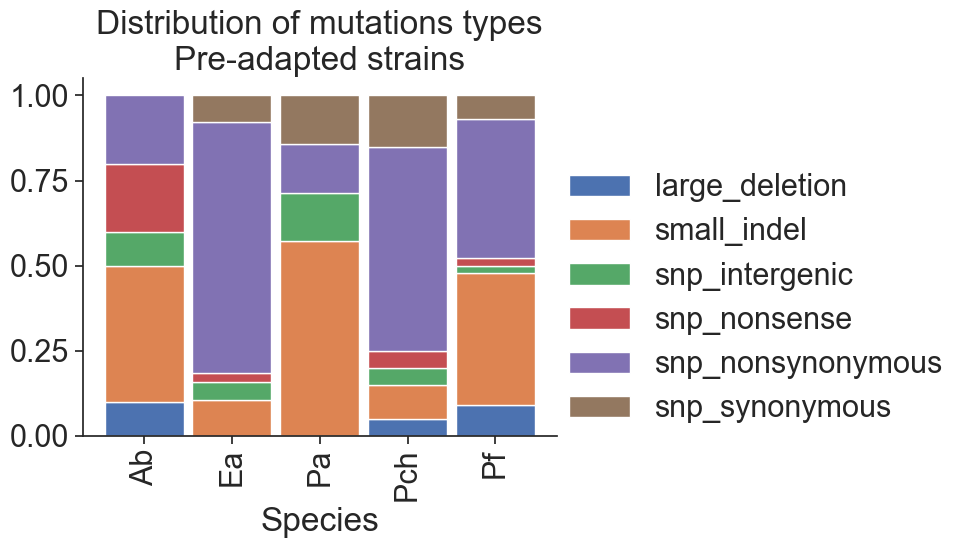

In [49]:
all_mut = pd.read_excel('Data/Mutations/num_mut.xlsx', index_col=0)

fig, ax = subplots(1, 1, figsize = (10, 6))
temp = all_mut[all_mut['Pre-Na']=='Pre-adapted']
temp = temp.groupby(['Species', 'mutation_category'])['mutation_id'].count()/temp.groupby(['Species'])['mutation_id'].count()
temp.unstack().plot.bar(stacked = True, ax = ax, width=0.9)
legend(loc = (1, 0), frameon = False)
title('Distribution of mutations types\nPre-adapted strains')

tight_layout()

savefig('figures/Supplementary/S15.png')

## S16

### A

WilcoxonResult(statistic=7.0, pvalue=1.0)


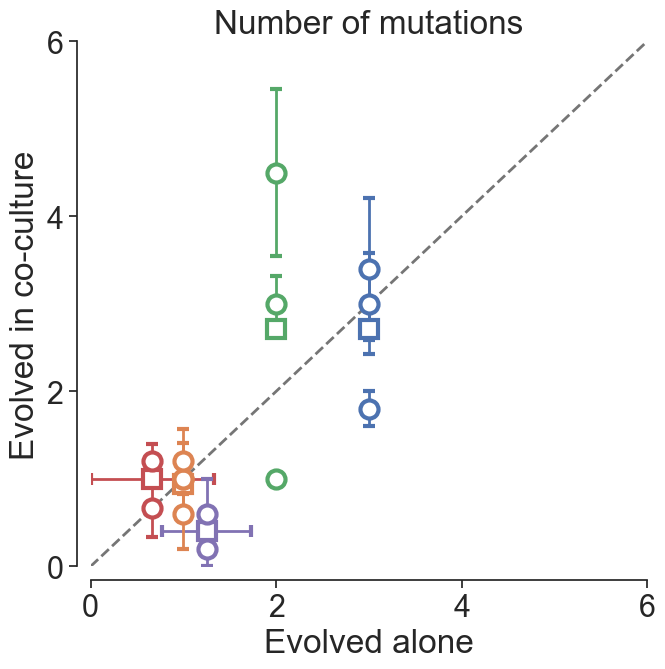

In [50]:
by_part = strain_table[strain_table['m-c']=='co'].groupby(['Species', 'Pre-Na','ev-comm']).agg({'n_mut':['mean', 'sem']}).reset_index(2)
by_sp = strain_table.groupby(['Species', 'Pre-Na', 'm-c']).agg({'n_mut':['mean', 'sem']}).unstack()['n_mut']
by_part['mono'] = by_sp[('mean', 'mono')]

fig, ax= plt.subplots(1, 1, figsize=(7, 7))
level = 'Pre-adapted'


for sp in ['Ab', 'Ea', 'Pa', 'Pch', 'Pf']:

    ax.errorbar(x = by_sp.loc[sp, level][('mean', 'mono')],
                y = by_sp.loc[sp, level][('mean', 'co')], 
            xerr = by_sp.loc[sp, level][('sem', 'mono')],
             fmt = 's', 
             mfc = 'white', color = species_dict[sp],
                mew = 3,ms = 13, label = sp, capsize = 4)

    ax.errorbar(x = by_part.loc[sp, level]['mono'],
                y = by_part.loc[sp, level][('n_mut', 'mean')], 
            yerr = by_part.loc[sp, level][('n_mut', 'sem')],
             fmt = 'o', 
             mfc = 'white', color = species_dict[sp],
                mew = 3,ms = 13,  capsize = 4)
ax.plot([0, 40], [0, 40], '--', color = 'k',alpha =0.6)

            

print(wilcoxon(by_sp.loc[:,level, :][('mean', 'mono')], 
        by_sp.loc[:,level, :][('mean', 'co')]))
subplots_adjust(hspace = .1, wspace = .1)

ax.set_xlim(-0.1, 6)
ax.set_ylim(-0.1, 6)

ax.set_xticks([0, 2, 4, 6])
ax.set_yticks([0, 2, 4, 6])

ax.set_xlim(0, 6)
ax.set_ylim(0, 6)

ax.set_title('Number of mutations')
ax.set_ylabel('Evolved in co-culture')
ax.set_xlabel('Evolved alone')
sns.despine(offset = 10)

subplots_adjust(hspace = .1, wspace = .1,
                left = 0.155, right = .95,
                bottom = 0.15, top = .9)

savefig('figures/Supplementary/S16A.png')

### B

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\1544496687.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['p-corr'] = multipletests(temp[('Par', 'permutations', 'p-value')].astype(np.float64))[1]


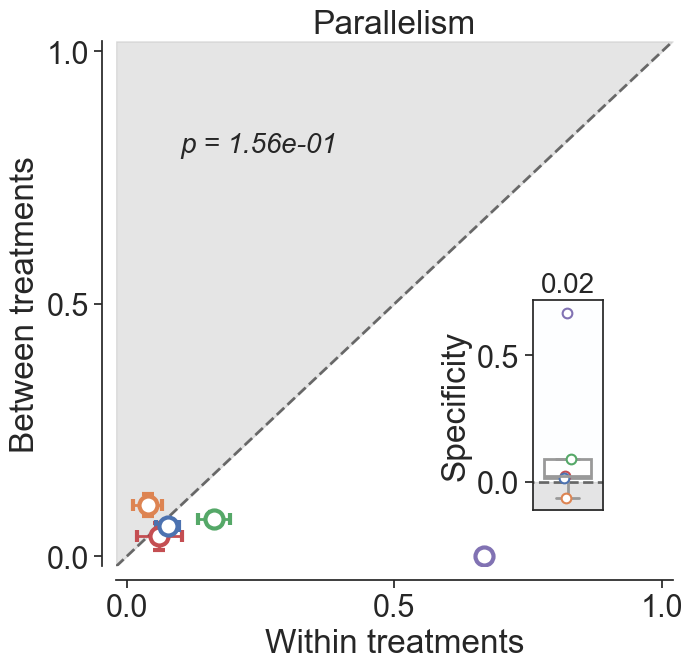

In [51]:
fig, ax = subplots(1, 1, figsize = (7, 7))

temp = sum_gene.loc[:, 'Pre-adapted', :]
temp['p-corr'] = multipletests(temp[('Par', 'permutations', 'p-value')].astype(np.float64))[1]

wp = wilcoxon(temp[('Par', 'mean', 'score')], alternative = 'greater')[1]

text(.1, .8,'p = {:.2e}'.format(wp), size = 20, style = 'italic')

cef.plot_par(temp, 'Par','p-corr', species_dict, paired=False, ax = ax)
xticks([0, .5, 1]);
yticks([0, .5, 1]);
title('Parallelism')
cef.pec_score_inset(temp, 'Par','p-corr', 
                species_dict,  paired=False, 
                fig  = fig, bottom = 0.23, left = 0.75)




subplots_adjust(left = 0.155, right = .95,
                bottom = 0.15, top = .9)

savefig('figures/Supplementary/S16B.png')

### C

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\1925610033.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['pair'] = temp.apply(lambda x:x['Species'] + ':' + x['ev-comm'], axis = 1)
C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\1925610033.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['x'] = temp['pair'].apply(lambda x: sorter[x])


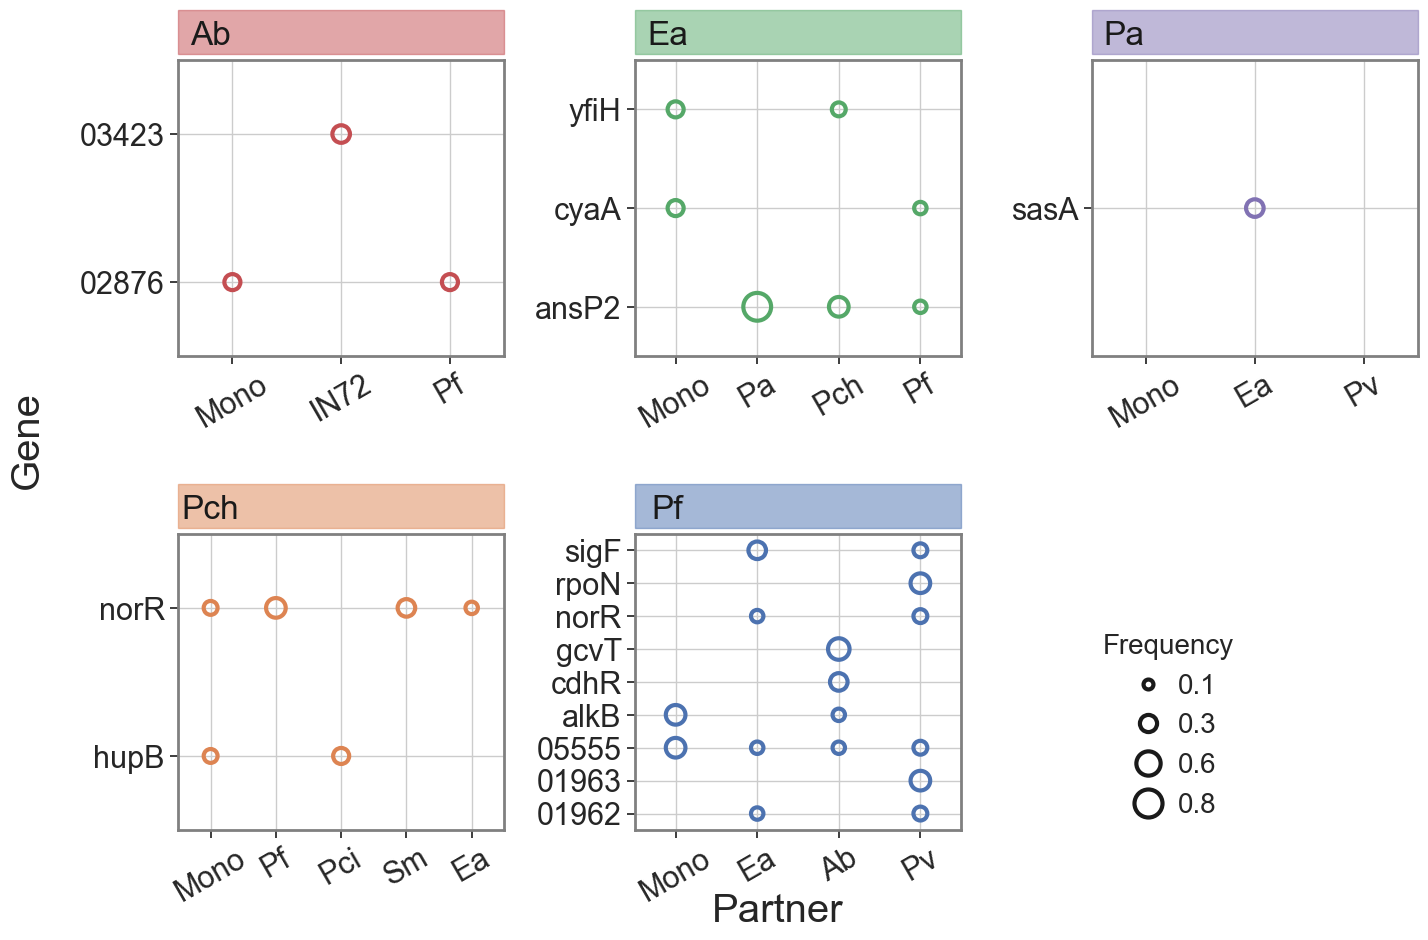

In [52]:
fig, ax = subplots(2, 3, figsize = (16, 10),
                   gridspec_kw= dict(hspace =.6, wspace = .4))

lvl = 'Pre-adapted'
more_then_one = cont_table[cont_table['N_occ']>1].loc[:, lvl,:]['eff_gene'].values
temp = mut_g[(mut_g['eff_gene'].isin(more_then_one))&(mut_g['Pre-Na']==lvl)]
sorter =['Ab:Ab', 'Ab:Ab_IN72','Ab:Pf_Ab',
         'Pa:Pa','Pa:Ea_Pa','Pa:Pa_Pv',
         'Pch:Pch', 'Pch:Pch_Pf','Pch:Pch_Pci', 
         'Pch:Pch_Sm','Pch:Ea_Pch',
         'Pf:Pf', 'Pf:Ea_Pf',  'Pf:Pf_Ab',
       'Pf:Pv_Pf', 'Ea:Ea', 'Ea:Ea_Pa', 'Ea:Ea_Pch', 'Ea:Ea_Pf']

temp['pair'] = temp.apply(lambda x:x['Species'] + ':' + x['ev-comm'], axis = 1)

sp_order = ['Ab', 'Pa', 'Pch', 'Pf','Ea']
sizes = dict(zip(temp['Freq_int_treat'].unique(), temp['Freq_int_treat'].unique()*250))
sorter = dict(zip(sorter, arange(len(sorter))))
temp['x'] = temp['pair'].apply(lambda x: sorter[x]) 
temp = temp.sort_values(by = 'x')
temp['eff_gene_short'] = temp['eff_gene'].apply(lambda x:cef.short_name(x, species))
gene_eff_pre = temp



gene_eff_pre['F_scaled'] = gene_eff_pre['Freq_int_treat']*400
gene_eff_pre['eff_gene_short'] = gene_eff_pre['eff_gene_short'].apply(lambda x:x.split('_')[1] if '_' in x else x)

lims = {'Ab':(0, 2), 'Pa':(3, 5), 'Pch':(6, 10), 
       'Pf':(11, 14), 'Ea':(15, 18)}
    
for i, sp in enumerate(sort(['Ea', 'Pa', 'Pch', 'Pf','Ab'])):
    
    temp = gene_eff_pre[(gene_eff_pre['Species']==sp)] 
    temp = temp.sort_values(by = 'eff_gene_short')
    sc = ax[i//3, i%3].scatter(x = temp['x'], y  = temp['eff_gene_short'],
                               sizes = temp['F_scaled'],
                          c = 'None', edgecolors = species_dict[sp],
                               linewidth = 3)

    ax[i//3, i%3].set_xlim(lims[sp][0]-0.5, lims[sp][1]+0.5)
    
    tick_pos = arange(lims[sp][0], lims[sp][1]+1)
    tick_mar =[list(sorter)[x].split(':')[1].replace(sp, '').replace('_', '') for x in tick_pos]
    
    tick_mar[0] = 'Mono'
    ax[i//3, i%3].set_xticks(tick_pos)
    ax[i//3, i%3].set_xticklabels(tick_mar, rotation = 30)
#     ax[i//3, i%3].legend()
    ax[i//3, i%3].set_ylim(-.5, len(temp['eff_gene_short'].unique())-.5)
    for spine in ax[i//3, i%3].spines.values():
        spine.set_edgecolor('grey')
        spine.set_linewidth(2)
    sns.despine(right = False, top = False, ax = ax[i//3, i%3])

    cef.add_colored_title(ax = ax[i//3, i%3], title =sp, color = species_dict[sp])

    ax[i//3, i%3].grid(axis = 'both')
fig.supylabel('Gene')
fig.supxlabel('Partner')

sns.despine(ax = ax[1, 2], bottom = True,left = True)
ax[1, 2].set_yticks([])
ax[1, 2].set_xticks([])


h, l = ax[0, 0].get_legend_handles_labels()
fracs = [0.1, 0.3, 0.6, 0.8]

legend_elements = [Line2D([0], [0], marker='o', color='w', label=frac,
                          mec='k', markersize=2*sqrt((frac*400)/pi), mew = 3) for frac in fracs]
leg = ax[1, 2].legend(handles = legend_elements,
                      loc = (0, 0),
                      ncol = 1,
                      title = 'Frequency', 
                      fontsize = "small", frameon = False
                     , columnspacing=0.5, handletextpad = .1)

plt.setp(leg.get_title(), fontsize = 'small')
# tight_layout()  
savefig('figures/Supplementary/S16C.png')

## S17

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\489587812.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['p-corr'] = multipletests(temp[('Par', 'permutations', 'p-value')].astype(float64))[1]


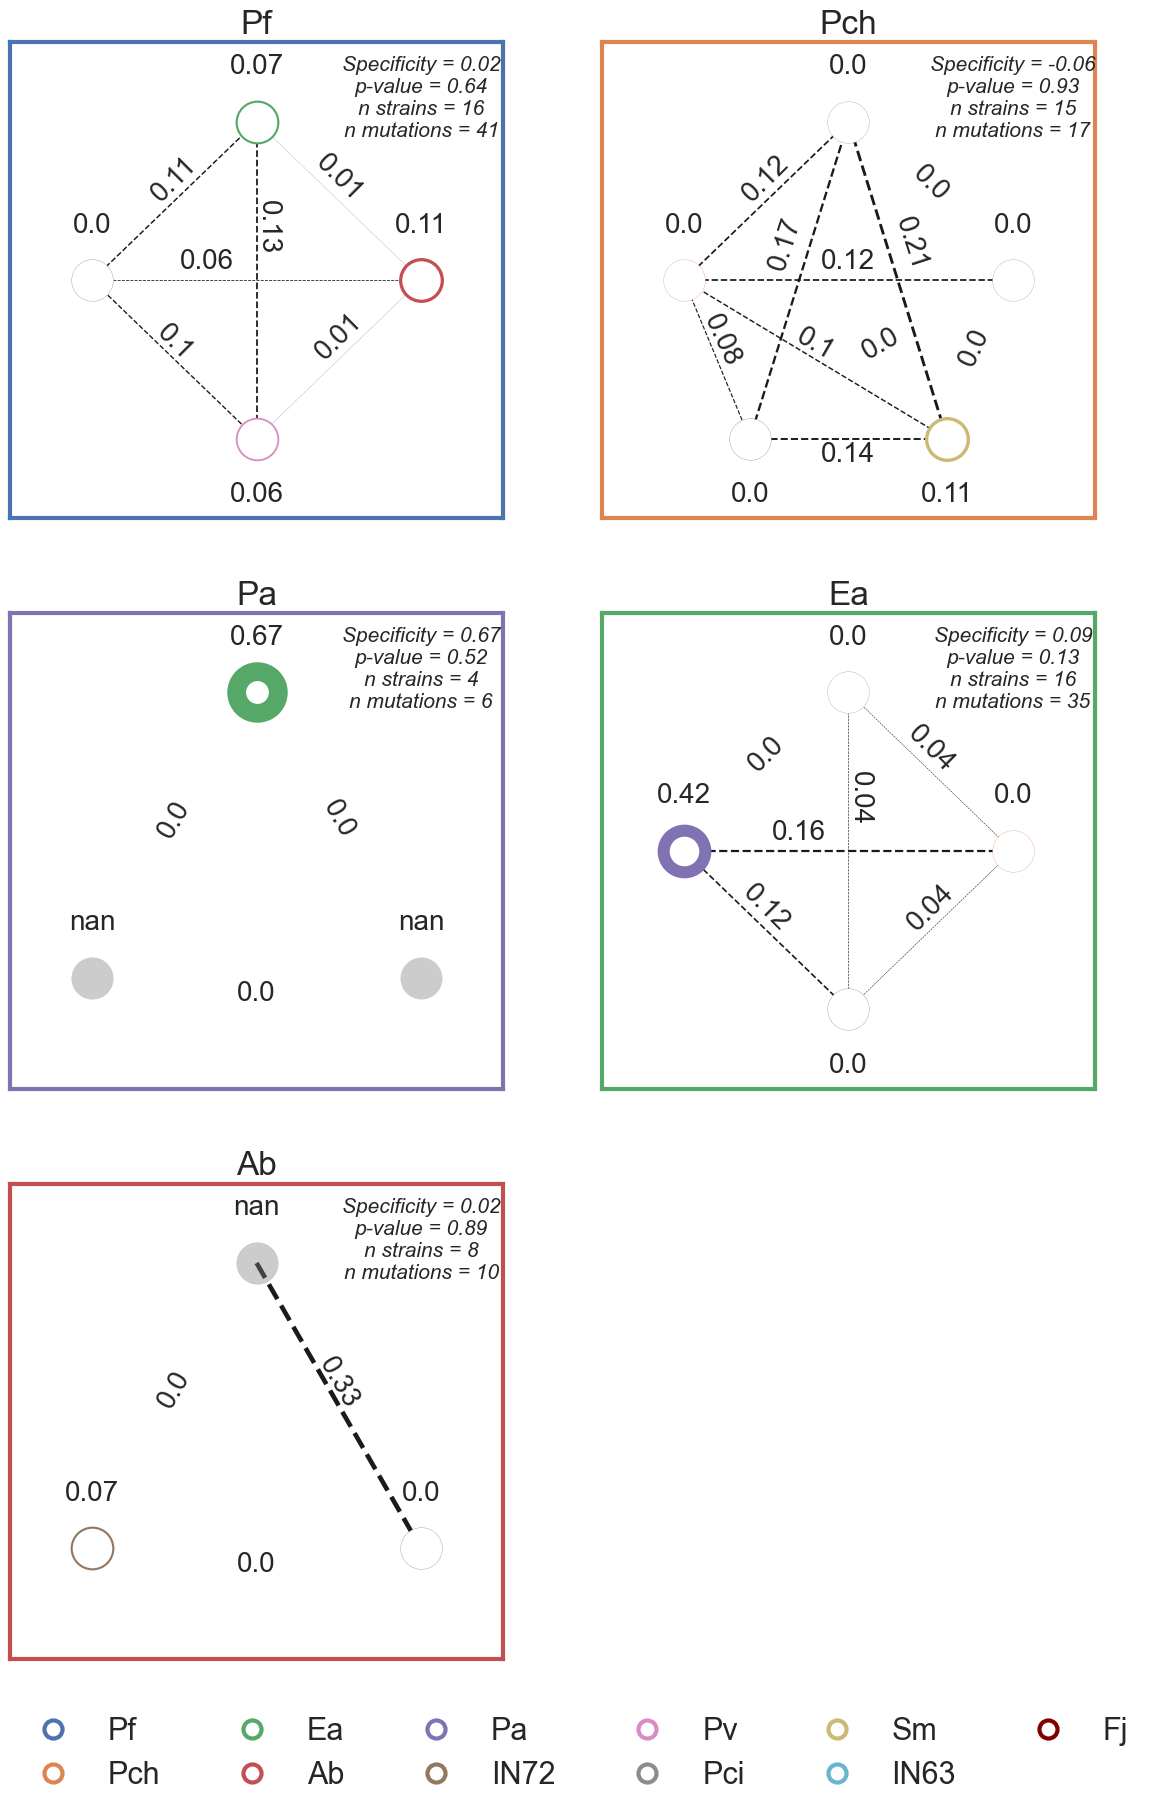

In [53]:
from itertools import combinations_with_replacement
treat = 'Pre-adapted'

temp = sum_gene.loc[:, treat, :]
temp['p-corr'] = multipletests(temp[('Par', 'permutations', 'p-value')].astype(float64))[1]

fig, ax = subplots(3, 2, figsize = (14, 21))


dot_dict = {3:[[0, -1, 1], [1, -.8, -.8]],
            4:[[0, -1, 1, 0], [1, 0, 0, -1]],
            5:[[0, -1, 1, -.6, .6], [1, 0, 0, -1, -1]]}

ang_dict = {3:[60, -60, 0],
            4:[45, -45,
               -90, 0,
               -45, 45], 
            5:[45, -45,
               72, -72, 
               0, -65,
               -30,30,
               65, 0]}

tloc_dict = {3:[(-0.5, 0.09), (0.5, 0.09),
                (0.0, -0.95)], 
            4: [(-0.5, 0.5), (0.5, 0.5),
                (0.07, .2), (-0.3, 0.07),
                (-0.5, -0.5), (0.5, -0.5)], 
            5: [(-0.5, 0.5), (0.5, 0.5),
                (-0.38, 0.08),(0.38, 0.08),
                (0.0, 0.07), (-0.77, -0.53),
                (-0.2, -0.5), (0.2, -0.5),
                (0.77, -0.53), (0.0, -1.15)]}

for i, sp in enumerate(['Pf', 'Pch', 'Pa','Ea', 'Ab']):
    
    temp_ind = mut_table[(mut_table['Species']==sp)&(mut_table['Pre-Na']==treat)]
    temp_ind = temp_ind.groupby(['ev-comm', 'strain']).mean()
    ind_agg = temp_ind.groupby('ev-comm').mean()
    temp_mat = pd.DataFrame(columns=ind_agg.index, index = ind_agg.index) # distance matrix
    for comp in list(combinations_with_replacement(ind_agg.index, 2)):
        a =  dist_mat.loc[sp, treat,comp[0]][sp, treat,comp[1]].values.flatten()
        temp_mat.loc[comp[0], comp[1]] = nanmean(list(a))
    mat = temp_mat
    inds = list(mat.index)


    cef.plot_pairwise_dists(ax[i//2, i%2], mat, dot_dict, species_dict,
                            sp, ang_dict, tloc_dict)
    spec = round(temp.loc[sp][('Par', 'mean', 'score')], 2)
    pv = round(temp.loc[sp]['p-corr'].values[0], 2)
    n_strains = len(temp_ind )
    n_mutations = len(mut_table[mut_table['strain'].isin(temp_ind.index.get_level_values(1))])
    ax[i//2, i%2].text(s = 'Specificity = ' + str(spec)+'\np-value = '+ str(pv) +'\nn strains = '+str(n_strains) + '\nn mutations = ' + str(n_mutations)
                       , x = 1, y = .9,
                       fontdict = {'fontsize':15, 'ha':'center', 'style':'italic'})
    
legend_elements = [Line2D([0], [0], marker='o', color='w', label=sp,
                      mec=species_dict[sp], markersize=13, mew = 3) for sp in species_dict][:11]
ax[2, 0].legend(handles = legend_elements,
                loc = (0, -.3), ncol = 6, frameon = False)

sns.despine(left = True, bottom = True, ax = ax[2, 1])
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])
savefig('figures/Supplementary/S17.png')


## S18

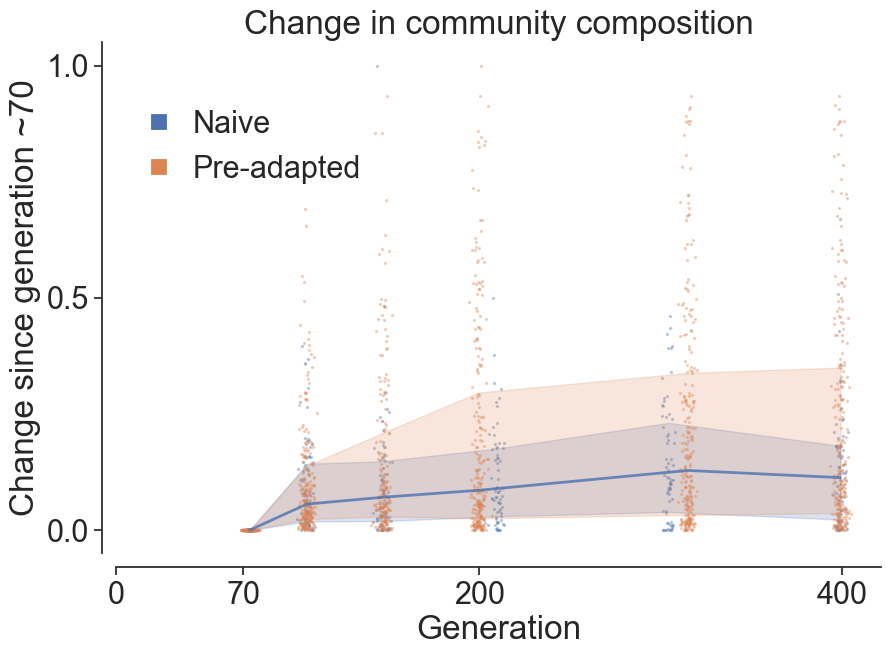

In [54]:
fig, ax = subplots(1, 1, figsize = (9, 7), sharex=True, sharey = True)

subplots_adjust(left = 0.15, bottom = .15, right = 1)

gens = cf_anc_pre.loc[cf_anc_pre.transfer>6, 'Generation'].unique()

scatter(cf_anc_pre.loc[cf_anc_pre.transfer>6, 'Gen_jit'],
        cf_anc_pre.loc[cf_anc_pre.transfer>6, 'dist_from_ee'], s = 2, alpha =0.3)

fill_between(gens, 
                 cf_anc_pre[cf_anc_pre.transfer>6].groupby('Generation').quantile(0.75)['dist_from_ee'],
                 cf_anc_pre[cf_anc_pre.transfer>6].groupby('Generation').quantile(0.25)['dist_from_ee'], 
                color = sns.color_palette()[0], alpha = 0.2)

gens = cf_anc_na.loc[cf_anc_na.transfer>6,'Generation'].unique()
scatter(cf_anc_na.loc[cf_anc_na.transfer>6,'Gen_jit'], cf_anc_na.loc[cf_anc_na.transfer>6,'dist_from_ee'], 
        s = 2, alpha =0.3)
plot(cf_anc_na[cf_anc_na.transfer>6].groupby('Generation').median()['dist_from_ee'], alpha = 0.8)

fill_between(gens, 
                 cf_anc_na[cf_anc_na.transfer>6].groupby('Generation').quantile(0.75)['dist_from_ee'],
                 cf_anc_na[cf_anc_na.transfer>6].groupby('Generation').quantile(0.25)['dist_from_ee'], 
                color = sns.color_palette()[1], alpha = 0.2)
# xlim(0, 200)
legend(['Pre-adapted', 'Naive'], frameon = False)
ylabel('Change since generation ~70')
xlabel('Generation')
xticks([0, 70, 200, 400])
yticks([0, .5, 1])
title('Change in community composition')
sns.despine(offset = 10)

legend_elements = [Line2D([0], [0], marker='s',
                          color='w', label='Naive', 
                         mew = 3, mfc= sns.color_palette()[0], ms = 15), 
                  Line2D([0], [0], marker='s',
                          color='w', label='Pre-adapted', 
                         mew = 3, mfc= sns.color_palette()[1], ms = 15)]
leg = ax.legend(handles = legend_elements,
                      loc = (.0, .7),
                      ncol = 1, 
                     frameon = False, columnspacing=0.5, handletextpad = .1 )

savefig('figures/Supplementary/S18.png')

## S19

In [55]:
### Aggregate growth, for easier ploting
gr_agg = growth_technical.groupby(['species', 'treatment']).agg({'R_norm':['mean', 'sem'], 
                                                       'K_norm':['mean', 'sem']}).unstack()
gr_agg = gr_agg.dropna()
gr_agg['pv-R'] = np.nan
gr_agg['pv-K'] = np.nan

### M-w u-test for each species:
for sp in gr_agg.index:
    
    na_k = growth_technical.loc[sp, 'Naive']['K_norm'].values
    pre_k = growth_technical.loc[sp, 'Pre-adapted']['K_norm'].values
    gr_agg.loc[sp, 'pv-K'] = mannwhitneyu(na_k, pre_k).pvalue
    
    na_r = growth_technical.loc[sp, 'Naive']['R_norm'].values
    pre_r = growth_technical.loc[sp, 'Pre-adapted']['R_norm'].values
    gr_agg.loc[sp, 'pv-R'] = mannwhitneyu(na_r, pre_r).pvalue
    
### Correct for multiple tests
gr_agg['pv_R_corr'] = multipletests(gr_agg['pv-R'])[1]
gr_agg['pv_K_corr'] = multipletests(gr_agg['pv-K'])[1]

### Aggregate interactions, for easier ploting. Use in absalute values
abs_mean = lambda x:mean(abs(x))
abs_sem = lambda x:sem(abs(x))
temp_int = int_tech.groupby(['species', 'treatment', 'pair']).agg({'diff_fanc':[abs_mean,abs_sem]}).unstack(1)['diff_fanc']
temp_int['pv'] = np.nan

for inter in temp_int.index:
    na = int_tech.droplevel('exp').loc[inter[0],'Naive',inter[1], :]['diff_fanc'].abs().dropna()
    pre = int_tech.droplevel('exp').loc[inter[0],'Pre-adapted',inter[1], :]['diff_fanc'].abs().dropna() 
    temp_int.loc[inter, 'pv'] = mannwhitneyu(na, pre).pvalue
    
temp_int['pv_corr'] = multipletests(temp_int['pv'])[1]


### Aggregate composition, for easier ploting
end_point = cf_anc_pre.loc[cf_anc_pre['transfer']==38, ['sample','dist_from_ee']].groupby('sample').agg({'dist_from_ee':['mean', 'sem']})
end_point = end_point.rename({'dist_from_ee':'Pre-adapted'}, axis = 1)
temp = cf_anc_na.loc[cf_anc_na['transfer']==38, ['sample','dist_from_ee']].groupby('sample').agg({'dist_from_ee':['mean', 'sem']})
end_point[('Naive', 'mean')] = temp[('dist_from_ee', 'mean')]
end_point[('Naive', 'sem')] = temp[('dist_from_ee', 'sem')]

end_point = end_point.dropna()

for pair in end_point.index:
    na = cf_anc_na.loc[(cf_anc_na['transfer']==38)&(cf_anc_na['sample']==pair),'dist_from_ee']
    pre = cf_anc_pre.loc[(cf_anc_pre['transfer']==38)&(cf_anc_pre['sample']==pair),'dist_from_ee']
    end_point.loc[pair, 'pv'] = mannwhitneyu(na.dropna(), pre.dropna()).pvalue
end_point['pv_corr']= multipletests(end_point['pv'])[1]

### Mutations:
by_sp = strain_table.groupby(['Species', 'Pre-Na']).agg({'n_mut':['mean', 'sem']})['n_mut'].unstack()
by_sp['pv'] = np.nan

for sp in ['Ea', 'Pf', 'Pa', 'Pch', 'Ab']:
    n_na = strain_table.loc[(strain_table['Species']==sp)&(strain_table['Pre-Na']=='Naive'), 'n_mut'].values
    n_pre = strain_table.loc[(strain_table['Species']==sp)&(strain_table['Pre-Na']=='Pre-adapted'), 'n_mut'].values
    by_sp.loc[sp, 'pv'] = mannwhitneyu(n_na, n_pre).pvalue
by_sp['pv_corr'] = multipletests(by_sp['pv'])[1]



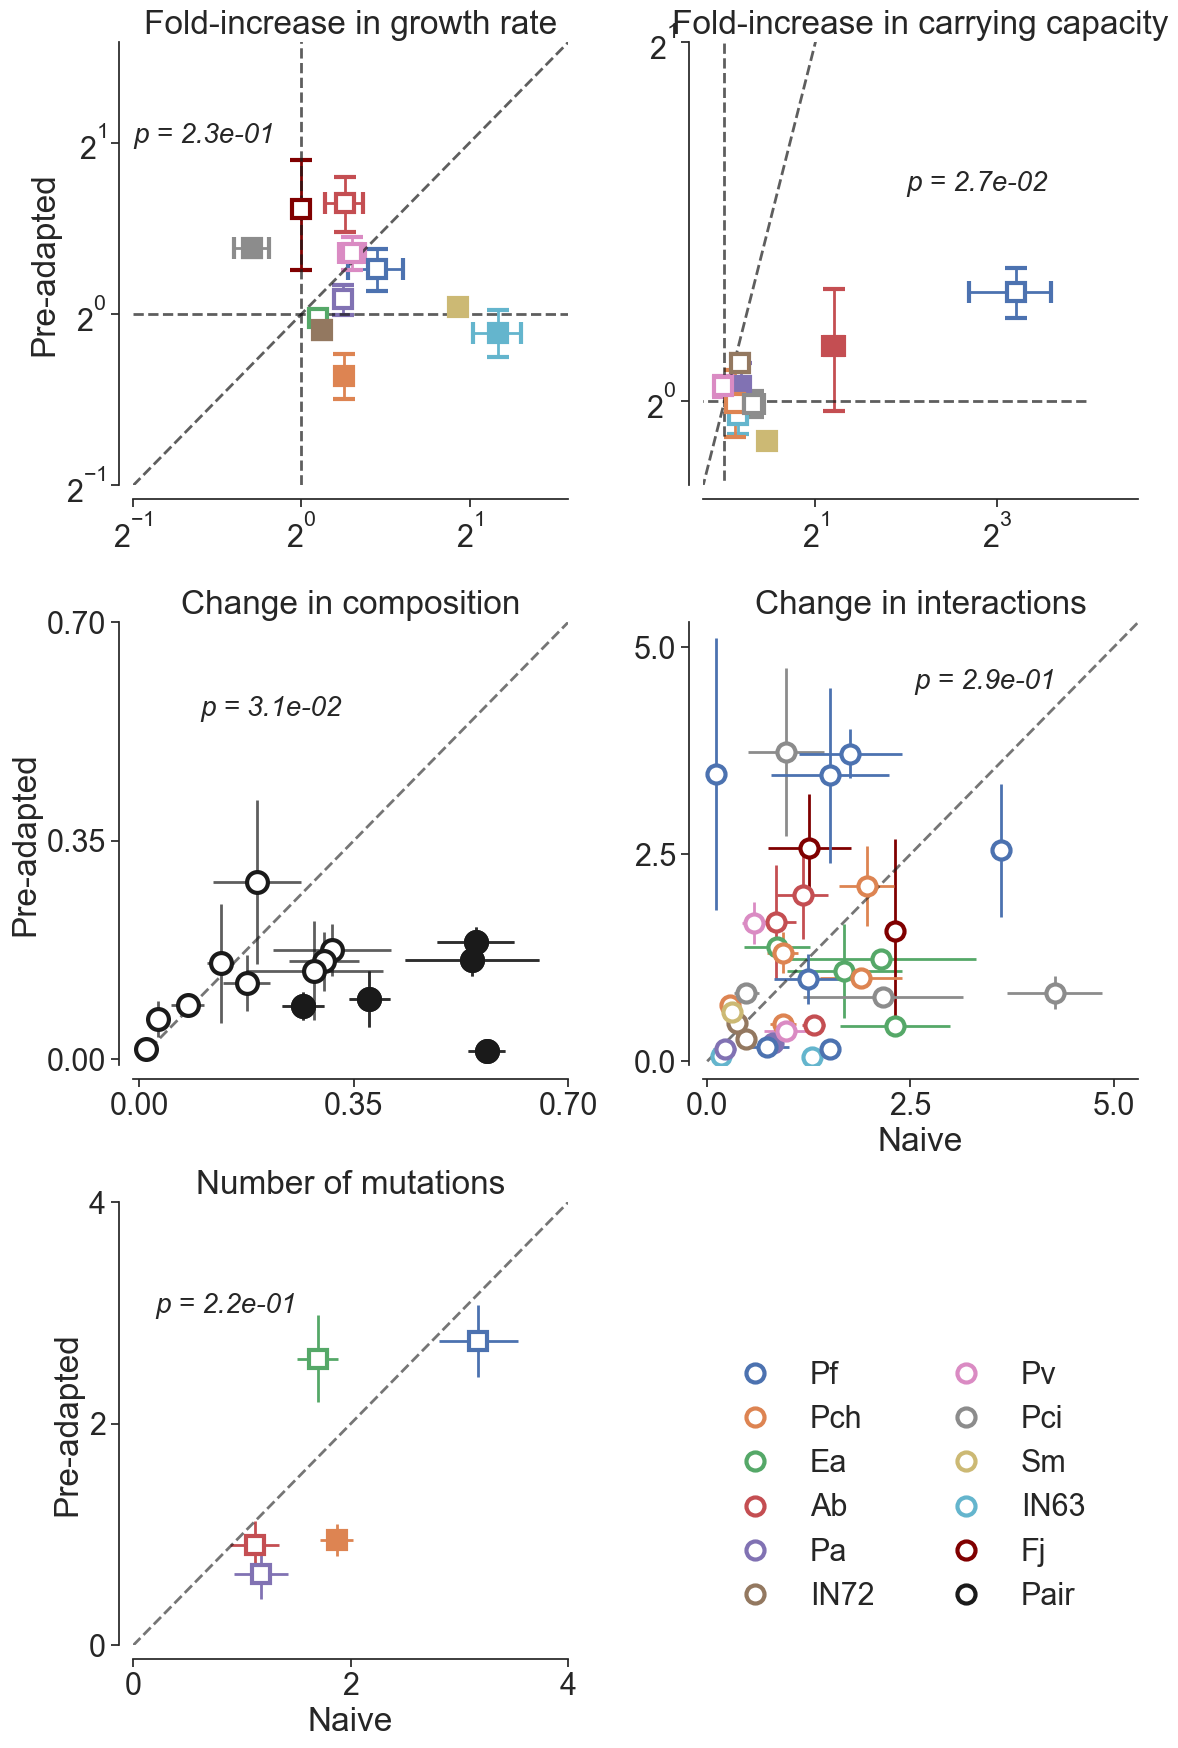

In [56]:
figure, ax = subplots(3, 2, figsize = (12, 18))


for sp in gr_agg.index:
    if gr_agg.loc[sp, 'pv_R_corr'].values[0]>0.05:
        ax[0, 0].errorbar(x =  gr_agg.loc[sp][('R_norm', 'mean', 'Naive')]
                         ,y = gr_agg.loc[sp][('R_norm', 'mean', 'Pre-adapted')], 
                        xerr = gr_agg.loc[sp][('R_norm', 'sem', 'Naive')],
                 yerr = gr_agg.loc[sp][('R_norm', 'sem', 'Pre-adapted')],
                        fmt = 's', mfc = 'white', ms = 13, 
                       capsize = 8, mew = 3, color = species_dict[sp])
    else:
        ax[0, 0].errorbar(x =  gr_agg.loc[sp][('R_norm', 'mean', 'Naive')]
             ,y = gr_agg.loc[sp][('R_norm', 'mean', 'Pre-adapted')], 
            xerr = gr_agg.loc[sp][('R_norm', 'sem', 'Naive')],
        yerr = gr_agg.loc[sp][('R_norm', 'sem', 'Pre-adapted')],
            fmt = 's',  ms = 13, 
           capsize = 8, mew = 3, color = species_dict[sp])

wp = wilcoxon(gr_agg[('R_norm', 'mean', 'Naive')],
        gr_agg[('R_norm', 'mean', 'Pre-adapted')], 
        alternative = 'greater')[1]

ax[0, 0].text(.5, 2,'p = {:.1e}'.format(wp),
     size = 20, style = 'italic')

ax[0, 0].plot([0.5, 55], [0.5, 55], color = 'k', alpha = .7, linestyle = '--')
ax[0, 0].plot([1, 1], [0.5, 55], color = 'k', alpha = .7, linestyle = '--')
ax[0, 0].plot([0.5, 55], [1, 1], color = 'k', alpha = .7, linestyle = '--')

ax[0, 0].set_ylim(0.5, 3)
ax[0, 0].set_xlim(0.5, 3)
ax[0, 0].set_yscale('log', base = 2)
ax[0, 0].set_xscale('log', base = 2)

sns.despine(offset  = 10, ax = ax[0, 0])
ax[0, 0].set_title('Fold-increase in growth rate')
# ax[0, 0].set_xlabel('Naive')
ax[0, 0].set_ylabel('Pre-adapted')
###########################################################
for sp in gr_agg.index:
    if gr_agg.loc[sp, 'pv_K_corr'].values[0]>0.05:
        ax[0, 1].errorbar(x =  gr_agg.loc[sp][('K_norm', 'mean', 'Naive')]
                         ,y = gr_agg.loc[sp][('K_norm', 'mean', 'Pre-adapted')], 
                        xerr = gr_agg.loc[sp][('K_norm', 'sem', 'Naive')],
                 yerr = gr_agg.loc[sp][('K_norm', 'sem', 'Pre-adapted')],
                        fmt = 's', mfc = 'white', ms = 13, 
                       capsize = 8, mew = 3, color = species_dict[sp])
    else:
        ax[0, 1].errorbar(x =  gr_agg.loc[sp][('K_norm', 'mean', 'Naive')]
                 ,y = gr_agg.loc[sp][('K_norm', 'mean', 'Pre-adapted')], 
                xerr = gr_agg.loc[sp][('K_norm', 'sem', 'Naive')],
         yerr = gr_agg.loc[sp][('K_norm', 'sem', 'Pre-adapted')],
                fmt = 's', ms = 13, 
               capsize = 8, mew = 3, color = species_dict[sp])
    
wp = wilcoxon(gr_agg[('K_norm', 'mean', 'Naive')],
        gr_agg[('K_norm', 'mean', 'Pre-adapted')], 
        alternative = 'greater')[1] 

ax[0, 1].text(4, 1.5,'p = {:.1e}'.format(wp),
     size = 20, style = 'italic')


ax[0, 1].plot([0.5, 2**4], [0.5, 2**4], color = 'k', alpha = .7, linestyle = '--')
ax[0, 1].plot([1, 1], [0.5, 2**45], color = 'k', alpha = .7, linestyle = '--')
ax[0, 1].plot([0.5, 2**4], [1, 1], color = 'k', alpha = .7, linestyle = '--')


ax[0, 1].set_ylim(0.85, 2)
ax[0, 1].set_xlim(0.85, 2.2**4)

ax[0, 1].set_yscale('log', base = 2)
ax[0, 1].set_xscale('log', base = 2)

sns.despine(offset  = 10, ax = ax[0, 1])
ax[0, 1].set_title('Fold-increase in carrying capacity')

#######################################

markers, caps, bars = ax[1, 0].errorbar(x = end_point[('Naive', 'mean')],
                                        y = end_point[('Pre-adapted', 'mean')], 
                                        xerr = end_point[('Naive', 'sem')],
                                        yerr = end_point[('Pre-adapted', 'sem')], 
                                        fmt = 'o', ms = 15, color = 'k', mfc = 'white', mew = 3)
[bar.set_alpha(0.7) for bar in bars]
end_sig = end_point[end_point['pv_corr']<0.05]

markers, caps, bars = ax[1, 0].errorbar(x = end_sig[('Naive', 'mean')],
                                        y = end_sig[('Pre-adapted', 'mean')], 
                                        xerr = end_sig[('Naive', 'sem')]
                                        , yerr = end_sig[('Pre-adapted', 'sem')],  fmt = 'o', ms = 15, color = 'k', mfc = 'k', mew = 3)
[bar.set_alpha(0.7) for bar in bars]

ax[1, 0].plot([0, 0.7], [0, 0.7], color = 'k', alpha = 0.6, linestyle = 'dashed')

ax[1, 0].set_title('Change in composition')
# ax[1, 0].set_xlabel('Naive pair')
ax[1, 0].set_ylabel('Pre-adapted')
ax[1, 0].set_xticks([0, .35, .7])
ax[1, 0].set_yticks([0, .35, .7])
ax[1, 0].set_xlim(-0.01, 0.7)
ax[1, 0].set_ylim(-0.01, 0.7)

wp = wilcoxon(end_sig[('Naive', 'mean')],
        end_sig[('Pre-adapted', 'mean')], 
        alternative = 'greater')[1] 

ax[1, 0].text(.1, 0.55,'p = {:.1e}'.format(wp),
     size = 20, style = 'italic')

########################################

for inter in temp_int.index:
    
        if temp_int.loc[inter, 'pv_corr'] > .05:
            ax[1, 1].errorbar(x = temp_int.loc[inter][('<lambda_0>', 'Naive')],
                            y = temp_int.loc[inter][('<lambda_0>', 'Pre-adapted')], 
                    xerr = temp_int.loc[inter][('<lambda_1>', 'Naive')],
                     yerr = temp_int.loc[inter][('<lambda_1>', 'Pre-adapted')], 
                     fmt = 'o', 
                     mfc = 'white', color = species_dict[inter[0]],
                              mew = 3,ms = 13, label = sp)
        else:
            ax[1, 1].errorbar(x = temp_int.loc[inter][('<lambda_0>', 'Naive')],
            y = temp_int.loc[inter][('<lambda_0>', 'Pre-adapted')], 
            xerr = temp_int.loc[inter][('<lambda_1>', 'Naive')],
            yerr = temp_int.loc[inter][('<lambda_1>', 'Pre-adapted')], 
            fmt = 'o', color = species_dict[inter[0]],
              mew = 3,ms = 13, label = sp) 
        
ax[1, 1].plot([0, 5.5], [0, 5.5], '--', color = 'k',alpha = 0.6)

ax[1, 1].set_title('Change in interactions')
ax[1, 1].set_xlabel('Naive')


ax[1, 1].set_xticks([0, 2.5, 5])
ax[1, 1].set_yticks([0, 2.5, 5])
ax[1, 1].set_xlim(-0.05, 5.3)
ax[1, 1].set_ylim(-0.05, 5.3)

wp = wilcoxon(temp_int[('<lambda_0>', 'Naive')],
        temp_int[('<lambda_0>', 'Pre-adapted')], 
        alternative = 'greater')[1] 

ax[1, 1].text(2.55, 4.5,'p = {:.1e}'.format(wp),
     size = 20, style = 'italic')


###########################################
for sp in ['Ab', 'Ea', 'Pa', 'Pch', 'Pf']:
    
        if by_sp.loc[sp, 'pv_corr'].values[0]>.05:
            ax[2, 0].errorbar(x = by_sp.loc[sp][('mean', 'Naive')],
                            y = by_sp.loc[sp][('mean', 'Pre-adapted')], 
                    xerr = by_sp.loc[sp][('sem', 'Naive')],
                     yerr = by_sp.loc[sp][('sem', 'Pre-adapted')], 
                     fmt = 's', 
                     mfc = 'white', color = species_dict[sp],
                              mew = 3,ms = 13, label = sp)
        else:
            ax[2, 0].errorbar(x = by_sp.loc[sp][('mean', 'Naive')],
            y = by_sp.loc[sp][('mean', 'Pre-adapted')], 
            xerr = by_sp.loc[sp][('sem', 'Naive')],
            yerr = by_sp.loc[sp][('sem', 'Pre-adapted')], 
            fmt = 's',color = species_dict[sp],
            mew = 3,ms = 13, label = sp)

ax[2, 0].plot([0, 7], [0, 7], '--', color = 'k',alpha = 0.6)

ax[2, 0].set_title('Number of mutations')
ax[2, 0].set_xlabel('Naive')
ax[2, 0].set_ylabel('Pre-adapted')


ax[2, 0].set_xticks([0, 2, 4])
ax[2, 0].set_yticks([0, 2, 4])
ax[2, 0].set_xlim(0, 4)
ax[2, 0].set_ylim(0, 4)


wp = wilcoxon(by_sp['mean'].dropna()['Naive'],
       by_sp['mean'].dropna()['Pre-adapted'], 
        alternative = 'greater')[1] 

ax[2, 0].text(.2, 3,'p = {:.1e}'.format(wp),
     size = 20, style = 'italic')
####################



sns.despine(offset  = 10, ax = ax[1, 1])
sns.despine(offset  = 10, ax = ax[1, 0])
sns.despine(offset  = 10, ax = ax[2, 0])

sns.despine(ax = ax[2, 1],
           bottom = True, left = True)
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])

ax[2, 1]
legend_elements = [Line2D([0], [0], marker='o', color='w', label=sp,
                          mec=species_dict[sp], markersize=13, mew = 3) for sp in species_dict][:11]
legend_elements.append(Line2D([0], [0], marker='o',
                              color='w', label='Pair',
                          mec='k', markersize=13, mew = 3))


ax[2, 1].legend(handles=legend_elements, loc = (.02, .05), frameon = False, ncol = 2)

tight_layout()

savefig('figures/Supplementary/S19.png')

## S20

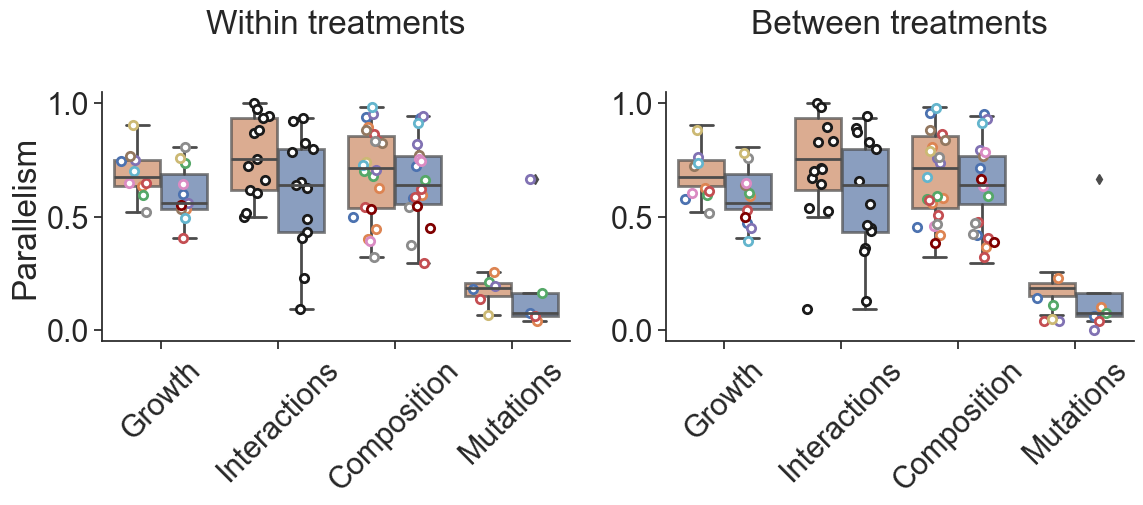

In [57]:
figure, ax = subplots(1, 2, figsize = (12, 6))

simsum['x'] = simsum.apply(lambda x:orderd_by.loc[x['param'], 'x'] + pre_na[x['treatment']] + random.normal(0, 0.05), axis = 1)


for sp in species[:-1]:
    
    ax[0].errorbar(x = simsum.loc[simsum['species']==sp, 'x'],
                y = simsum.loc[simsum['species']==sp, 'within'], 
                  fmt = 'o', mec = species_dict[sp], mfc = 'w', mew = 2)

    
ax[0].errorbar(x = simsum.loc[simsum['param']=='Composition', 'x'],
            y = simsum.loc[simsum['param']=='Composition', 'within'], 
              fmt = 'o', mec = 'k', mfc = 'w', mew = 2)


sns.boxplot(data= simsum, x = 'param', y = 'within',
            hue = 'treatment',
            palette  =[sns.color_palette()[1],
                       sns.color_palette()[0]], 
           boxprops=dict(alpha=.7), ax = ax[0],
            order = orderd_by.index)

ax[0].set_ylim(-0.05, 1.05)

ax[0].set_xlabel('')
ax[0].set_title('Within treatments', y=1.2)
ax[0].set_ylabel('Parallelism')


ax[0].legend([], frameon = False, loc = (.5, .8))
ax[0].set_yticks([0, .5, 1])

ax[0].set_xticklabels(['Growth', 'Interactions','Composition', 'Mutations'], rotation = 45)

for sp in species[:-1]:
    
    ax[1].errorbar(x = simsum.loc[simsum['species']==sp, 'x'],
                y = simsum.loc[simsum['species']==sp, 'between'], 
                  fmt = 'o', mec = species_dict[sp], mfc = 'w', mew = 2)

    
ax[1].errorbar(x = simsum.loc[simsum['param']=='Composition', 'x'],
            y = simsum.loc[simsum['param']=='Composition', 'between'], 
              fmt = 'o', mec = 'k', mfc = 'w', mew = 2)


sns.boxplot(data= simsum, x = 'param', y = 'within',
            hue = 'treatment',
            palette  =[sns.color_palette()[1],
                       sns.color_palette()[0]], 
           boxprops=dict(alpha=.7), ax = ax[1],
            order = orderd_by.index)

ax[1].set_ylim(-0.05, 1.05)

ax[1].set_xlabel('')
ax[1].set_title('Between treatments', y=1.2)
ax[1].set_ylabel('')



ax[1].legend([], frameon = False, loc = (.5, .8))
ax[1].set_yticks([0, .5, 1])
ax[1].set_xticklabels(['Growth', 'Interactions','Composition', 'Mutations'], rotation = 45)


tight_layout()

savefig('figures/Supplementary/S20.png')

In [58]:
a = simsum.groupby(['species', 'treatment', 'param']).mean()['between'].unstack(1)
b = simsum.groupby(['species', 'treatment', 'param']).mean()['within'].unstack(1)
tog = pd.concat([a, b]).dropna()
wilcoxon(tog['Naive'],
         tog['Pre-adapted'],
         alternative='greater')

WilcoxonResult(statistic=870.0, pvalue=0.012104749711129514)

## S21

In [59]:
phylo_dist = pd.read_excel('Data/Phylo.xlsx', index_col=0)
for sp in phylo_dist.index:
    for sp2 in phylo_dist.index:
        phylo_dist.loc[sp, sp2] = phylo_dist.loc[sp2, sp]

treat = 'Naive'
temp = sum_gene.loc[:, treat, :]
inter_na['gene_diff'] = inter_na.apply(lambda x: cef.get_pairwise_gene_dist(mut_table, dist_mat, x.name[1], treat, x.name[0]), axis = 1)
inter_na['growth_diff'] = inter_na.apply(lambda x: cef.get_pairwise_gr_dist(growth_technical, anc_uni, x.name[1], treat, x.name[0]), axis = 1)
get_comp = lambda x:sum_comp.loc[x.name[0], treat][('Par', 'mean', 'score')] if (x.name[0], treat) in sum_comp.index else np.nan
inter_na['comp_diff'] = inter_na.apply(get_comp, axis = 1)
get_int = lambda x:sum_int.loc[x.name[1], treat, x.name[0]][('Par', 'mean', 'score')] if (x.name[1], treat, x.name[0]) in sum_int.index else np.nan
inter_na['int_diff'] = inter_na.apply(get_int, axis = 1)
inter_na['phylo'] = inter_na.apply(lambda x: phylo_dist.loc[x.name[0].split('_')[0], x.name[0].split('_')[1]], axis =1)
inter_na['treat'] = treat

treat = 'Pre-adapted'
temp = sum_gene.loc[:, treat, :]
inter_pre['gene_diff'] = inter_pre.apply(lambda x: cef.get_pairwise_gene_dist(mut_table, dist_mat, x.name[1], treat, x.name[0]), axis = 1)
inter_pre['growth_diff'] = inter_pre.apply(lambda x: cef.get_pairwise_gr_dist(growth_technical, anc_uni, x.name[1], treat, x.name[0]), axis = 1)
get_comp = lambda x:sum_comp.loc[x.name[0], treat][('Par', 'mean', 'score')] if (x.name[0], treat) in sum_comp.index else np.nan
inter_pre['comp_diff'] = inter_pre.apply(get_comp, axis = 1)
get_int = lambda x:sum_int.loc[x.name[1], treat, x.name[0]][('Par', 'mean', 'score')] if (x.name[1], treat, x.name[0]) in sum_int.index else np.nan
inter_pre['int_diff'] = inter_pre.apply(get_int, axis = 1)
inter_pre['phylo'] = inter_pre.apply(lambda x: phylo_dist.loc[x.name[0].split('_')[0], x.name[0].split('_')[1]], axis =1)
inter_pre['treat'] = treat

inter_na.index.names = ['sample', 'sp']
inter_pre.index.names = ['sample', 'sp']
int_fin = pd.concat([inter_na, inter_pre]).reset_index().set_index(['treat', 'sp', 'sample'])


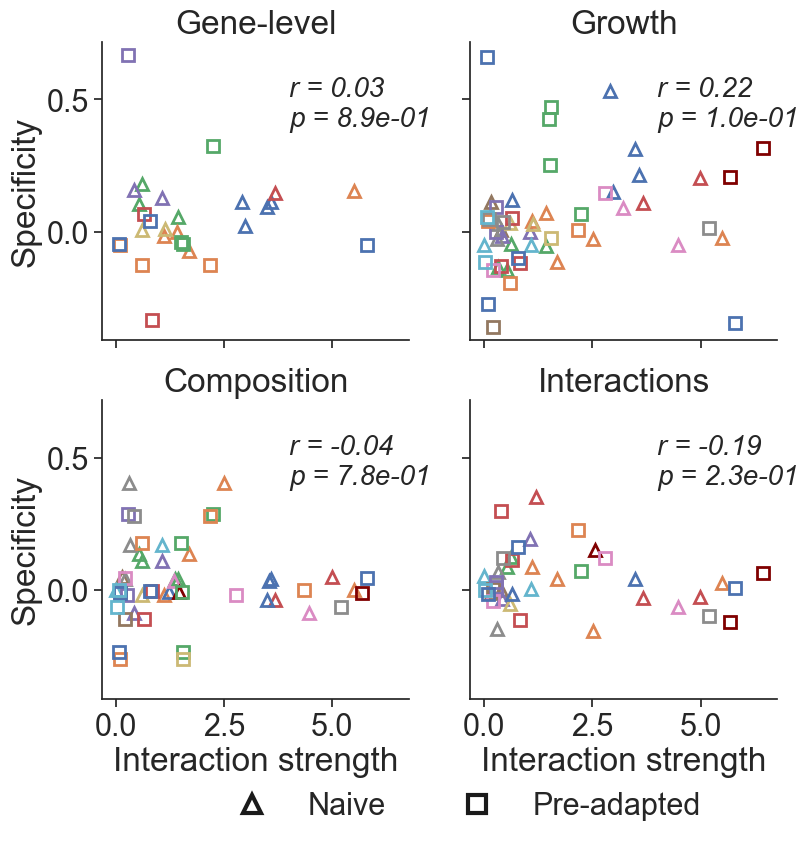

In [60]:

fig, ax = subplots(2, 2, figsize = (9, 9),
                   sharex = True, sharey = True)
titles_ = ['Gene-level', 'Growth', 
          'Composition', 'Interactions']
pcors = []
for i, dif_dist in enumerate(['gene_diff', 'growth_diff',
                    'comp_diff', 'int_diff']):
    
    temp = int_fin.loc['Naive'][['mean', dif_dist]].dropna()
    for sp in temp.index.get_level_values(0).unique():
        ax[i//2, i%2].errorbar(abs(temp.loc[sp]['mean']), 
                       temp.loc[sp][dif_dist], 
                       fmt = '^', 
                       mfc = 'None', 
                       mec = species_dict[sp],
                       ms = 9, mew = 2)
        
    temp = int_fin.loc['Pre-adapted'][['mean', dif_dist]].dropna()
    for sp in temp.index.get_level_values(0).unique():
        ax[i//2, i%2].errorbar(abs(temp.loc[sp]['mean']), 
                       temp.loc[sp][dif_dist], 
                       fmt = 's', 
                       mfc = 'None', 
                       mec = species_dict[sp],
                       ms = 9, mew = 2)
    
    ax[i//2, i%2].set_title(titles_[i])
    
    x, y = int_fin[['mean', dif_dist]].dropna()['mean'].abs(), int_fin[['mean', dif_dist]].dropna()[dif_dist]
    pr, pp = pearsonr(x, y)
    pcors.append(pp)
    ax[i//2, i%2].text(4, 0.4,'r = {:.2f} \np = {:.1e}'.format(pr, pp), size = 20, style = 'italic')
    
ax[0, 0].set_ylabel('Specificity')
ax[1, 0].set_ylabel('Specificity')    

ax[1, 0].set_xlabel('Interaction strength')
ax[1, 1].set_xlabel('Interaction strength')  

# tight_layout()
# savefig('figures/Supps/spec_cors')

legend_elements = []
legend_elements.append(Line2D([0], [0], marker='^',
                              color='w', label='Naive',
                          mec='k', markersize=13, mew = 3))
legend_elements.append(Line2D([0], [0], marker='s',
                              color='w', label='Pre-adapted',
                          mec='k', markersize=13, mew = 3))


ax[1, 0].legend(handles=legend_elements,
                loc = (.35, -.45),
             ncol = 2, frameon = False)

subplots_adjust(bottom = .15, left = .15)

savefig('figures/Supplementary/S21.png')

## S22

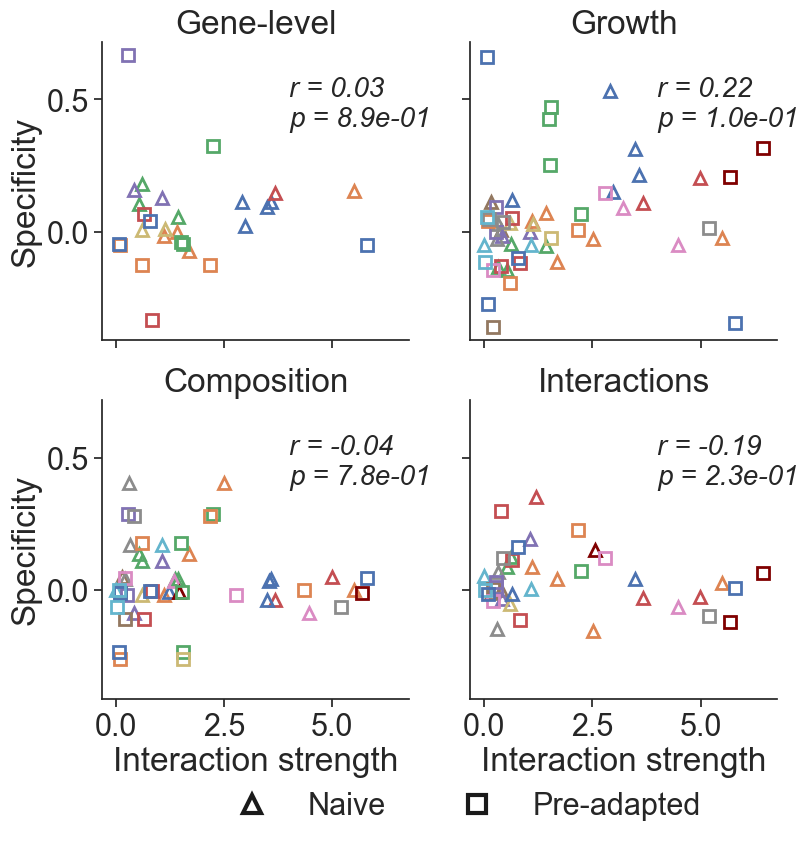

In [61]:
fig, ax = subplots(2, 2, figsize = (9, 9),
                   sharex = True, sharey = True)
titles_ = ['Gene-level', 'Growth', 
          'Composition', 'Interactions']
pcors = []
for i, dif_dist in enumerate(['gene_diff', 'growth_diff',
                    'comp_diff', 'int_diff']):
    
    temp = int_fin.loc['Naive'][['mean', dif_dist]].dropna()
    for sp in temp.index.get_level_values(0).unique():
        ax[i//2, i%2].errorbar(abs(temp.loc[sp]['mean']), 
                       temp.loc[sp][dif_dist], 
                       fmt = '^', 
                       mfc = 'None', 
                       mec = species_dict[sp],
                       ms = 9, mew = 2)
        
    temp = int_fin.loc['Pre-adapted'][['mean', dif_dist]].dropna()
    for sp in temp.index.get_level_values(0).unique():
        ax[i//2, i%2].errorbar(abs(temp.loc[sp]['mean']), 
                       temp.loc[sp][dif_dist], 
                       fmt = 's', 
                       mfc = 'None', 
                       mec = species_dict[sp],
                       ms = 9, mew = 2)
    
    ax[i//2, i%2].set_title(titles_[i])
    
    x, y = int_fin[['mean', dif_dist]].dropna()['mean'].abs(), int_fin[['mean', dif_dist]].dropna()[dif_dist]
    pr, pp = pearsonr(x, y)
    pcors.append(pp)
    ax[i//2, i%2].text(4, 0.4,'r = {:.2f} \np = {:.1e}'.format(pr, pp), size = 20, style = 'italic')
    
ax[0, 0].set_ylabel('Specificity')
ax[1, 0].set_ylabel('Specificity')    

ax[1, 0].set_xlabel('Interaction strength')
ax[1, 1].set_xlabel('Interaction strength')  

legend_elements = []
legend_elements.append(Line2D([0], [0], marker='^',
                              color='w', label='Naive',
                          mec='k', markersize=13, mew = 3))
legend_elements.append(Line2D([0], [0], marker='s',
                              color='w', label='Pre-adapted',
                          mec='k', markersize=13, mew = 3))


ax[1, 0].legend(handles=legend_elements,
                loc = (.35, -.45),
             ncol = 2, frameon = False)

subplots_adjust(bottom = .15, left = .15)

savefig('figures/Supplementary/S22.png')

## S24

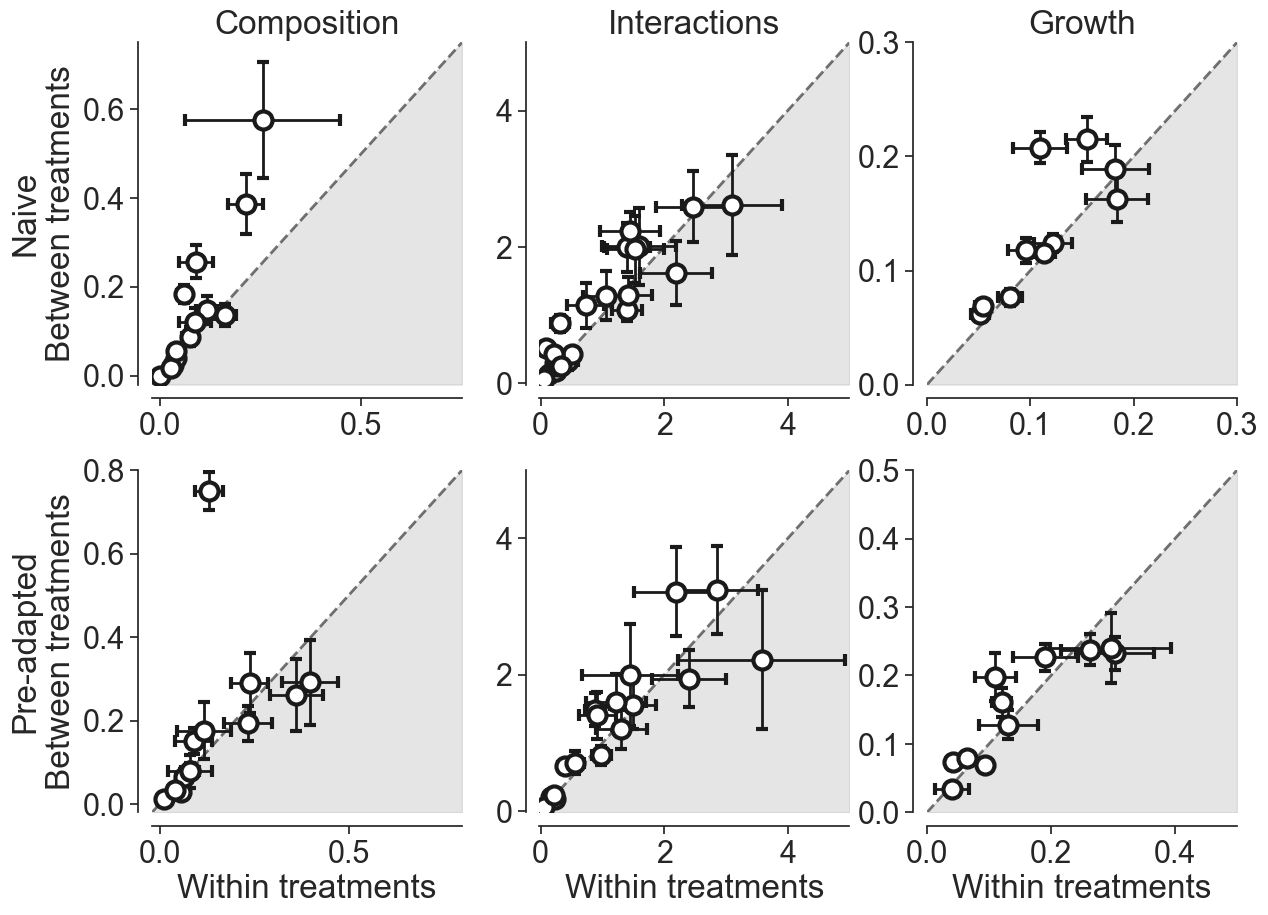

In [62]:
fig, ax = subplots(2, 3, figsize = (14, 10))
subplots_adjust(wspace = .25, hspace = .25)

for sum_table in [sum_comp, sum_int, sum_growth]:
    sum_table['p-corr'] = multipletests(sum_table[('Distance', 'permutations', 'p-value')].astype(numpy.float64))[1]
treat = 'Naive'

cef.plot_par(sum_comp.loc[:, treat, :], 'Distance',
             'p-corr',
             species_dict, paired=True, ax = ax[0, 0],
             def_lims = (-0.02, 0.75), ticks=[0, .35, .7])
ax[0, 0].set_title('Composition')
cef.plot_par(sum_int.loc[:, treat, :], 'Distance',
             'p-corr', species_dict,
             paired=True, ax = ax[0, 1],def_lims = (-0.02, 5), ticks=[0, .35, .7])
ax[0, 1].set_title('Interactions')

cef.plot_par(sum_growth.loc[:, treat, :], 'Distance',
             ('p-corr', 'Unnamed: 18_level_1', 'Unnamed: 18_level_2'),
             species_dict, paired=True, ax = ax[0, 2],
             def_lims = (0, .3), ticks=[0, .15, .3])
ax[0, 2].set_title('Growth')


treat = 'Pre-adapted'

cef.plot_par(sum_comp.loc[:, treat, :], 'Distance',
            'p-corr',
             species_dict, paired=True, ax = ax[1, 0],
             def_lims = (-0.02, 0.8), ticks=[0, .4, .8])
cef.plot_par(sum_int.loc[:, treat, :], 'Distance',
            ('Distance', 'permutations', 'p-value'), species_dict,
             paired=True, ax = ax[1, 1],
             def_lims = (-0.02, 5), ticks=[0, .35, .7])

cef.plot_par(sum_growth.loc[:, treat, :], 'Distance',
             ('p-corr', 'Unnamed: 18_level_1', 'Unnamed: 18_level_2'),
             species_dict, paired=True, ax = ax[1, 2],
             def_lims = (0, .5), ticks=[0, .25, .5])


ax[0, 1].set_xlabel('')
ax[0, 2].set_xlabel('')
ax[0, 0].set_xlabel('')


ax[0, 1].set_ylabel('')
ax[0, 2].set_ylabel('')
ax[1, 1].set_ylabel('')
ax[1, 2].set_ylabel('')

ax[0, 0].set_ylabel('Naive\nBetween treatments')
ax[1, 0].set_ylabel('Pre-adapted\nBetween treatments')

savefig('figures/Supplementary/S24.png')

## S25

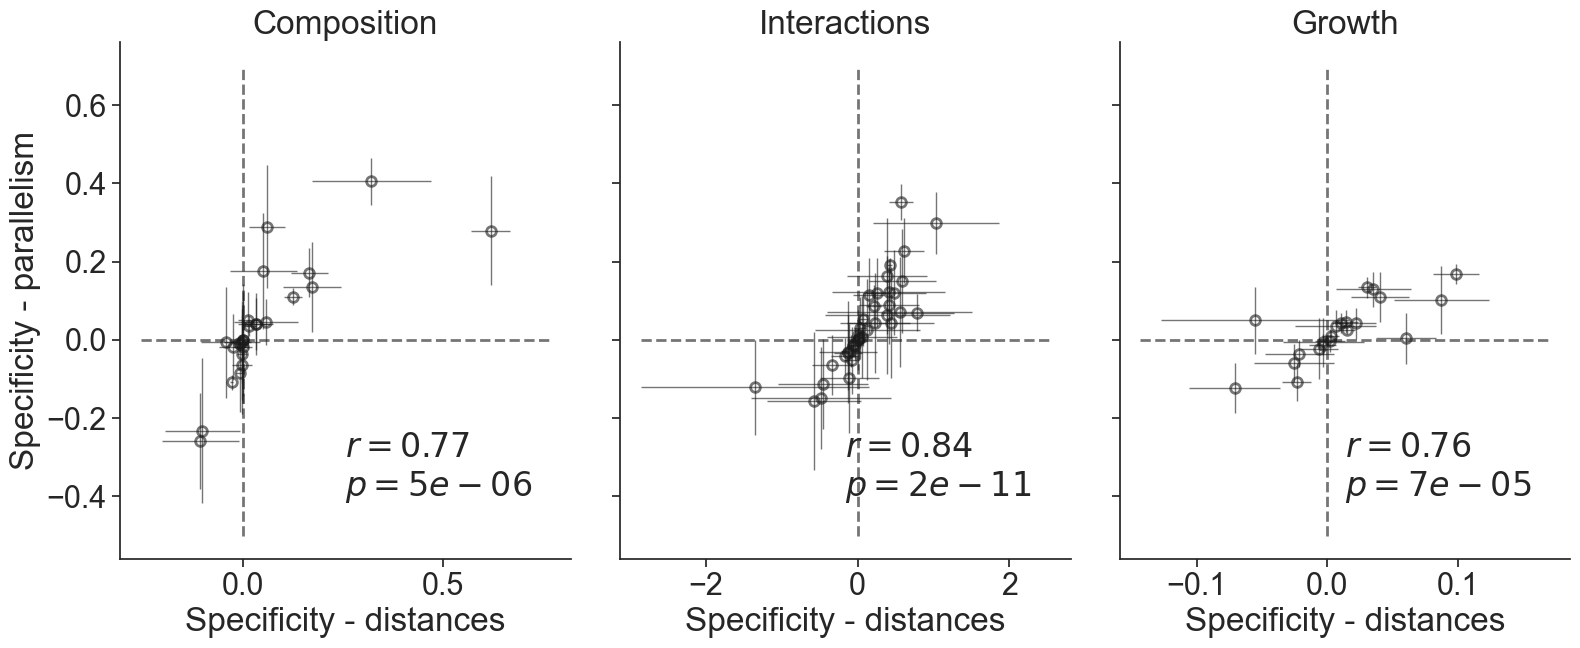

In [63]:
fig, ax = subplots(1, 3, figsize = (16, 7), sharey = True)


titles = ['Composition', 'Interactions', 'Growth']
for i, param in enumerate([sum_comp, sum_int, sum_growth]):
    ax[i].errorbar(x = param[('Distance', 'mean', 'score')],
                y = param[('Par', 'mean', 'score')], 
                xerr = param[('Distance', 'sem', 'score')],
                yerr = param[('Par', 'sem', 'score')], 
                fmt = 'o', mfc = 'None' ,
                ms = 7, color = 'k', mew = 2, capsize = 0, lw = 1, alpha = 0.6)
    ax[i].set_title(titles[i])
    xmax = param[('Distance', 'mean', 'score')].max() + param[('Distance', 'sem', 'score')].max()
    xmin = param[('Distance', 'mean', 'score')].min() - param[('Distance', 'sem', 'score')].max()
    ymax = param[('Par', 'mean', 'score')].max() + param[('Par', 'sem', 'score')].max()
    ymin = param[('Par', 'mean', 'score')].min() - param[('Par', 'sem', 'score')].max()
    
    ymax = .7
    ymin = -.5
    

    ax[i].plot([0, 0], [ymin, ymax], '--', color = 'k',alpha =0.6)
    ax[i].plot([xmin, xmax], [0, .0], '--', color = 'k',alpha =0.6)
    pear_res = pearsonr(param[('Distance', 'mean', 'score')], 
                       param[('Par', 'mean', 'score')].values)
    
#     ax[i].text(s = 'r = ' + str(round(pear_res[0], 2)),
#                x = xmin + (xmax - xmin)*0.5, y = -0.3)
    ax[i].text(s = f'$r =  {round(pear_res[0], 2)}$',
               x = xmin + (xmax - xmin)*0.5, y = -0.3)
    ax[i].text(s = f'$p = {pear_res[1]:.0}$',
               x = xmin + (xmax - xmin)*0.5, y = -0.4)
    ax[i].set_xlabel('Specificity - distances')
    
tight_layout()

ax[0].set_ylabel('Specificity - parallelism')
savefig('figures/Supplementary/S25.png')

# Stats

In [64]:
print('{} are negetivly affected'.format((inter_na['mean']<0).mean()))
print('{} avarage negative interarction'.format(inter_na.loc[inter_na['mean'].dropna()<0, 'mean'].mean()))
print('{} avarage Positive interarction'.format(inter_na.loc[inter_na['mean'].dropna()>0, 'mean'].mean()))      

0.7954545454545454 are negetivly affected
-1.5482646032035252 avarage negative interarction
1.5880889620887857 avarage Positive interarction


In [65]:
sum_comp[('Par', 'mean')].unstack().describe()

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3146927899.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  sum_comp[('Par', 'mean')].unstack().describe()


between                 within                  score            
treatment      Naive Pre-adapted      Naive Pre-adapted      Naive Pre-adapted
count      13.000000   13.000000  13.000000   13.000000  13.000000   13.000000
mean        0.702422    0.594720   0.767062    0.601779   0.064640    0.007058
std         0.236908    0.255665   0.177101    0.260524   0.124517    0.165999
min         0.092694    0.128117   0.497902    0.090964  -0.085332   -0.258064
25%         0.641608    0.438128   0.616395    0.432327  -0.008876   -0.062962
50%         0.709092    0.553641   0.755119    0.637939   0.040340   -0.005801
75%         0.834099    0.827156   0.932765    0.799003   0.109993    0.045514
max         1.000000    0.944450   1.000000    0.934570   0.405208    0.289196

In [66]:
sum_int[('Par', 'mean')].unstack(1).describe()

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\3383921628.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  sum_int[('Par', 'mean')].unstack(1).describe()


between                 within                  score            
treatment      Naive Pre-adapted      Naive Pre-adapted      Naive Pre-adapted
count      22.000000   18.000000  22.000000   18.000000  22.000000   18.000000
mean        0.664493    0.611456   0.696206    0.658453   0.031713    0.046997
std         0.181000    0.210879   0.200338    0.184835   0.111426    0.113602
min         0.383849    0.322951   0.319911    0.294729  -0.155455   -0.121055
25%         0.520865    0.418559   0.537086    0.553936  -0.029775   -0.011266
50%         0.632267    0.610673   0.715026    0.640745   0.016080    0.021542
75%         0.804056    0.780172   0.854785    0.767057   0.081764    0.118812
max         0.978914    0.950697   0.984640    0.941671   0.353002    0.298760

In [67]:
sum_growth[('Par', 'mean')].unstack().describe()

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\1082601701.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  sum_growth[('Par', 'mean')].unstack().describe()


between                 within                  score            
treatment      Naive Pre-adapted      Naive Pre-adapted      Naive Pre-adapted
count      10.000000   11.000000  10.000000   11.000000  10.000000   11.000000
mean        0.662879    0.578190   0.690942    0.601231   0.028063    0.023040
std         0.108429    0.123738   0.107050    0.122073   0.055230    0.092975
min         0.516793    0.392958   0.521230    0.406013  -0.034681   -0.123179
25%         0.597557    0.484745   0.636592    0.532659  -0.000116   -0.040538
50%         0.618238    0.590336   0.674745    0.559069   0.017068    0.046754
75%         0.731974    0.643792   0.747899    0.689472   0.040988    0.105651
max         0.879871    0.778886   0.905061    0.804795   0.167992    0.134068

In [68]:
sum_gene[('Par', 'mean')].unstack().describe()

C:\Users\nitta\AppData\Local\Temp\ipykernel_17688\1367463571.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  sum_gene[('Par', 'mean')].unstack().describe()


between                within                 score            
treatment     Naive Pre-adapted     Naive Pre-adapted     Naive Pre-adapted
count      6.000000    5.000000  6.000000    5.000000  6.000000    5.000000
mean       0.101317    0.055170  0.173513    0.201147  0.072196    0.145977
std        0.074569    0.038405  0.065907    0.264436  0.052435    0.296004
min        0.040741    0.000000  0.064565    0.039216  0.017627   -0.063057
25%        0.042347    0.039216  0.147932    0.060606  0.030663    0.016108
50%        0.078941    0.060317  0.186013    0.076426  0.067513    0.021390
75%        0.133766    0.074046  0.207107    0.162821  0.099993    0.088775
max        0.227090    0.102273  0.255111    0.666667  0.151323    0.666667

In [69]:
int_fin[['mean', 'gene_diff']].dropna()

mean  gene_diff
treat       sp  sample                       
Naive       Ea  Ea_Pa    -0.616703   0.180000
            Pa  Ea_Pa    -1.064012   0.127778
            Ea  Ea_Pch   -0.529128   0.106667
            Pch Ea_Pch   -1.694696  -0.071111
            Ea  Ea_Pf    -1.442801   0.055556
            Pf  Ea_Pf     3.588967   0.112981
            Pa  Pa_Pv     0.416841   0.159259
            Pch Pch_IN63 -5.494246   0.155556
                Pch_Pf   -1.426448  -0.002381
            Pf  Pch_Pf    2.913211   0.112938
            Pch Pch_Sm   -1.121057  -0.014550
            Sm  Pch_Sm   -0.599328   0.006950
            Pf  Pf_Ab     3.485119   0.093236
            Ab  Pf_Ab    -3.665661   0.145833
            Pf  Pf_Sm     2.988968   0.021281
            Sm  Pf_Sm    -1.143694   0.010268
Pre-adapted Ab  Ab_IN72  -0.651625   0.066667
            Ea  Ea_Pa    -2.240703   0.325641
            Pa  Ea_Pa     0.285624   0.666667
            Ea  Ea_Pch   -1.508994  -0.037037
            Pch Ea_Pch    0.612933  -0.125000
            Ea  Ea_Pf    -1.560621  -0.044444
            Pf  Ea_Pf    -0.067226  -0.046061
            Pch Pch_Pci  -2.180248  -0.125000
                Pch_Sm    0.099305  -0.048611
            Pf  Pf_Ab    -0.781171   0.039538
            Ab  Pf_Ab    -0.827068  -0.333333
            Pf  Pv_Pf    -5.789067  -0.050595